# I. IMPORT REQUIRED LIBRARIES

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Plotation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score,
    precision_score, recall_score, log_loss, precision_recall_curve, auc,
    classification_report
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss

# Hyperparameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    KFold, train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Misc
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed

# II. UPLOAD DATA

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.head(10)

Gender  Age  Driving_License  Region_Code  Previously_Insured  Vehicle_Age  \
0       1    2                1            1                   0            3   
1       1    3                1            3                   0            2   
2       1    2                1            1                   0            3   
3       1    1                1            3                   1            1   
4       0    1                1            2                   1            1   
5       0    1                1            3                   0            1   
6       1    1                1            3                   0            1   
7       0    2                1            1                   0            2   
8       0    1                1            3                   1            1   
9       0    1                1            3                   1            1   

   Vehicle_Damage  Annual_Premium  Policy_Sales_Channel   Vintage  Response  
0               1        0.070366                     2  0.716263         1  
1               0        0.057496                     2  0.598616         0  
2               1        0.066347                     2  0.058824         1  
3               0        0.048348                     1  0.667820         0  
4               0        0.046259                     1  0.100346         0  
5               1        0.000000                     3  0.574394         0  
6               1        0.038578                     1  0.826990         0  
7               1        0.054696                     2  0.214533         1  
8               0        0.046488                     1  0.062284         0  
9               0        0.048631                     1  0.242215         0

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
train.describe()

Gender            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean        0.540761       1.627461         0.997869       2.156979   
std         0.498336       0.665683         0.046110       0.831136   
min         0.000000       1.000000         0.000000       1.000000   
25%         0.000000       1.000000         1.000000       1.000000   
50%         1.000000       2.000000         1.000000       2.000000   
75%         1.000000       2.000000         1.000000       3.000000   
max         1.000000       3.000000         1.000000       3.000000   

       Previously_Insured    Vehicle_Age  Vehicle_Damage  Annual_Premium  \
count       381109.000000  381109.000000   381109.000000   381109.000000   
mean             0.458210       1.609616        0.504877        0.051193   
std              0.498251       0.567439        0.499977        0.028791   
min              0.000000       1.000000        0.000000        0.000000   
25%              0.000000       1.000000        0.000000        0.040509   
50%              0.000000       2.000000        1.000000        0.054023   
75%              1.000000       2.000000        1.000000        0.068405   
max              1.000000       3.000000        1.000000        0.110249   

       Policy_Sales_Channel        Vintage       Response  
count         381109.000000  381109.000000  381109.000000  
mean               2.241482       0.499472       0.122563  
std                1.098346       0.289520       0.327936  
min                1.000000       0.000000       0.000000  
25%                1.000000       0.249135       0.000000  
50%                2.000000       0.498270       0.000000  
75%                3.000000       0.750865       0.000000  
max                4.000000       1.000000       1.000000

# III. MAIN DEF

In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.1, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

- ở code trên chọn test_size = 0,1 để test phần IV. vì ở phần train test ratio thì đây cho ra kết quả tốt nhất

# IV. SELECT THE APPROPRIATE TUNING METHOD

## 4.1 Halving_Randomized_Search_CV

################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------

Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.933343   0.940724  0.93305  0.933031       0.984118  0.217566


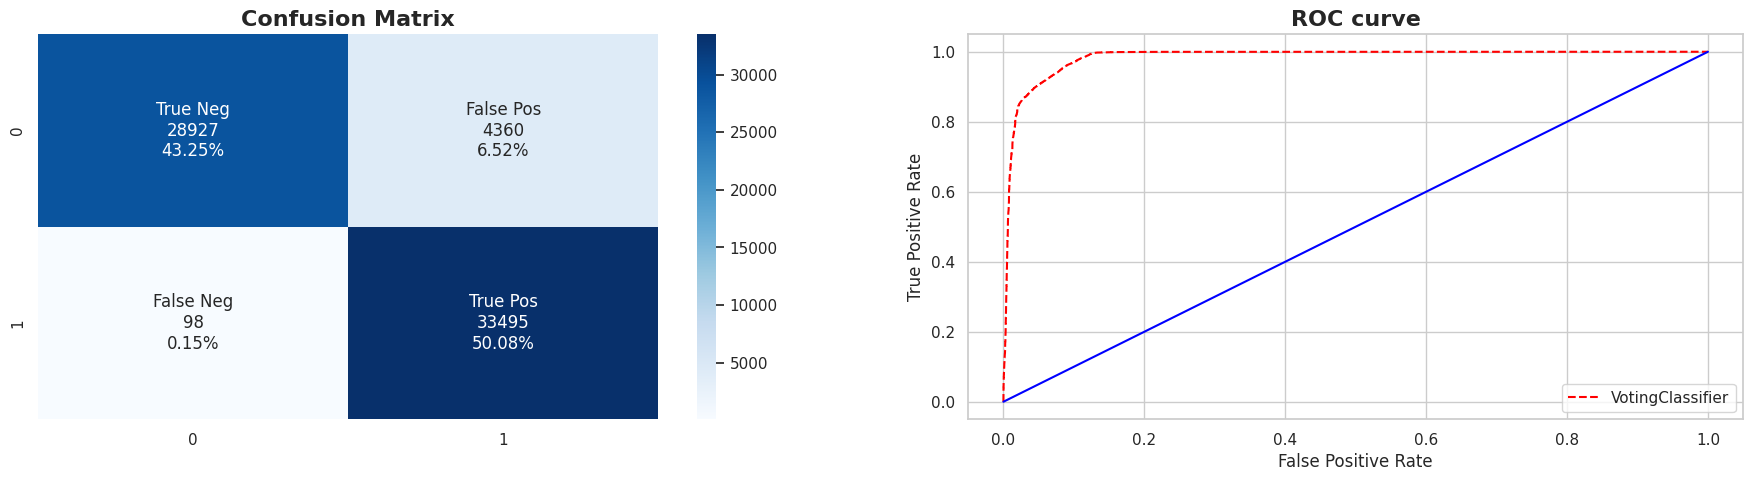

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=50159. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.7578170070381908 
---
Best Parameters for VotingClassifier : {'lr__C': 10.0, 'dt__max_depth': None, 'bagging__n_estimators': 50}
--------------------------------------------------
Elapsed Time: 00:01:55

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.933343   0.940724  0.93305  0.933031       0.984118  0.217565


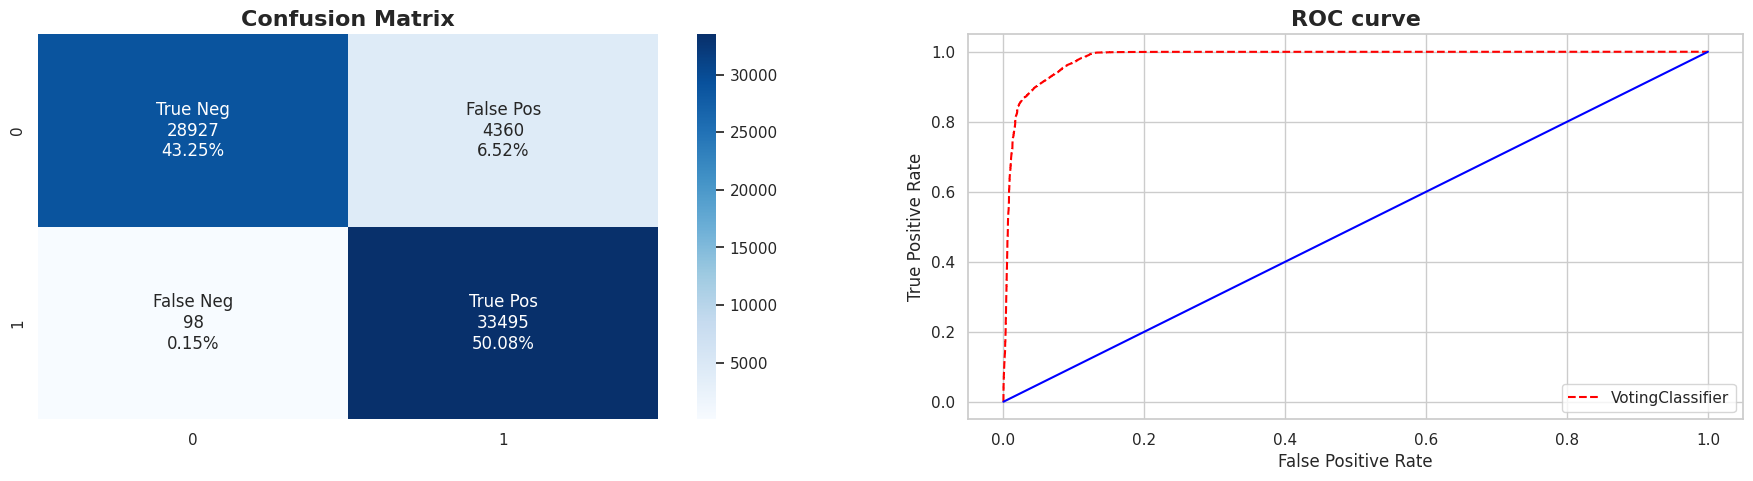

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)

# IV. MACHINE LEARNING: HYPER-PRAMETER TUNNING

## 4.1 RATIO 50:50

### 4.1.1 Upload Data

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=5, n_iter=50, n_jobs=-1)
    elif tuning_model == 'Grid_Search_CV':
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.5, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

### 4.4.2 Decision Tree

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------

Evaluation of DecisionTreeClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.902769   0.910631  0.902713  0.902292       0.912833  2.844746


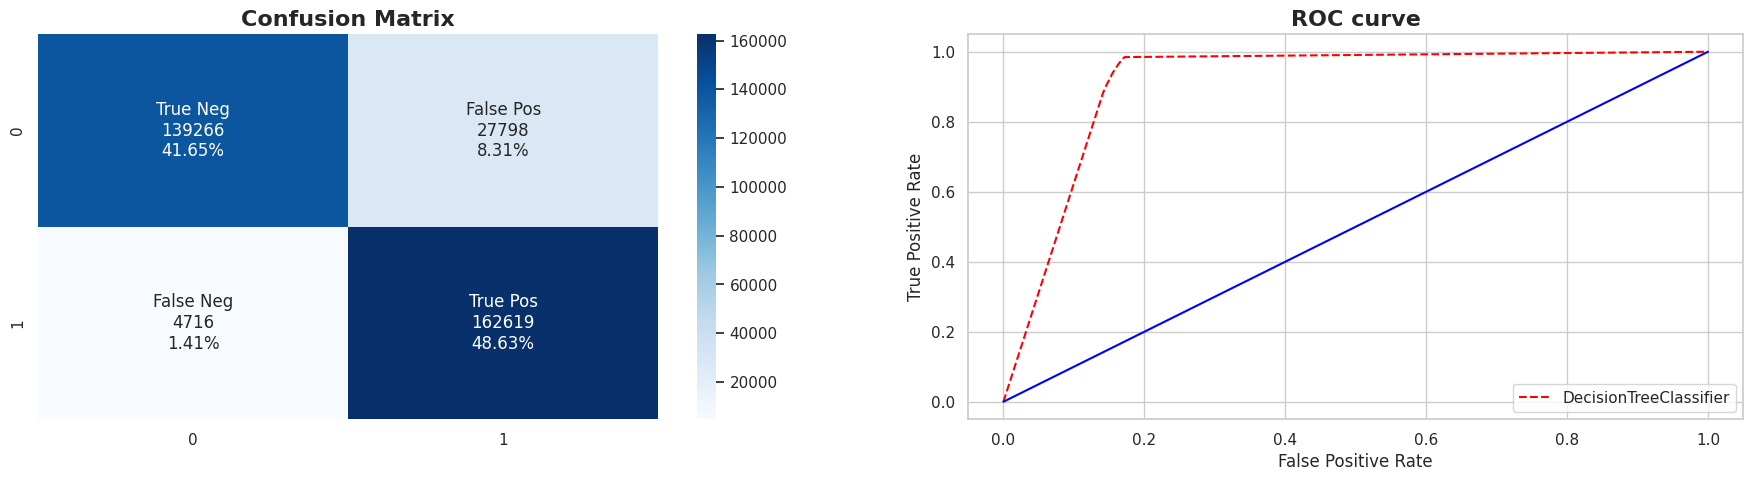

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3200 is smaller than n_iter=16719. Running 3200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for DecisionTreeClassifier : 0.7805162227153823 
---
Best Parameters for DecisionTreeClassifier : {'splitter': 'random', 'random_state': 42, 'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 1, 'max_leaf_nodes': 60, 'max_features': None, 'max_depth': 5}
--------------------------------------------------
Elapsed Time: 00:01:55

Evaluation of DecisionTreeClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.787664   0.817183  0.78754  0.782556       0.830039  0.438615


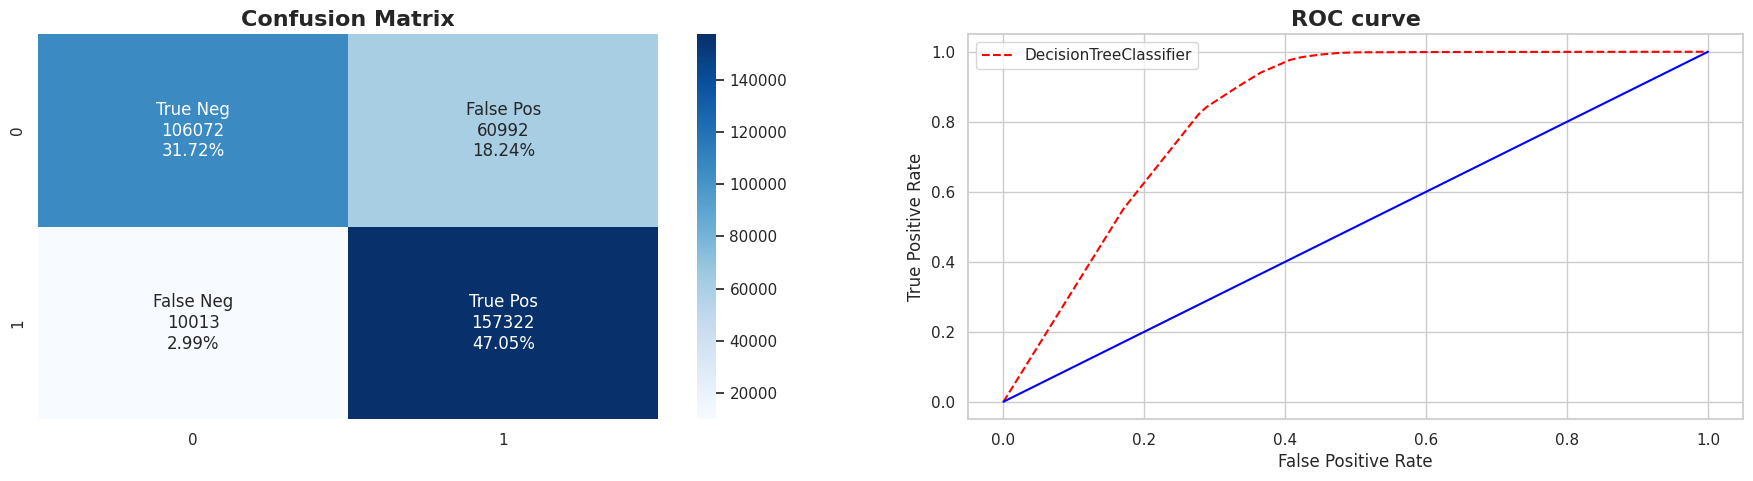

In [ ]:

Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_decision_tree = {"splitter":["best","random"],
            "max_depth" : [None,5,7,9],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0, 0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,40,50,60],
           'random_state':[42]}
ml_algorithm_implementation(train, DecisionTreeClassifier(), parameters_decision_tree, Tuning_Method, False)

### 4.4.3 Logistic Regression

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
LogisticRegression
--------------------------------------------------

Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.785307   0.834002  0.785153  0.777124       0.831086  0.441754


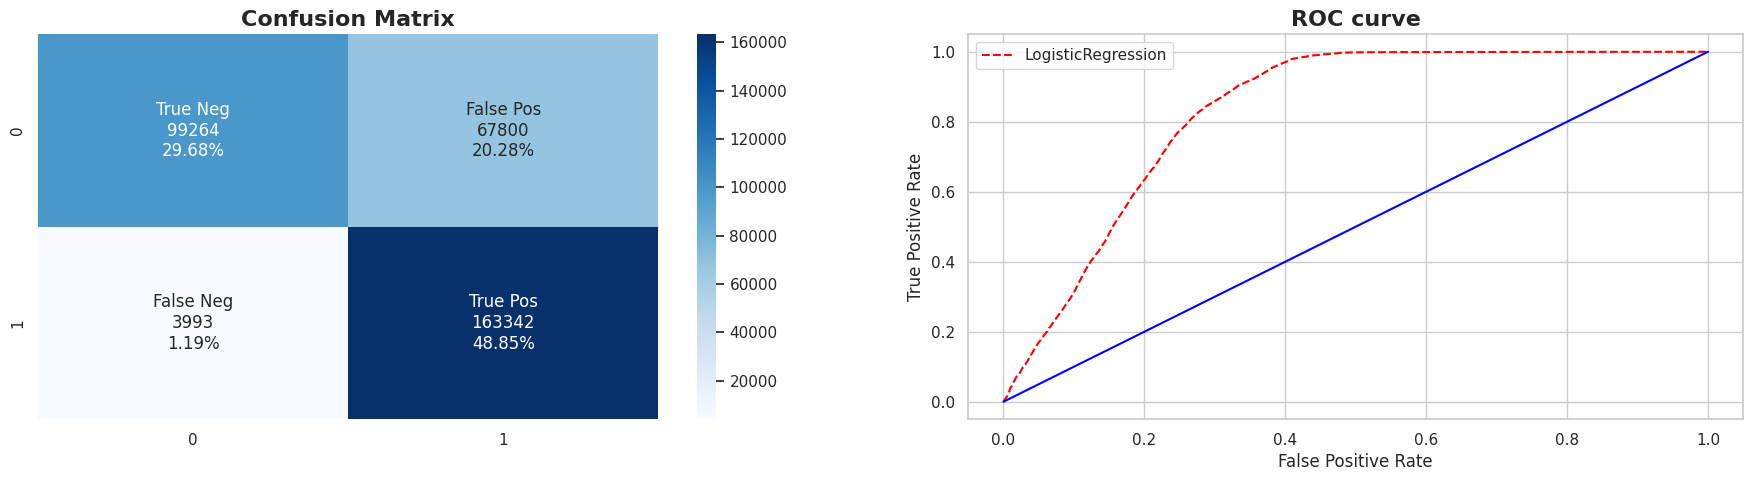

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=16719. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for LogisticRegression : 0.7921426098996193 
---
Best Parameters for LogisticRegression : {'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'C': 10}
--------------------------------------------------
Elapsed Time: 00:00:04

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.785307   0.834002  0.785153  0.777124       0.831087  0.441754


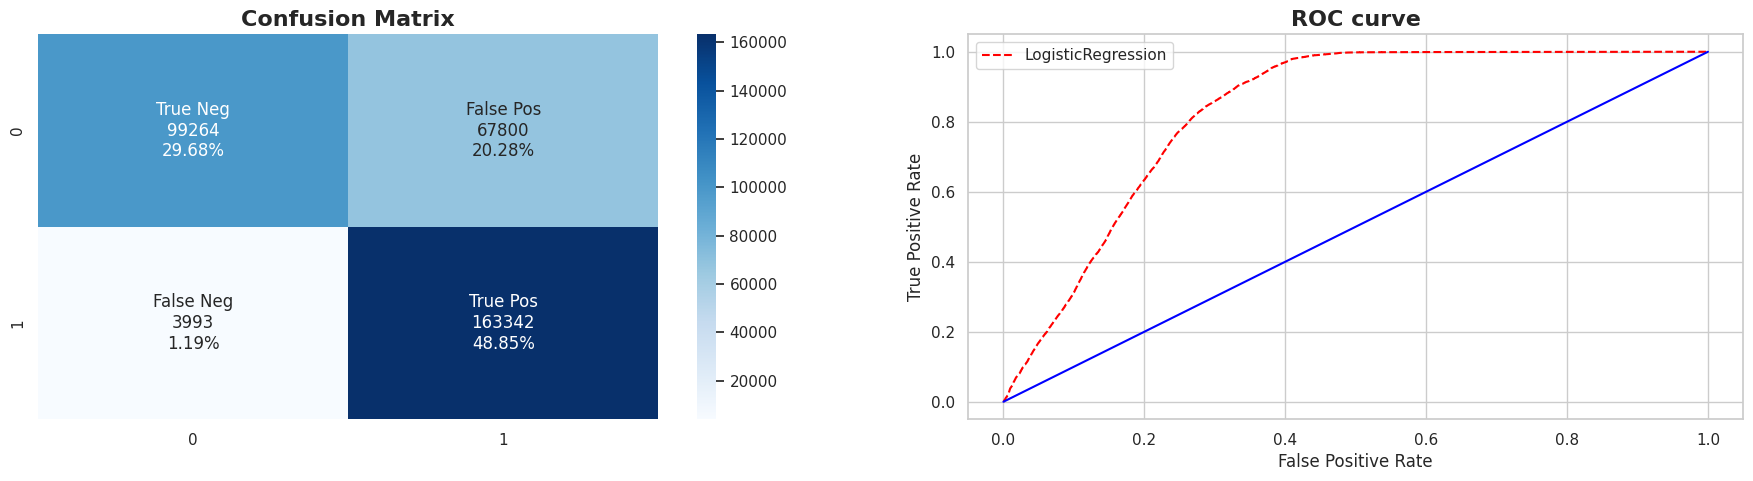

In [ ]:
# Set the tuning method
Tuning_Method = 'Halving_Randomized_Search_CV'

# Define the parameters for the logistic regression model
parameters_logistic = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                        'penalty' : ['l2'],
                        'C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
                       'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)


### 4.4.4 Bagging Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
BaggingClassifier
--------------------------------------------------

Evaluation of BaggingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.902189   0.909842  0.902133  0.901721       0.965848  0.598334


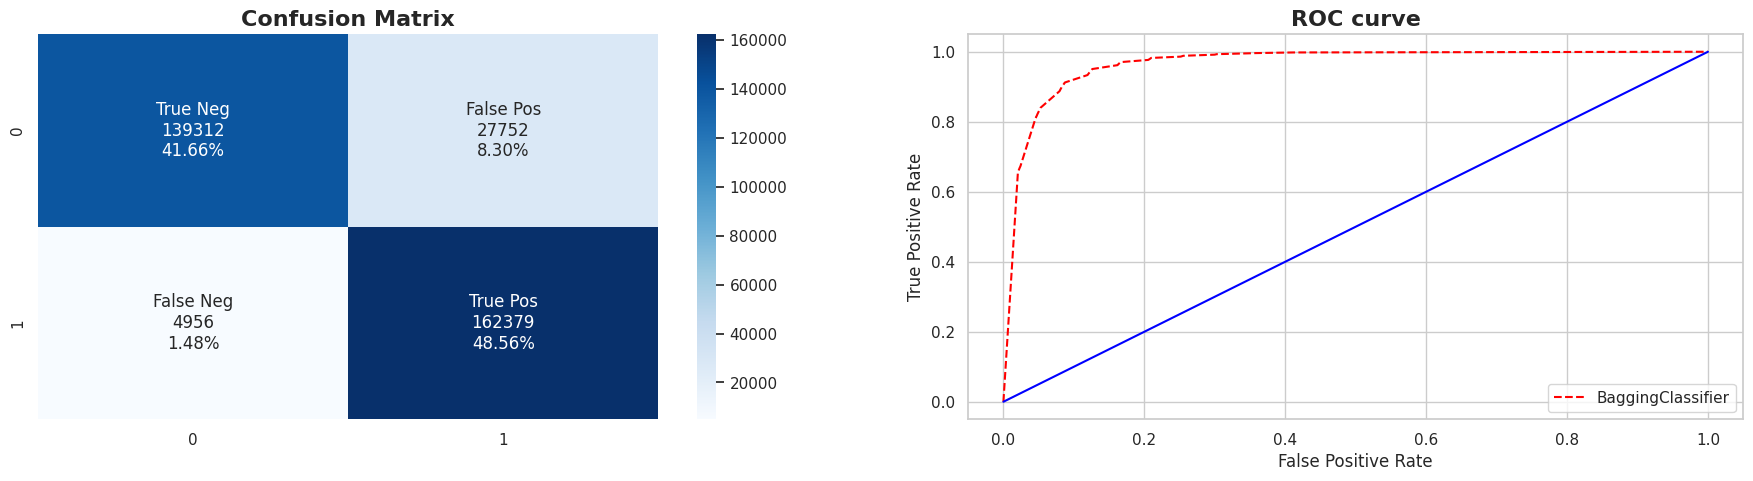

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=16719. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for BaggingClassifier : 0.7439393939393939 
---
Best Parameters for BaggingClassifier : {'random_state': 42, 'n_estimators': 400}
--------------------------------------------------
Elapsed Time: 00:06:55

Evaluation of BaggingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.897882   0.908634  0.897817  0.897195       0.975809  0.275674


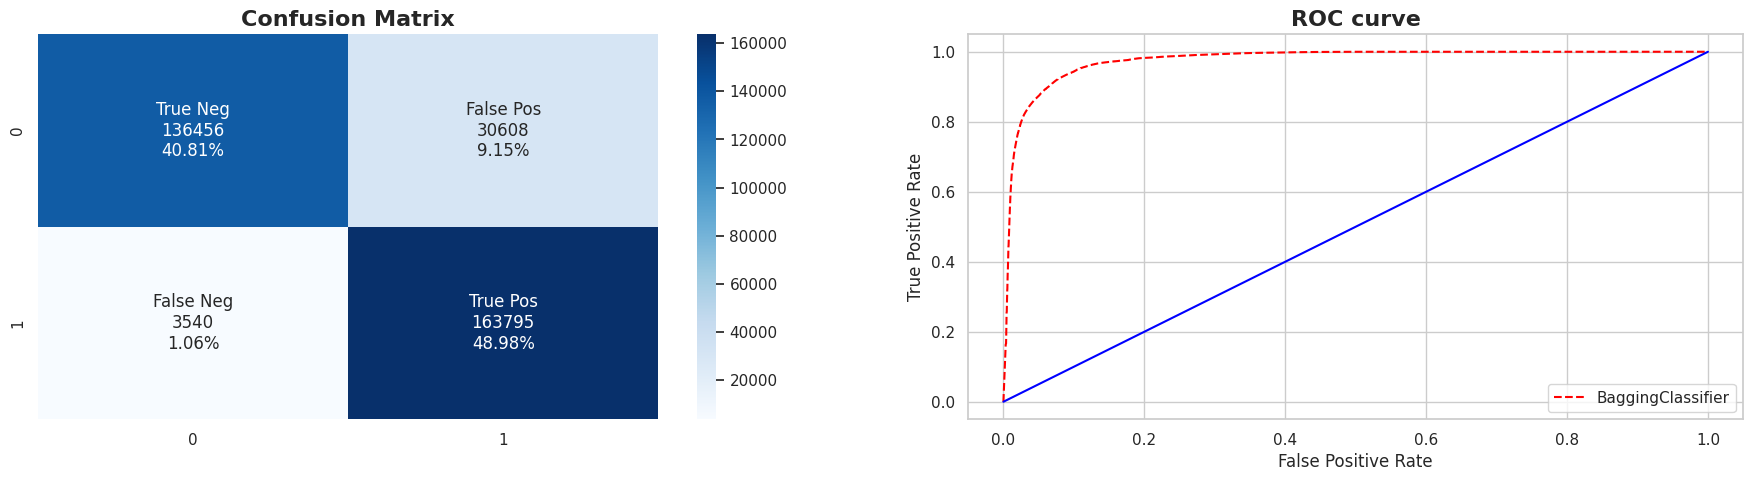

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

parameters_bagging = {'n_estimators':[10, 100, 200, 400],
                      'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, BaggingClassifier(), parameters_bagging, Tuning_Method, False)


### 4.4.5 Random Forest

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.897443   0.907976  0.897378  0.896766       0.970476  0.344641


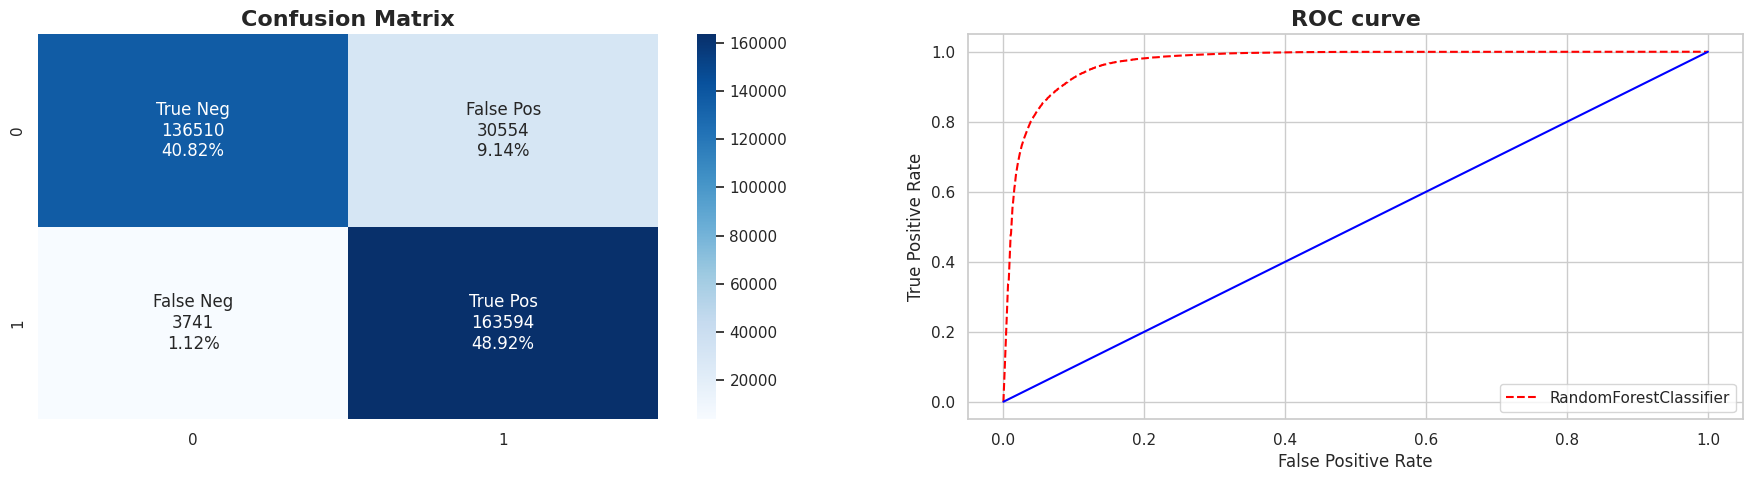

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=16719. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for RandomForestClassifier : 0.7765079365079366 
---
Best Parameters for RandomForestClassifier : {'random_state': 42, 'n_estimators': 400, 'max_depth': 7}
--------------------------------------------------
Elapsed Time: 00:01:24

Evaluation of RandomForestClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.789527    0.82295  0.789396  0.783885       0.842667  0.432497


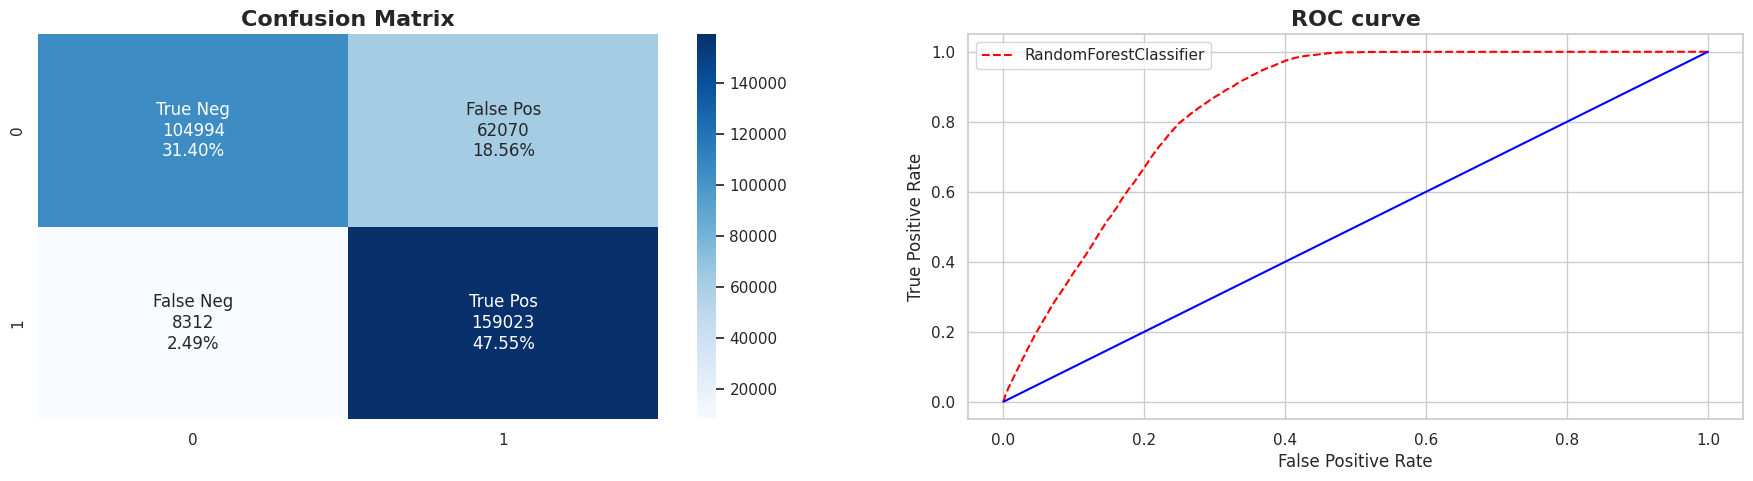

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_random_forest = {'n_estimators': [100, 200, 400],
                            'max_depth': [3, 5, 7],
                            'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)

### 4.4.6 XGBoost

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.799946   0.824357  0.799834  0.796068       0.855386  0.417631


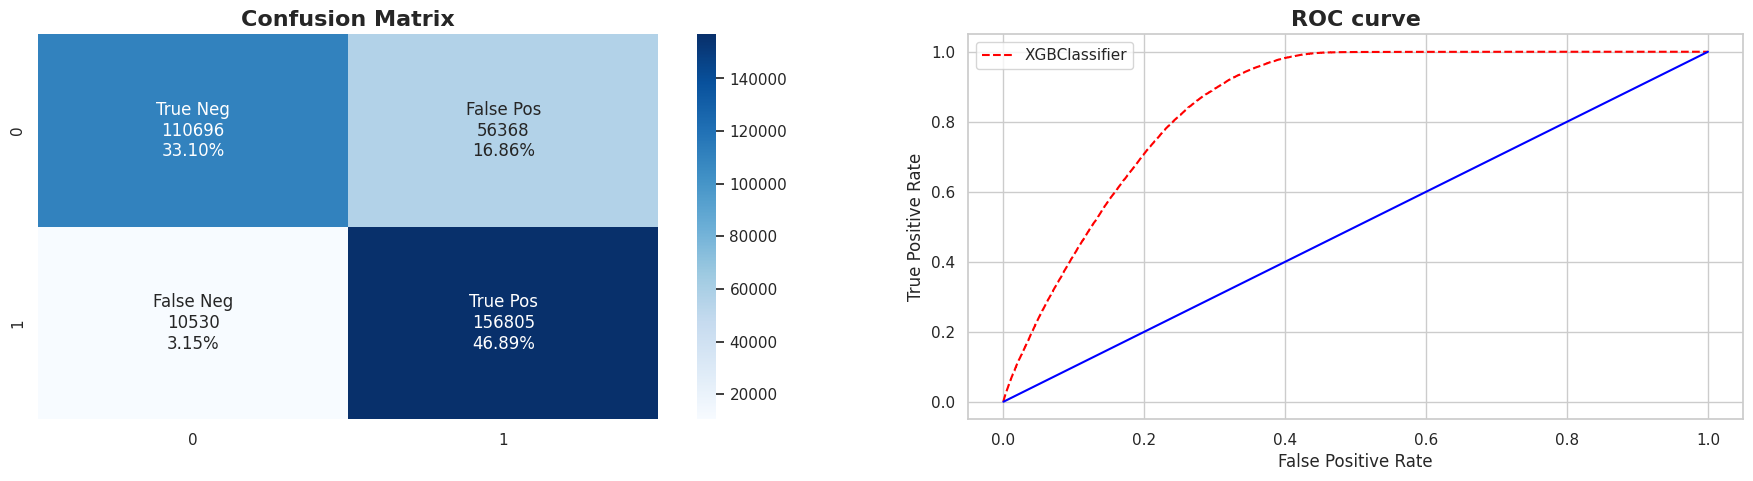

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=16719. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for XGBClassifier : 0.7346486673589477 
---
Best Parameters for XGBClassifier : {'random_state': 42, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3}
--------------------------------------------------
Elapsed Time: 00:00:07

Evaluation of XGBClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0         0.79066   0.819945  0.790538   0.78571       0.845142  0.430659


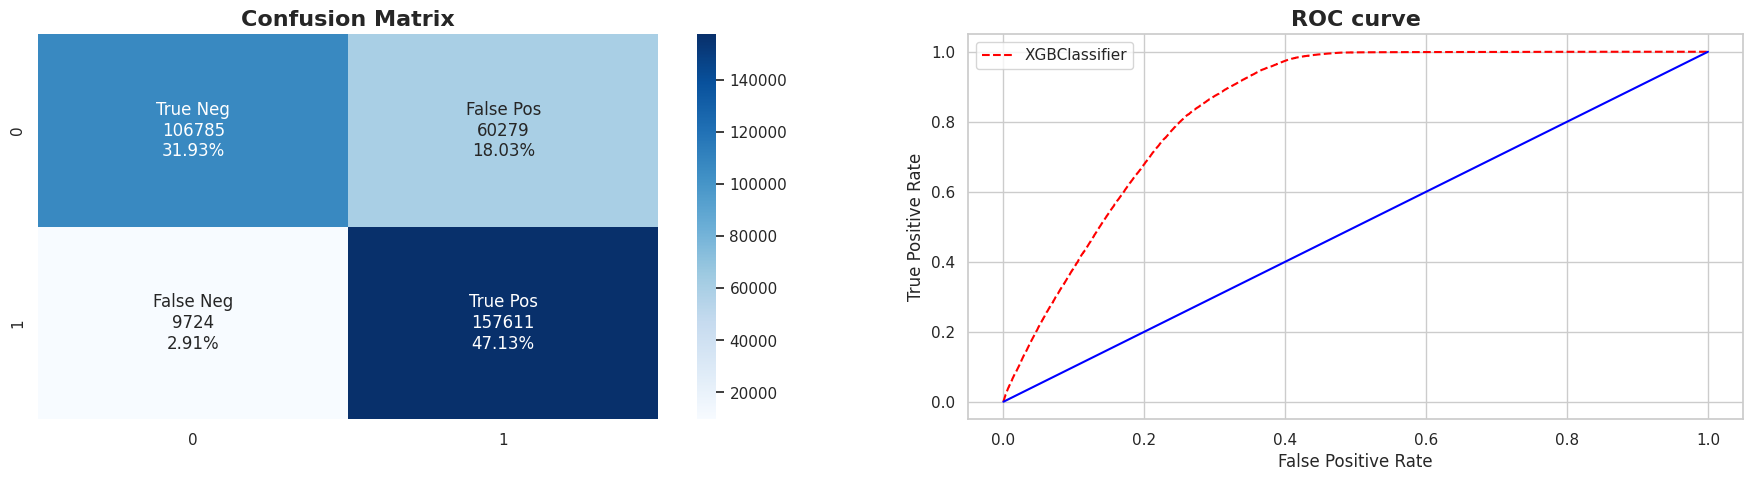

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_xgb = {'n_estimators': [100, 200, 400],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.3],
                  'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, xgb.XGBClassifier(), parameters_xgb, Tuning_Method, False)

### 4.4.7 Voting Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------

Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.904315    0.91442  0.904252  0.903718       0.968952  0.263713


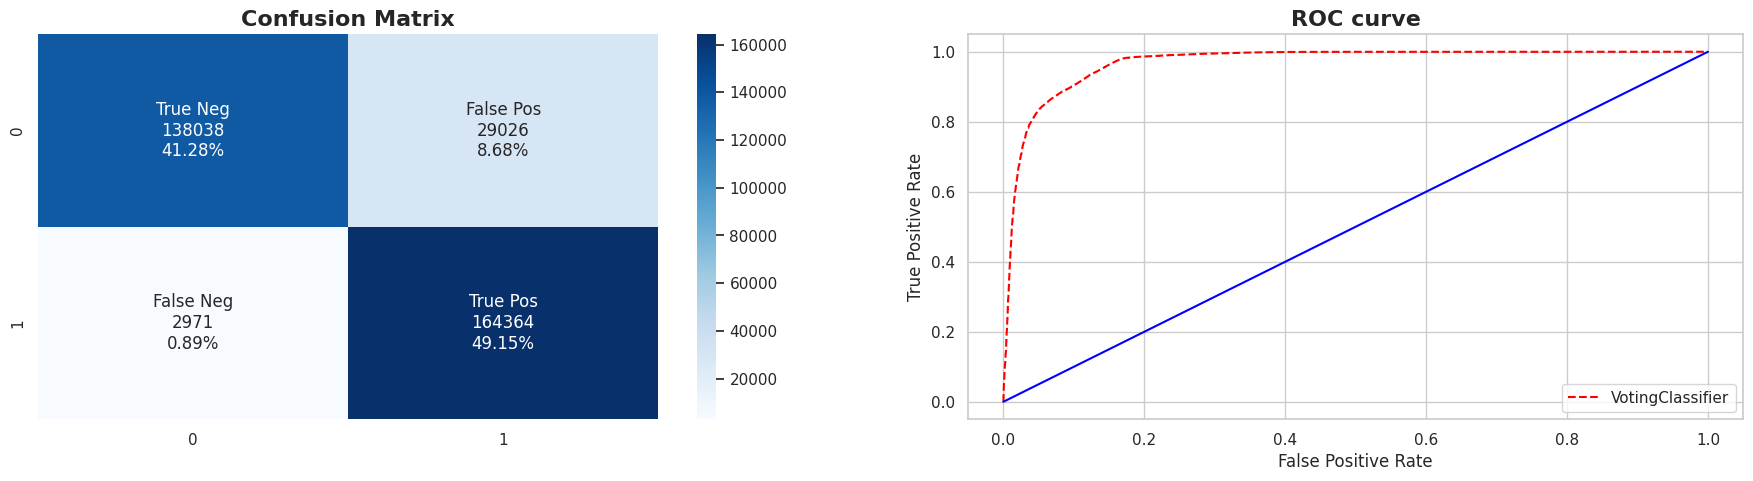

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=16719. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.7345794392523365 
---
Best Parameters for VotingClassifier : {'lr__C': 0.1, 'dt__max_depth': 10, 'bagging__n_estimators': 50}
--------------------------------------------------
Elapsed Time: 00:01:19

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0          0.8388   0.869334  0.838684  0.835365       0.952316  0.336131


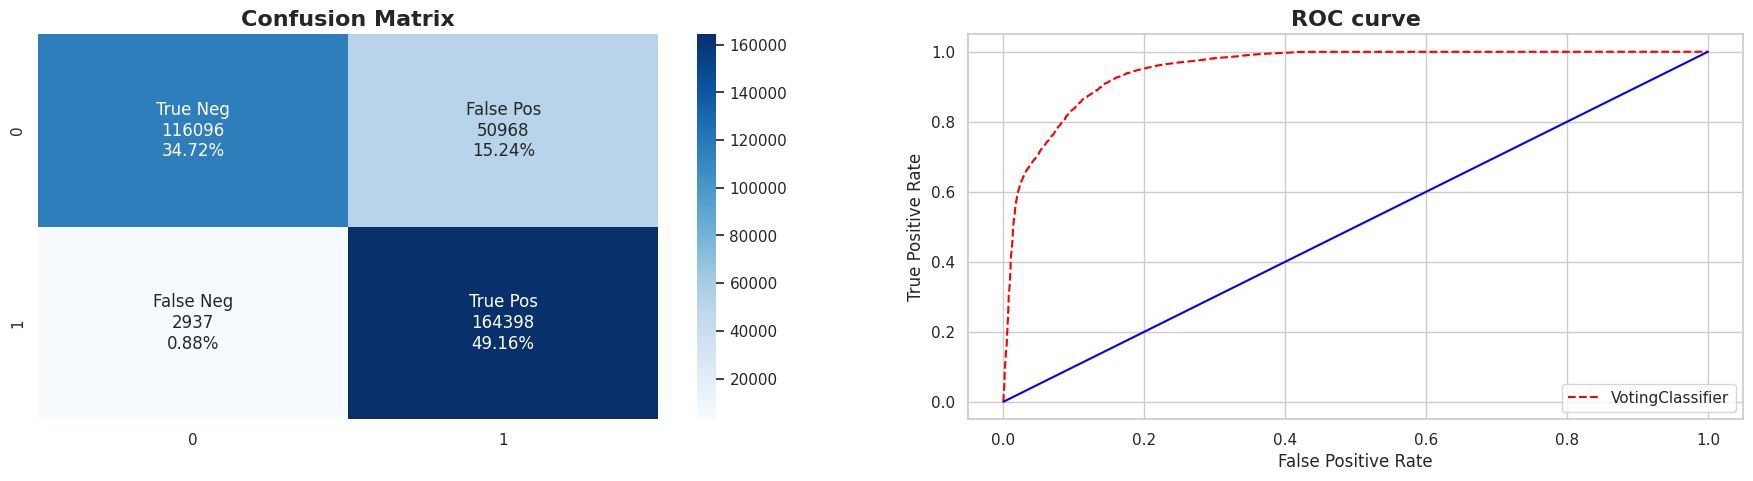

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)

## 4.2 RATIO 70:30

### 4.1.1 Upload Data

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=5, n_iter=50, n_jobs=-1)
    elif tuning_model == 'Grid_Search_CV':
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.3, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

### 4.4.2 Decision Tree

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------

Evaluation of DecisionTreeClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.922643   0.930015  0.922523  0.922295       0.932905  2.141784


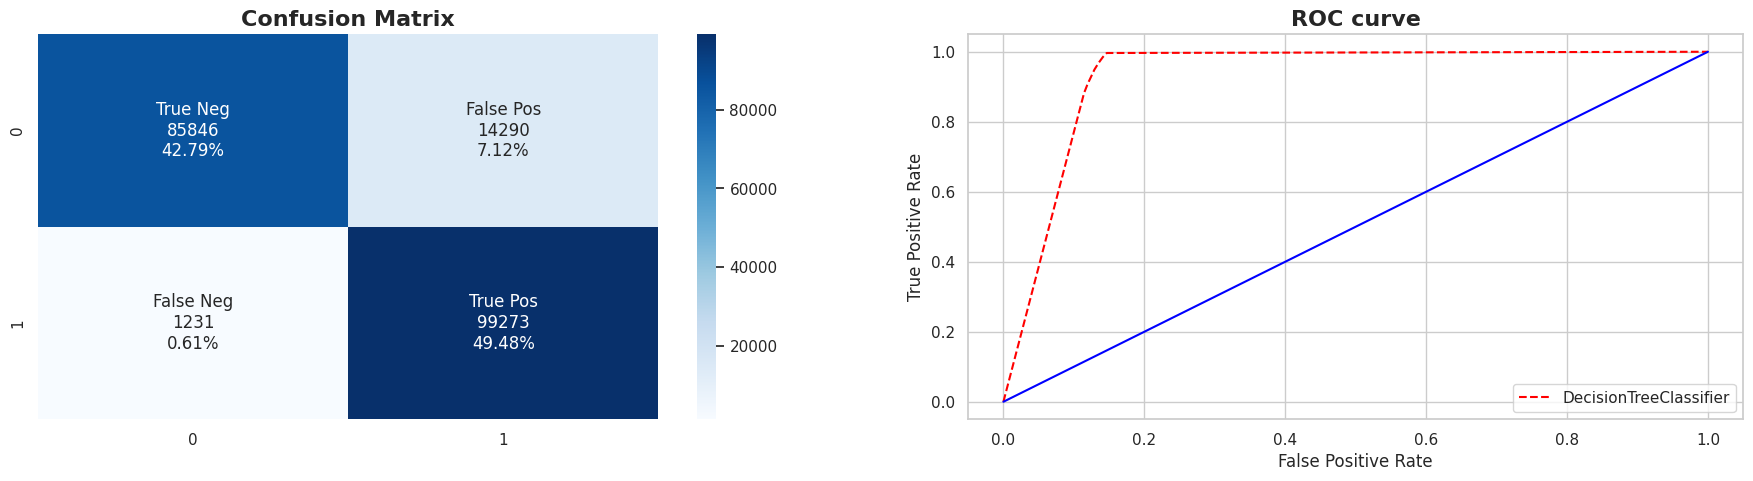

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3200 is smaller than n_iter=23407. Running 3200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for DecisionTreeClassifier : 0.7869585961381809 
---
Best Parameters for DecisionTreeClassifier : {'splitter': 'random', 'random_state': 42, 'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 5}
--------------------------------------------------
Elapsed Time: 00:01:58

Evaluation of DecisionTreeClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.788871   0.818624  0.78859  0.783712       0.825773  0.440059


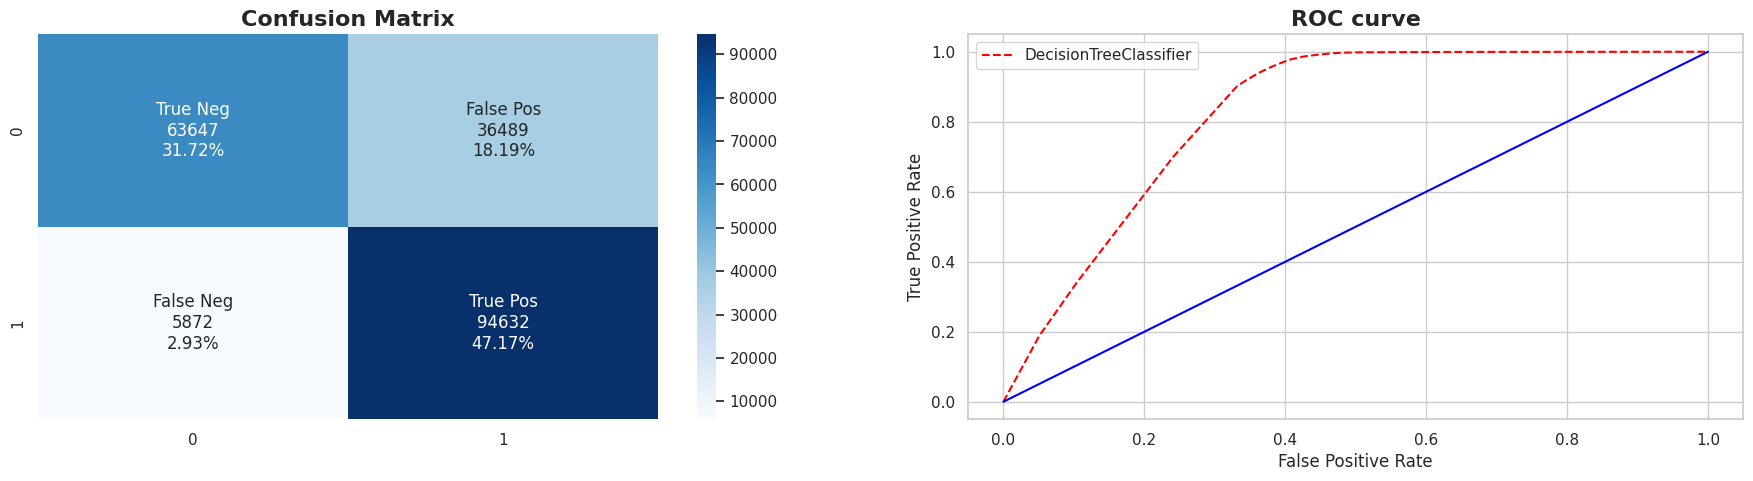

In [ ]:

Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_decision_tree = {"splitter":["best","random"],
            "max_depth" : [None,5,7,9],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0, 0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,40,50,60],
           'random_state':[42]}
ml_algorithm_implementation(train, DecisionTreeClassifier(), parameters_decision_tree, Tuning_Method, False)

### 4.4.3 Logistic Regression

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
LogisticRegression
--------------------------------------------------

Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.786099    0.83433  0.785751  0.777956       0.832143  0.440439


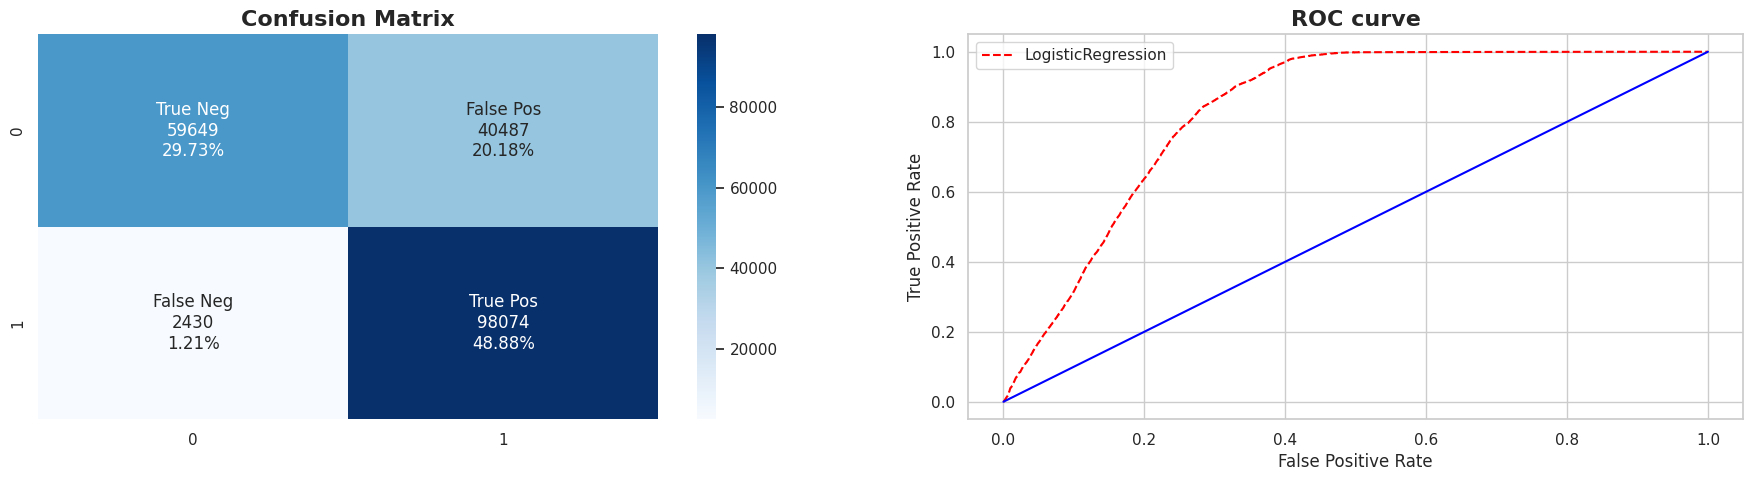

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=23407. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for LogisticRegression : 0.7751644167532018 
---
Best Parameters for LogisticRegression : {'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'C': 10}
--------------------------------------------------
Elapsed Time: 00:00:07

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.786099    0.83433  0.785751  0.777956       0.832149  0.440438


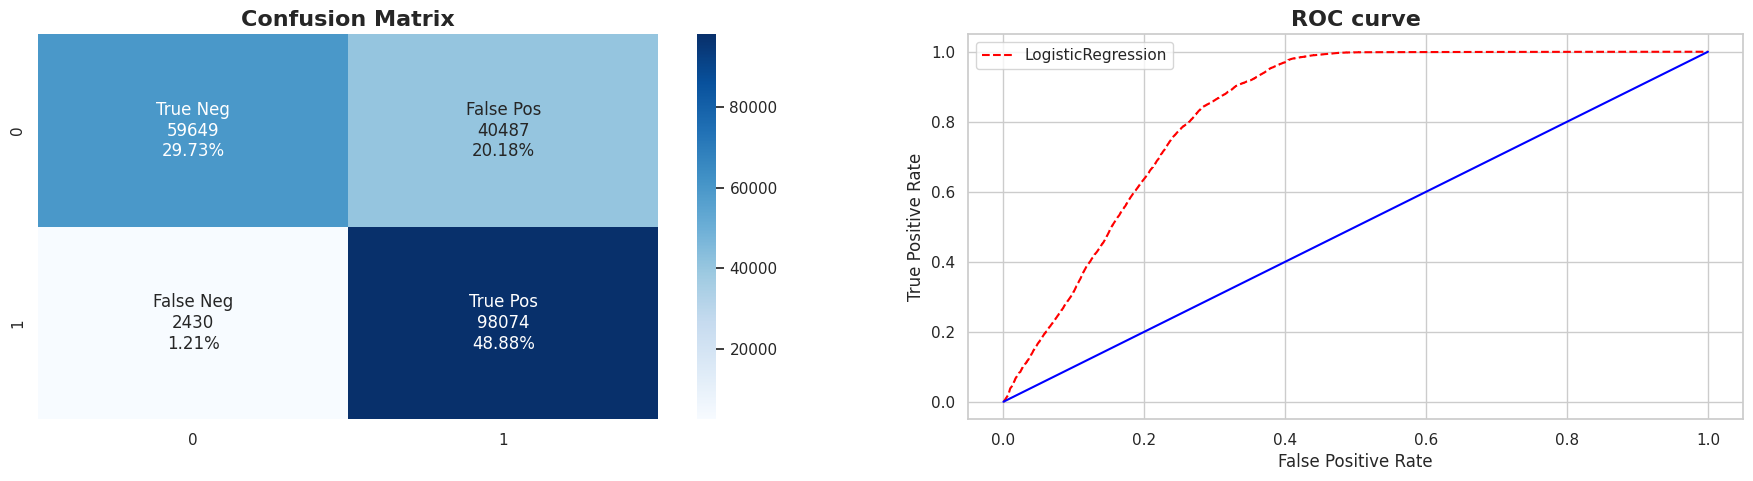

In [ ]:
# Set the tuning method
Tuning_Method = 'Halving_Randomized_Search_CV'

# Define the parameters for the logistic regression model
parameters_logistic = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                        'penalty' : ['l2'],
                        'C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
                       'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)


### 4.4.4 Bagging Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
BaggingClassifier
--------------------------------------------------

Evaluation of BaggingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.924636   0.931328  0.924522  0.924329       0.979566   0.46224


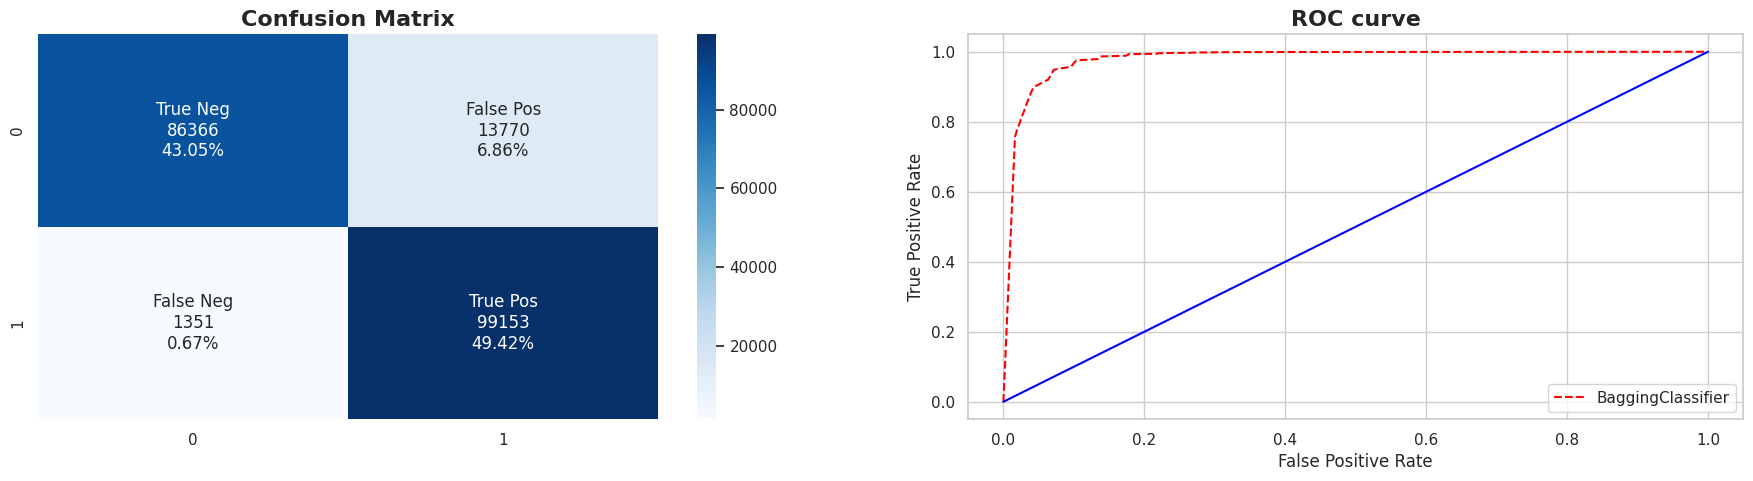

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=23407. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for BaggingClassifier : 0.7424242424242424 
---
Best Parameters for BaggingClassifier : {'random_state': 42, 'n_estimators': 100}
--------------------------------------------------
Elapsed Time: 00:02:32

Evaluation of BaggingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.920938   0.929078  0.920812  0.920545       0.985753  0.270992


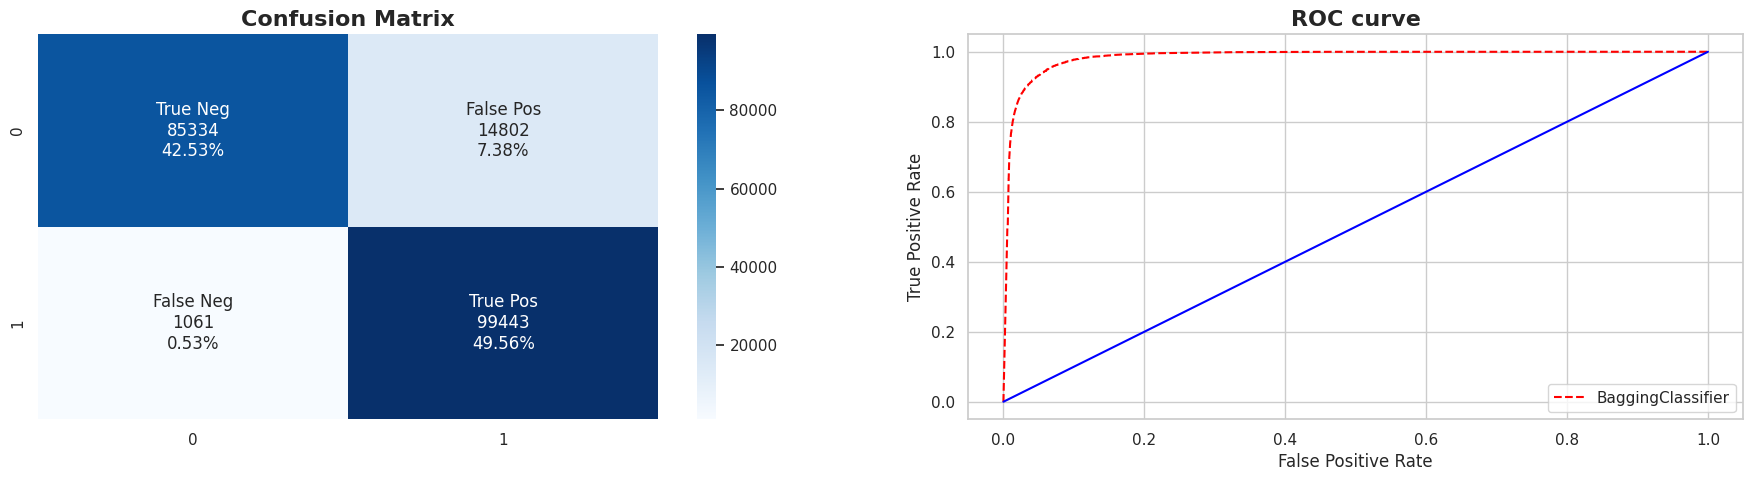

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

parameters_bagging = {'n_estimators':[10, 100, 200, 400],
                      'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, BaggingClassifier(), parameters_bagging, Tuning_Method, False)


### 4.4.5 Random Forest

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.918934     0.9276  0.918804  0.918504       0.982837  0.299668


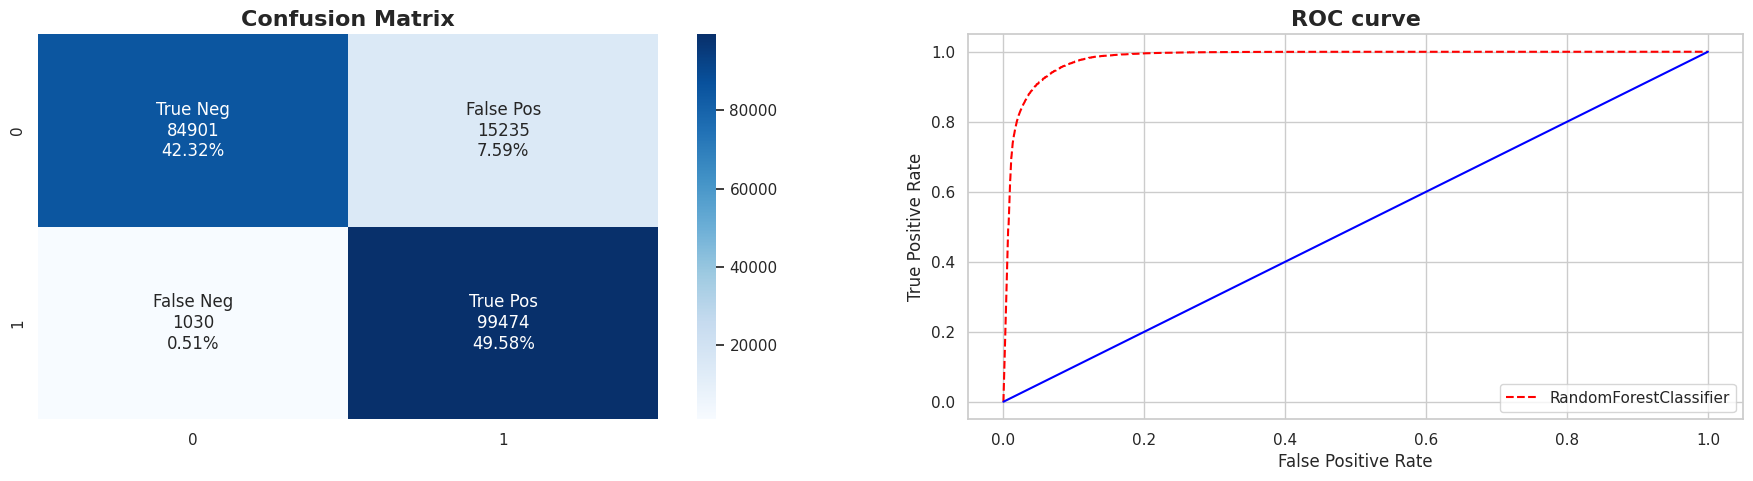

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=23407. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for RandomForestClassifier : 0.7420634920634922 
---
Best Parameters for RandomForestClassifier : {'random_state': 42, 'n_estimators': 100, 'max_depth': 7}
--------------------------------------------------
Elapsed Time: 00:00:39

Evaluation of RandomForestClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.790057   0.822936  0.789764  0.784458       0.843085  0.432879


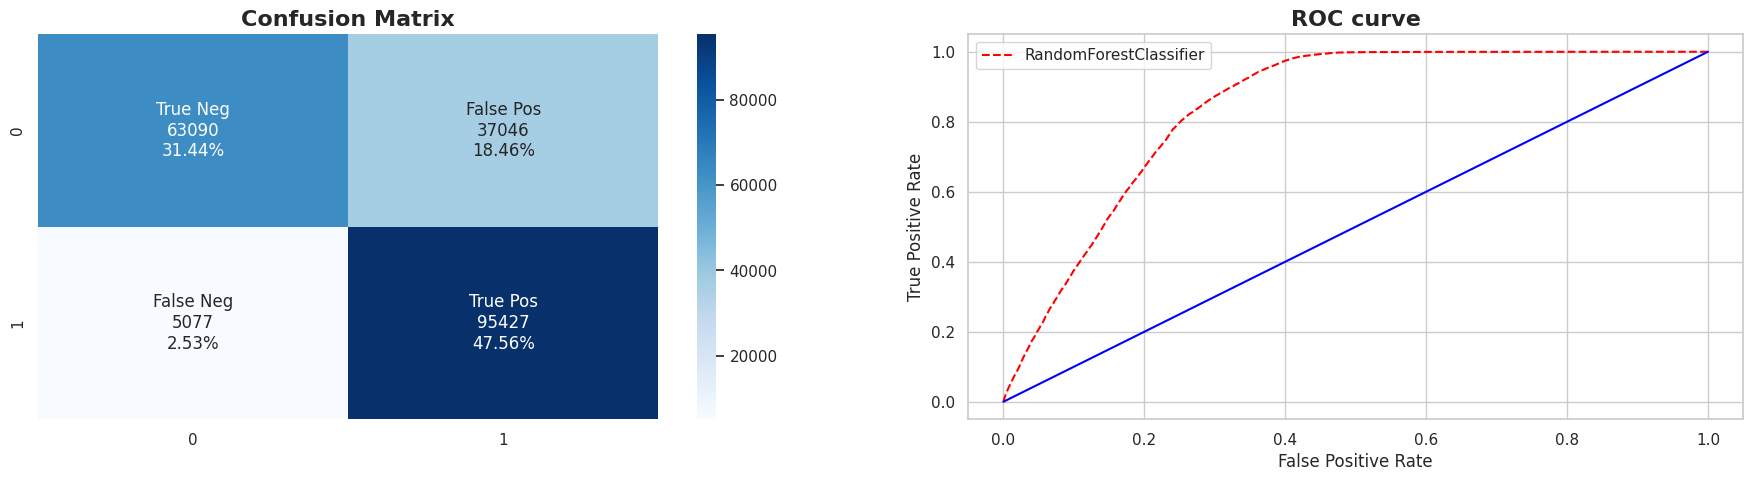

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_random_forest = {'n_estimators': [100, 200, 400],
                            'max_depth': [3, 5, 7],
                            'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)

### 4.4.6 XGBoost

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.800543   0.824354  0.800295  0.796723       0.856725   0.41576


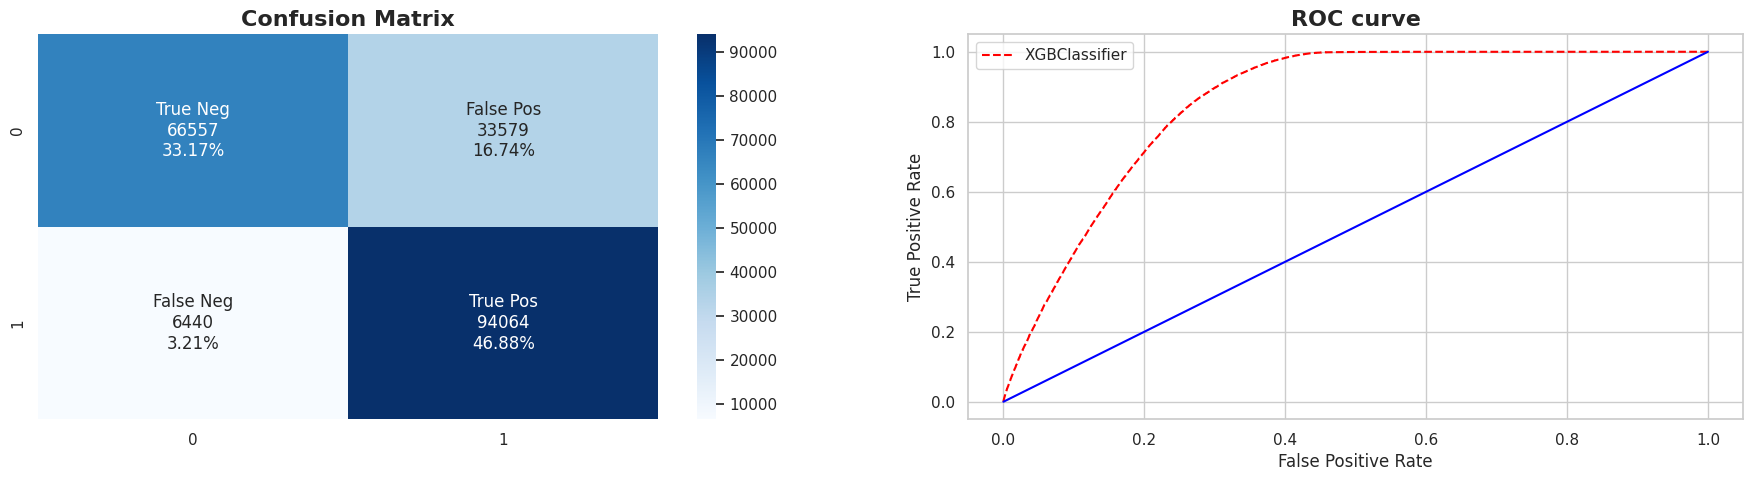

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=23407. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for XGBClassifier : 0.7695223260643821 
---
Best Parameters for XGBClassifier : {'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
--------------------------------------------------
Elapsed Time: 00:00:11

Evaluation of XGBClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.785676    0.83442  0.785325  0.777429       0.835432  0.455588


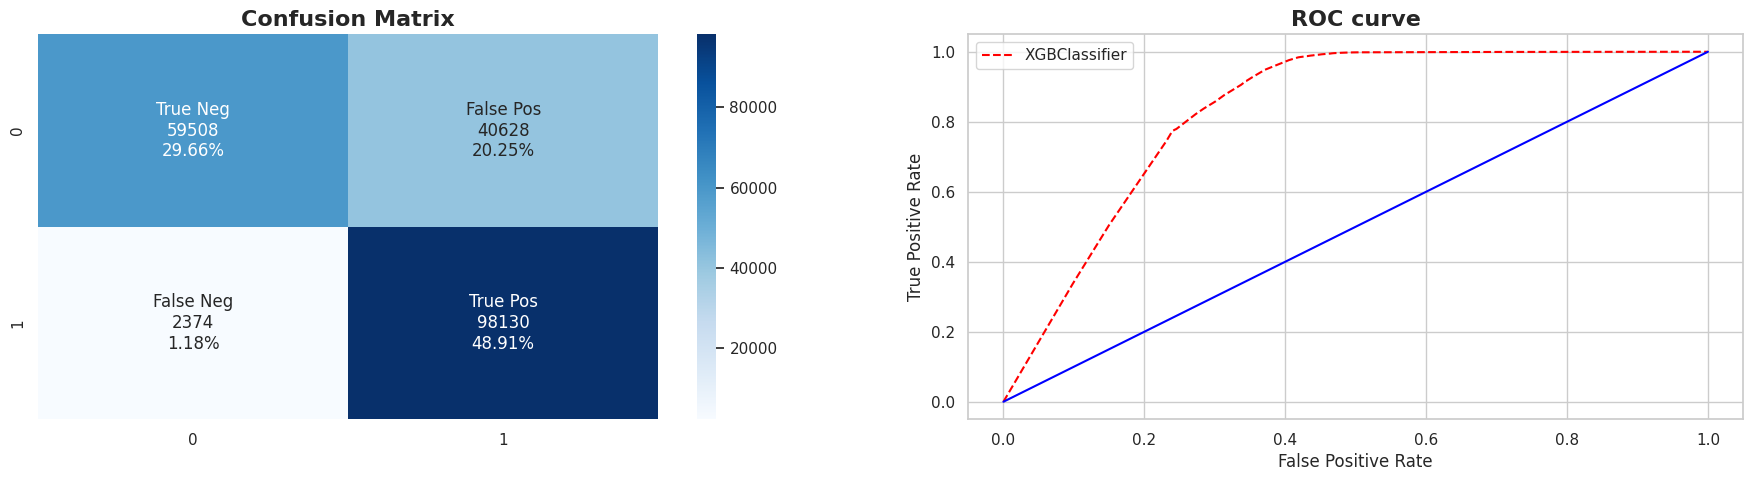

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_xgb = {'n_estimators': [100, 200, 400],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.3],
                  'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, xgb.XGBClassifier(), parameters_xgb, Tuning_Method, False)

### 4.4.7 Voting Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------

Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.922971   0.931547  0.922843  0.922571       0.978952  0.235333


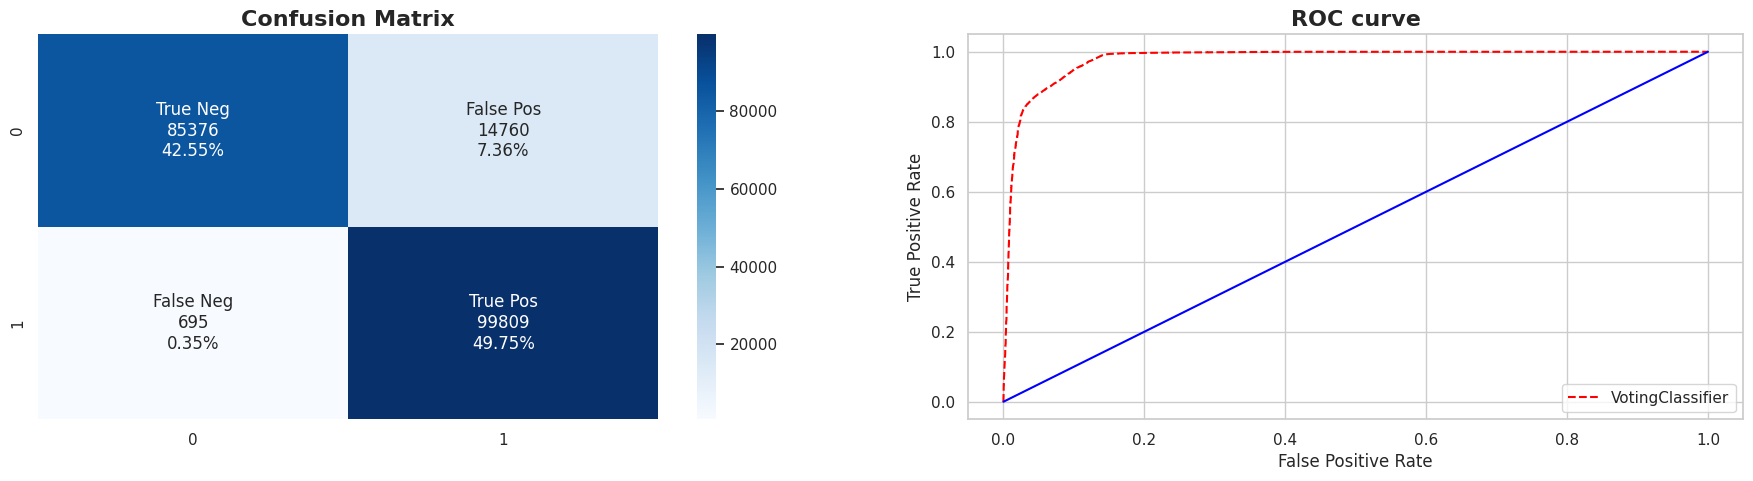

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=23407. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.7006403599861544 
---
Best Parameters for VotingClassifier : {'lr__C': 0.1, 'dt__max_depth': 10, 'bagging__n_estimators': 50}
--------------------------------------------------
Elapsed Time: 00:01:38

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.847772   0.876328  0.84752  0.844762       0.964799  0.319336


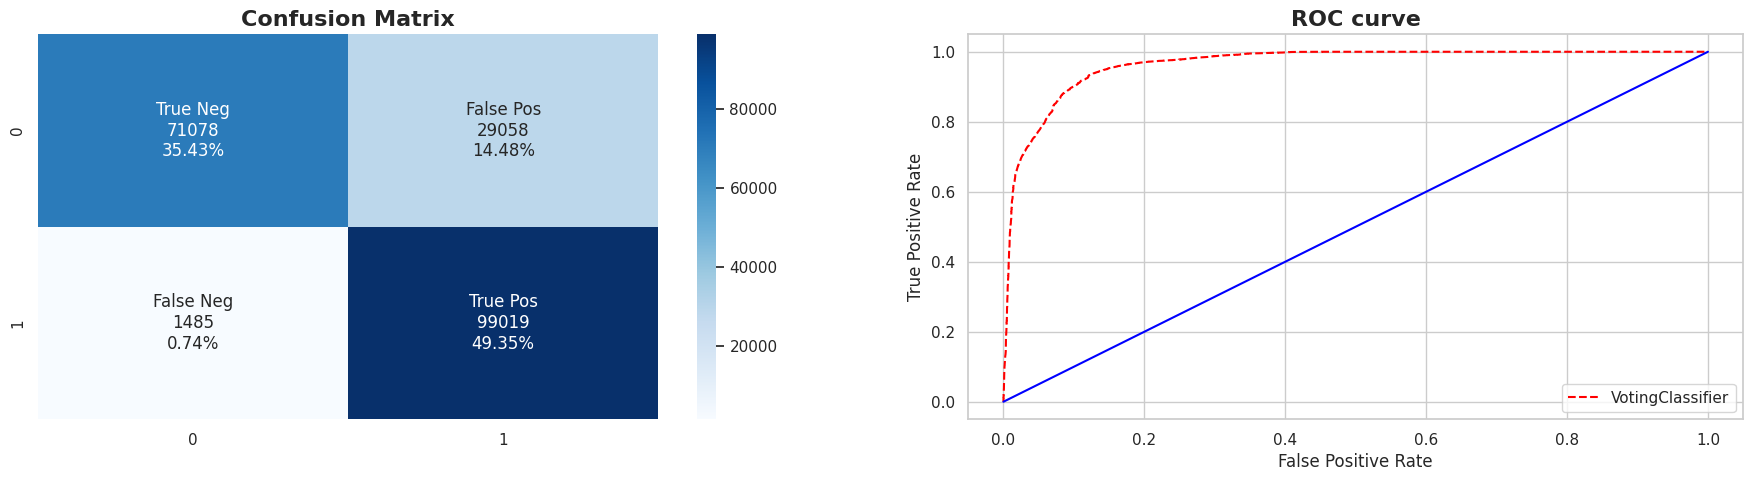

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)

## 4.3 RATIO 80:20

### 4.1.1 Upload Data

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=5, n_iter=50, n_jobs=-1)
    elif tuning_model == 'Grid_Search_CV':
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

### 4.4.2 Decision Tree

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------

Evaluation of DecisionTreeClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.929231    0.93579  0.929136  0.928953       0.940165   1.89464


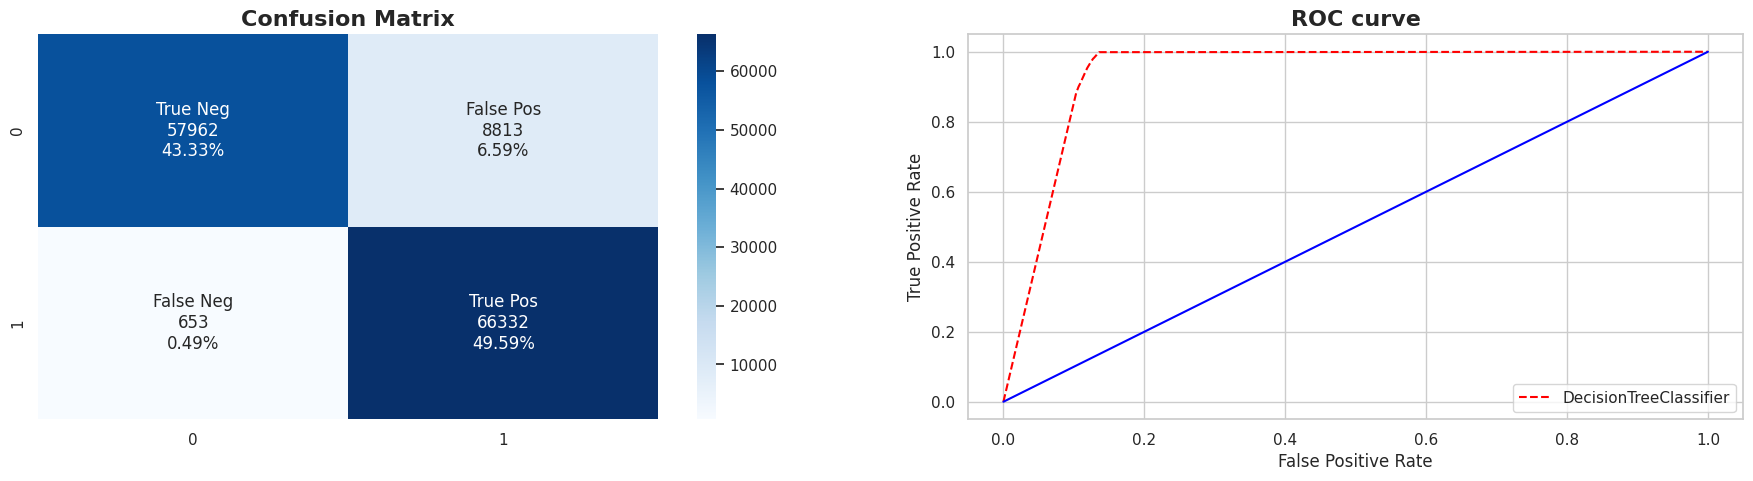

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3200 is smaller than n_iter=26751. Running 3200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


**************************************************
Best Score for DecisionTreeClassifier : 0.7812887496498245 
---
Best Parameters for DecisionTreeClassifier : {'splitter': 'random', 'random_state': 42, 'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 3, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 7}
--------------------------------------------------
Elapsed Time: 00:02:02

Evaluation of DecisionTreeClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.787889    0.81258  0.787668  0.783527       0.827014  0.442701


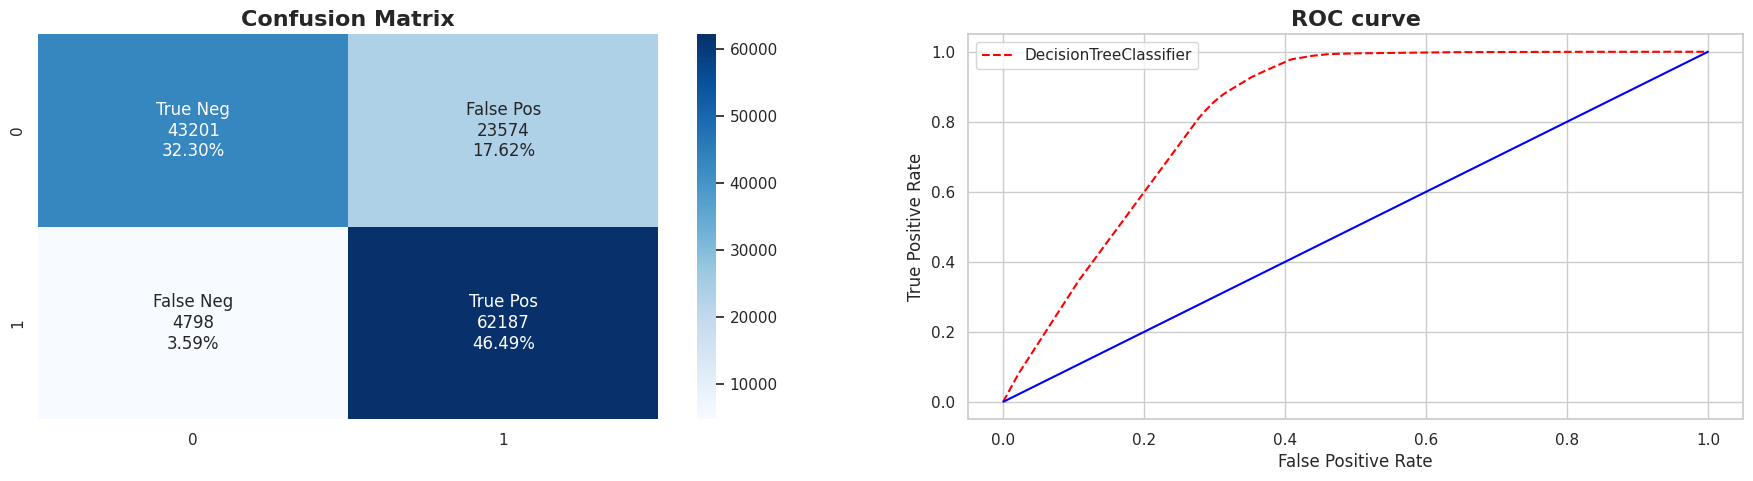

In [ ]:

Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_decision_tree = {"splitter":["best","random"],
            "max_depth" : [None,5,7,9],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0, 0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,40,50,60],
           'random_state':[42]}
ml_algorithm_implementation(train, DecisionTreeClassifier(), parameters_decision_tree, Tuning_Method, False)

### 4.4.3 Logistic Regression

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
LogisticRegression
--------------------------------------------------

Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0         0.78608   0.834299  0.785781  0.777956       0.832577  0.440536


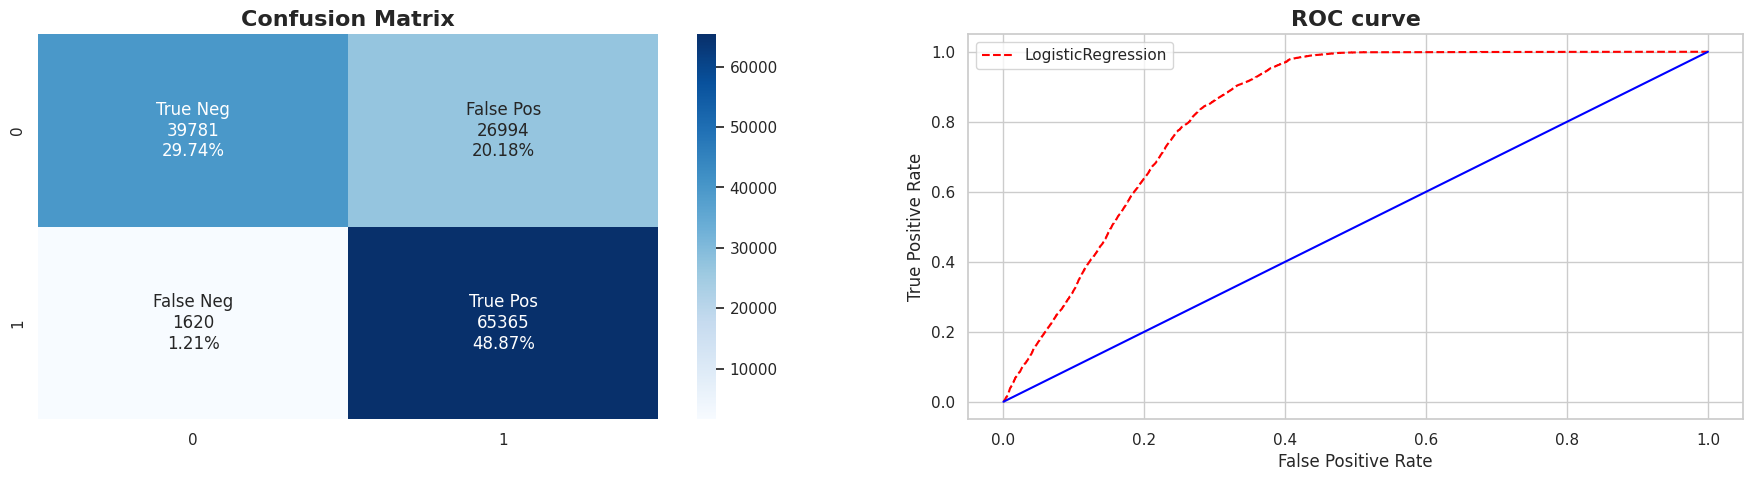

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=26751. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for LogisticRegression : 0.782589131187262 
---
Best Parameters for LogisticRegression : {'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'C': 1.0}
--------------------------------------------------
Elapsed Time: 00:00:05

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0         0.78608   0.834299  0.785781  0.777956       0.832577  0.440536


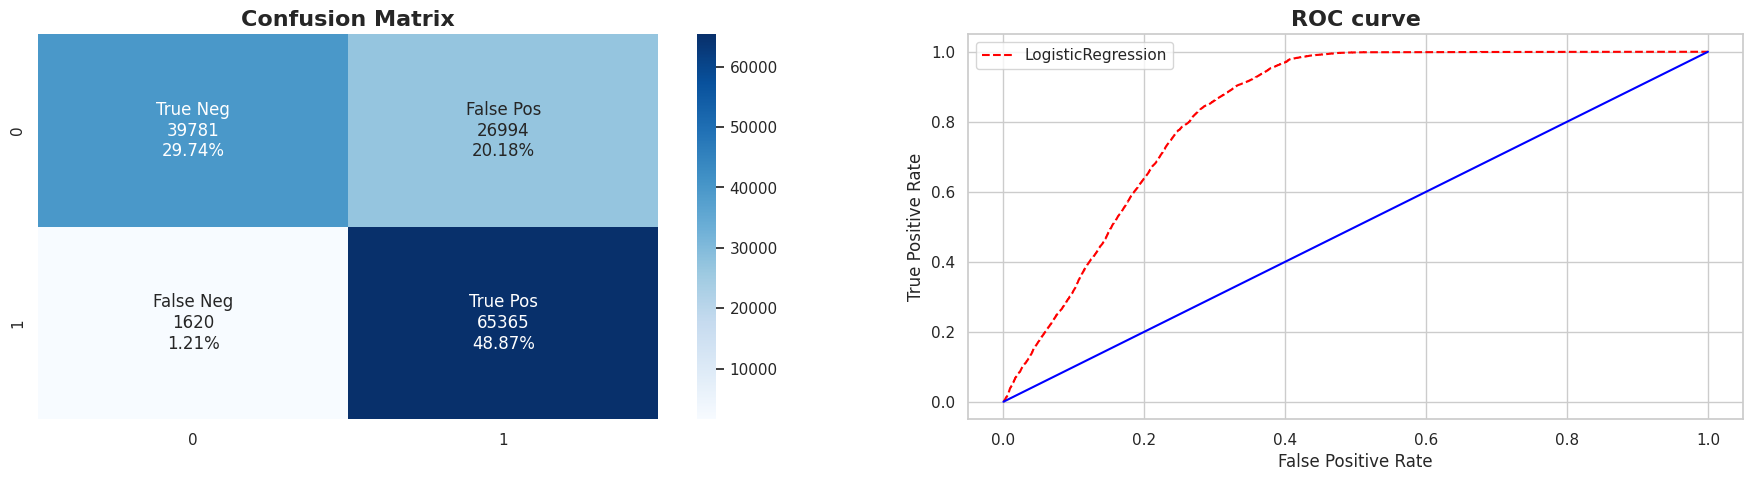

In [ ]:
# Set the tuning method
Tuning_Method = 'Halving_Randomized_Search_CV'

# Define the parameters for the logistic regression model
parameters_logistic = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                        'penalty' : ['l2'],
                        'C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
                       'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)


### 4.4.4 Bagging Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
BaggingClassifier
--------------------------------------------------

Evaluation of BaggingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.932386    0.93856  0.932294  0.932138       0.983176  0.419507


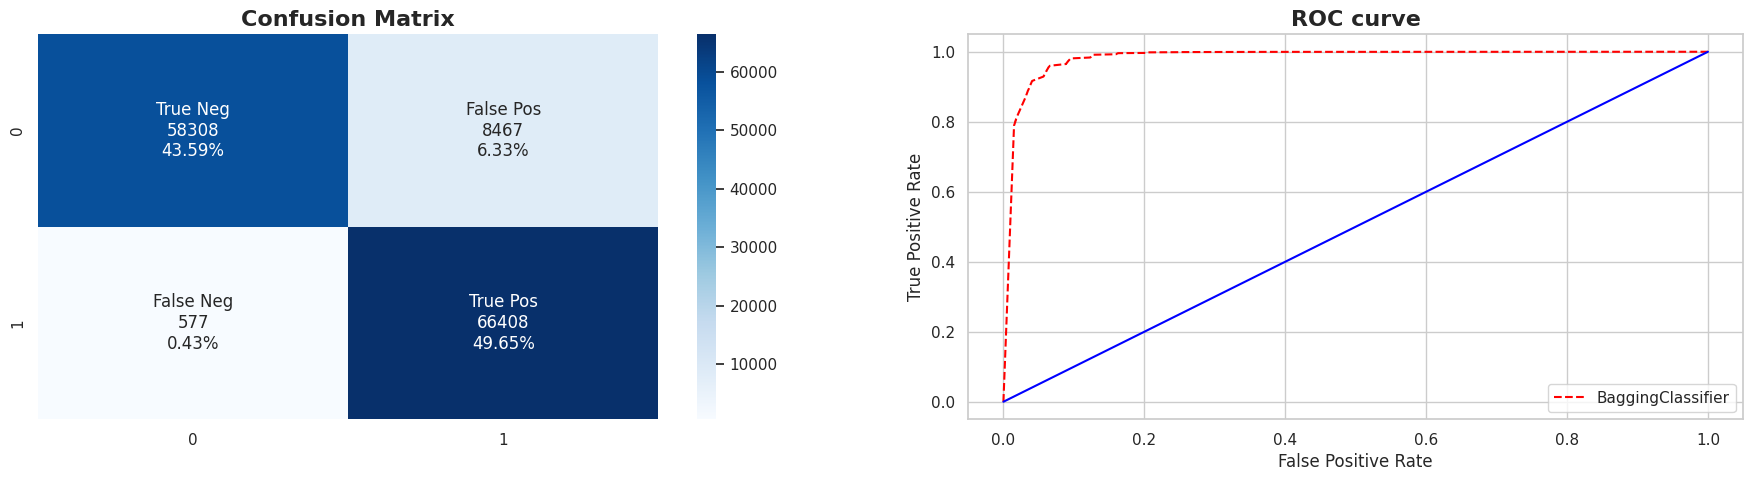

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=26751. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for BaggingClassifier : 0.7272727272727273 
---
Best Parameters for BaggingClassifier : {'random_state': 42, 'n_estimators': 400}
--------------------------------------------------
Elapsed Time: 00:11:40

Evaluation of BaggingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.928439   0.935787  0.928337  0.928124       0.988514  0.228313


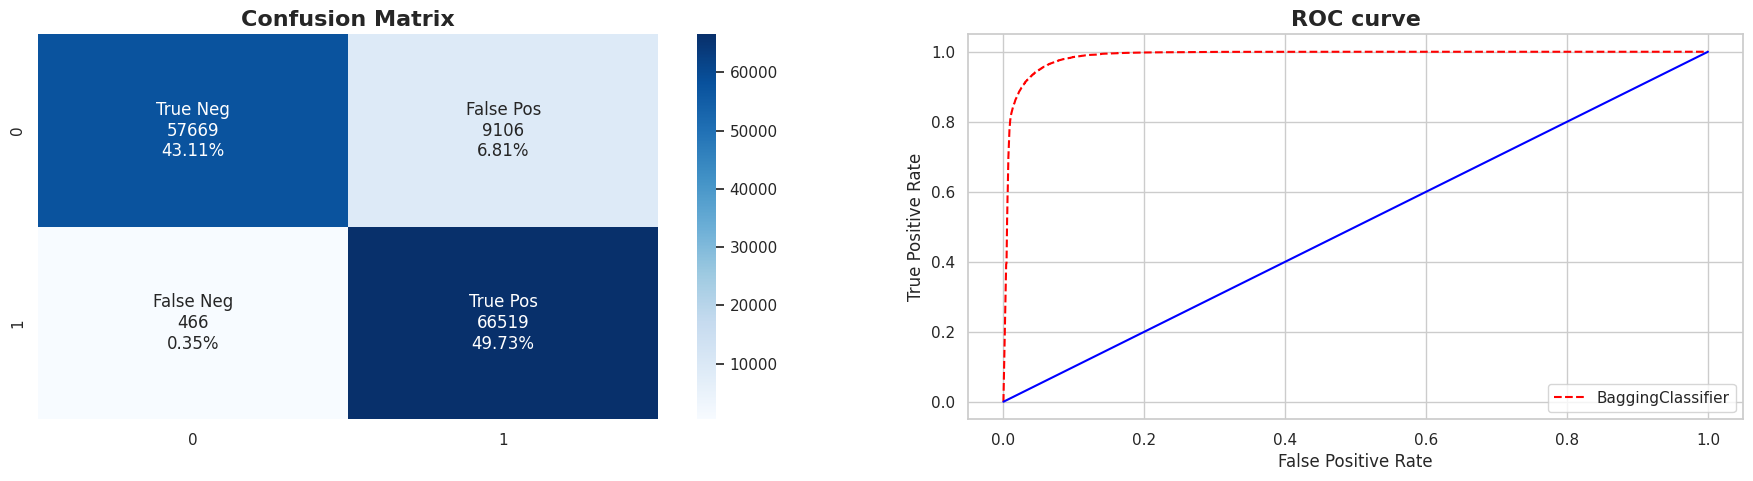

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

parameters_bagging = {'n_estimators':[10, 100, 200, 400],
                      'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, BaggingClassifier(), parameters_bagging, Tuning_Method, False)


### 4.4.5 Random Forest

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.926518   0.934273  0.926413  0.926176       0.985979  0.280711


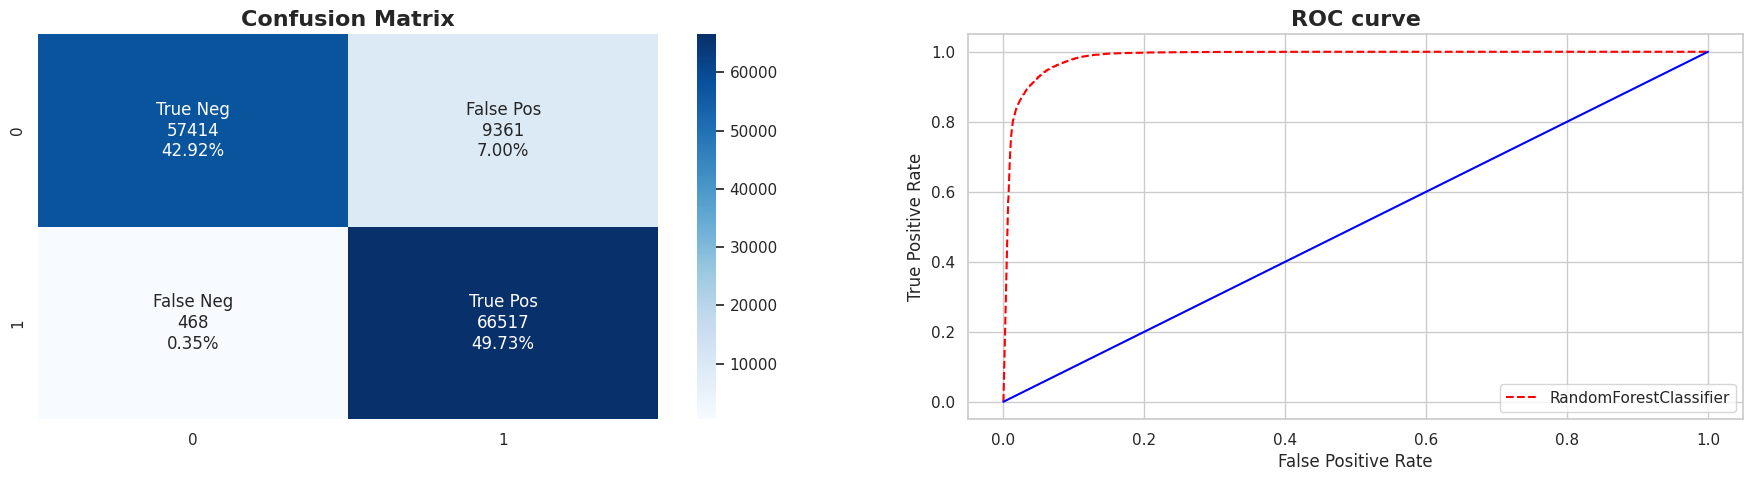

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=26751. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for RandomForestClassifier : 0.8087301587301587 
---
Best Parameters for RandomForestClassifier : {'random_state': 42, 'n_estimators': 400, 'max_depth': 3}
--------------------------------------------------
Elapsed Time: 00:01:22

Evaluation of RandomForestClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.789451    0.82262  0.789199  0.783797       0.836209  0.453072


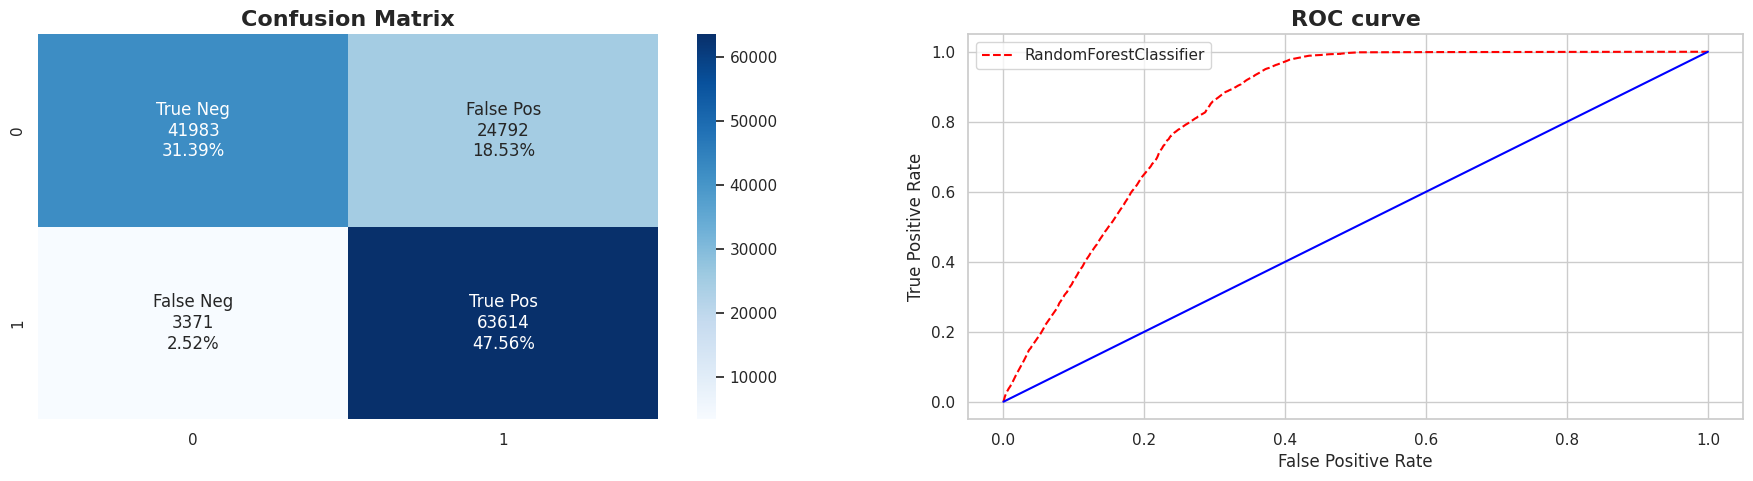

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_random_forest = {'n_estimators': [100, 200, 400],
                            'max_depth': [3, 5, 7],
                            'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)

### 4.4.6 XGBoost

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.801196   0.825131  0.800983  0.797391       0.856838  0.414892


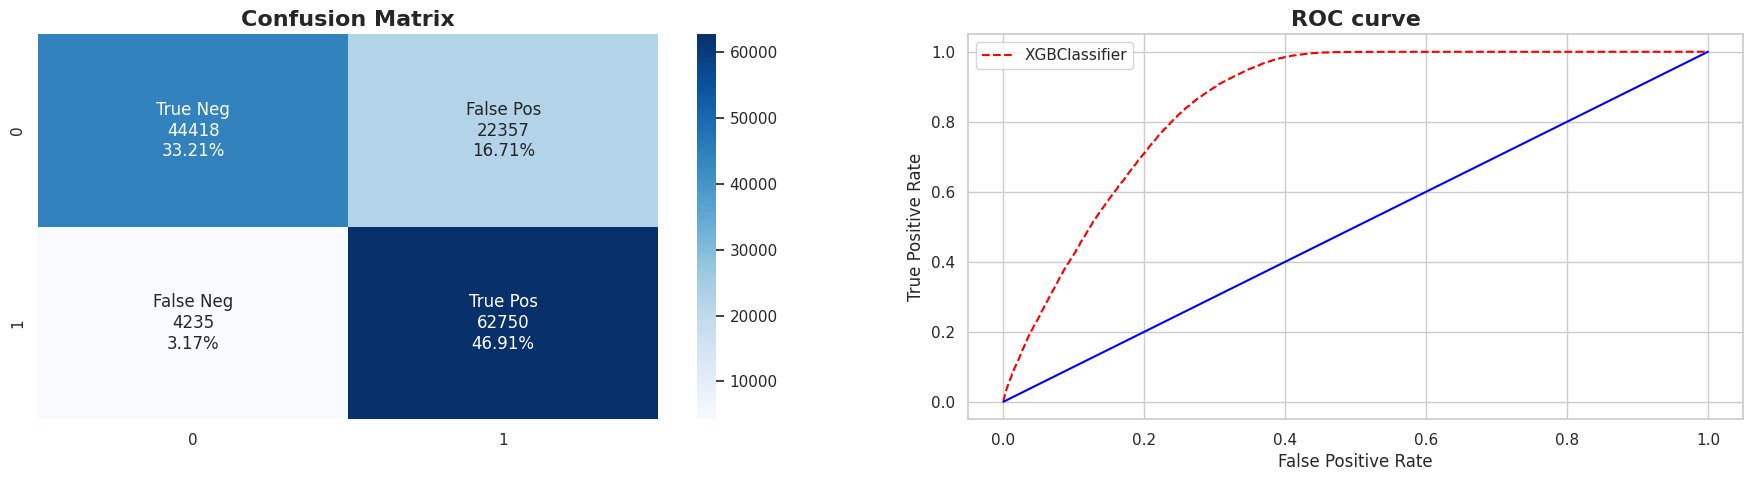

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=26751. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for XGBClassifier : 0.7510730356524749 
---
Best Parameters for XGBClassifier : {'random_state': 42, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}
--------------------------------------------------
Elapsed Time: 00:00:18

Evaluation of XGBClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.814115   0.837845  0.813907  0.810722        0.87173  0.399185


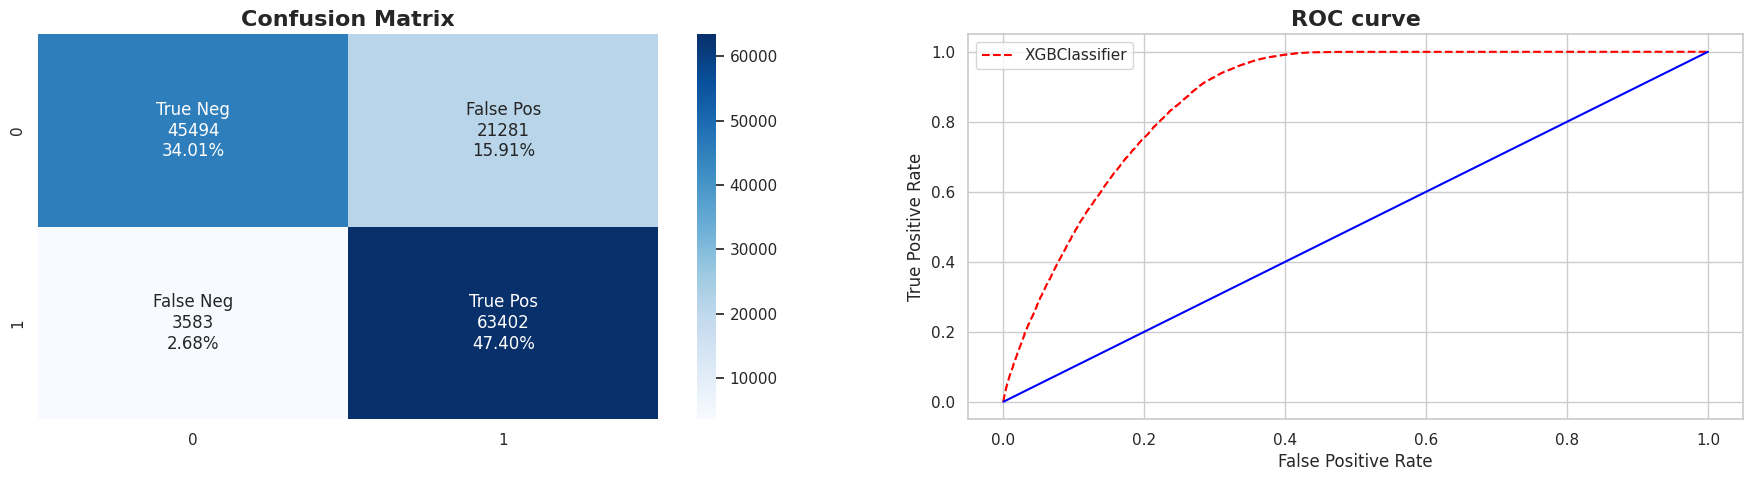

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_xgb = {'n_estimators': [100, 200, 400],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.3],
                  'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, xgb.XGBClassifier(), parameters_xgb, Tuning_Method, False)

### 4.4.7 Voting Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------

Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.929381   0.937162  0.929277  0.929053       0.982121  0.224597


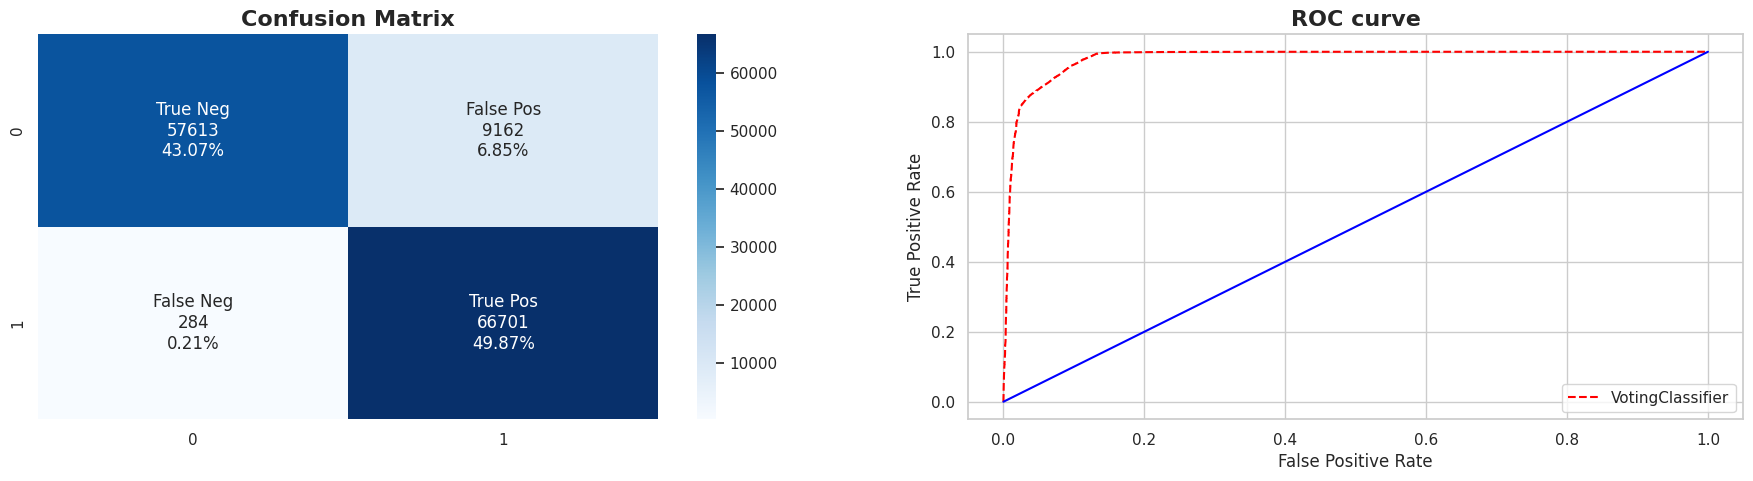

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=26751. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.724852890273451 
---
Best Parameters for VotingClassifier : {'lr__C': 10.0, 'dt__max_depth': 30, 'bagging__n_estimators': 100}
--------------------------------------------------
Elapsed Time: 00:03:28

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.893167   0.910759  0.893005  0.891982       0.975299  0.259494


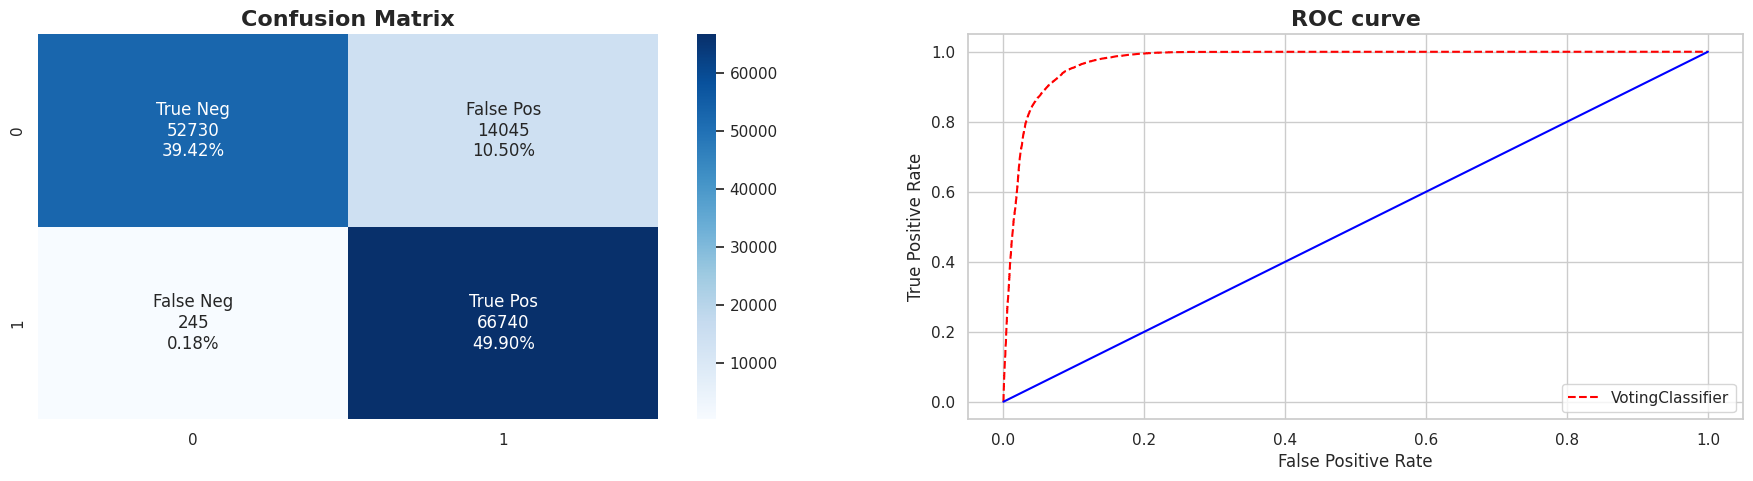

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)

## 4.4 RATIO 85:15

### 4.1.1 Upload Data

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=5, n_iter=50, n_jobs=-1)
    elif tuning_model == 'Grid_Search_CV':
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.15, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

### 4.4.2 Decision Tree

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------

Evaluation of DecisionTreeClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.932466   0.938909  0.932262  0.932195       0.942521   1.79964


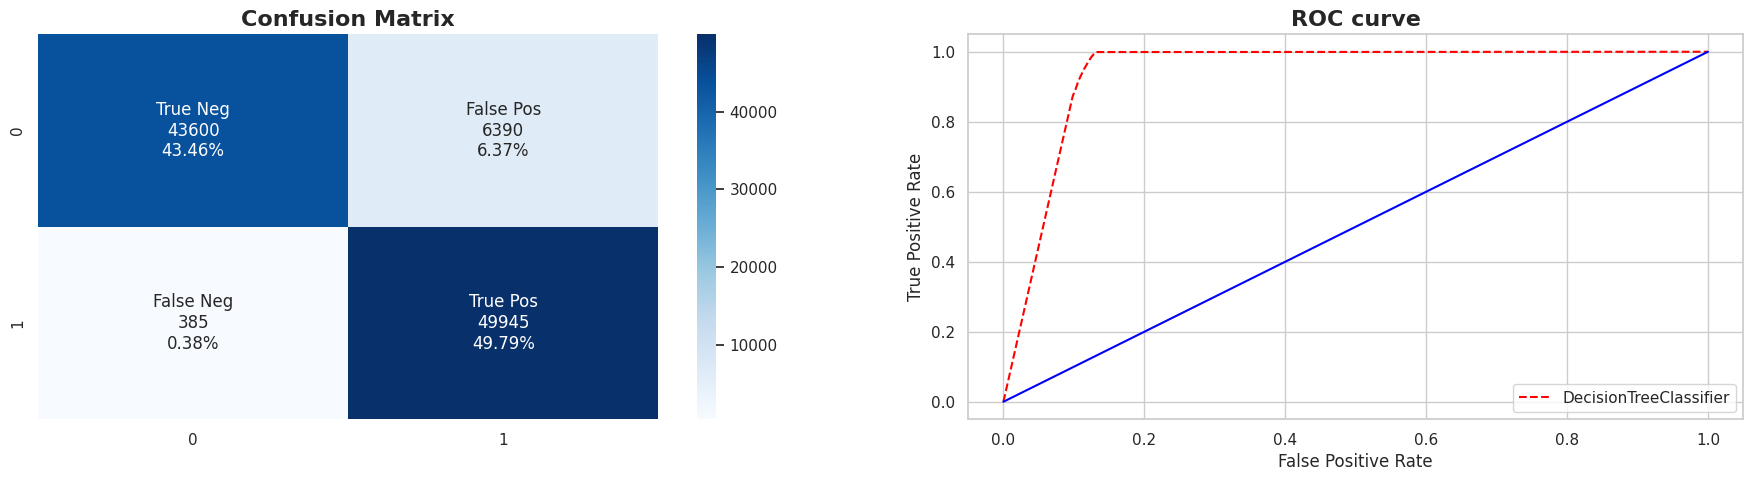

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3200 is smaller than n_iter=28423. Running 3200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:

Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_decision_tree = {"splitter":["best","random"],
            "max_depth" : [None,5,7,9],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0, 0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,40,50,60],
           'random_state':[42]}
ml_algorithm_implementation(train, DecisionTreeClassifier(), parameters_decision_tree, Tuning_Method, False)

### 4.4.3 Logistic Regression

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
LogisticRegression
--------------------------------------------------

Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.786543    0.83404  0.785903  0.778416       0.832548  0.440343


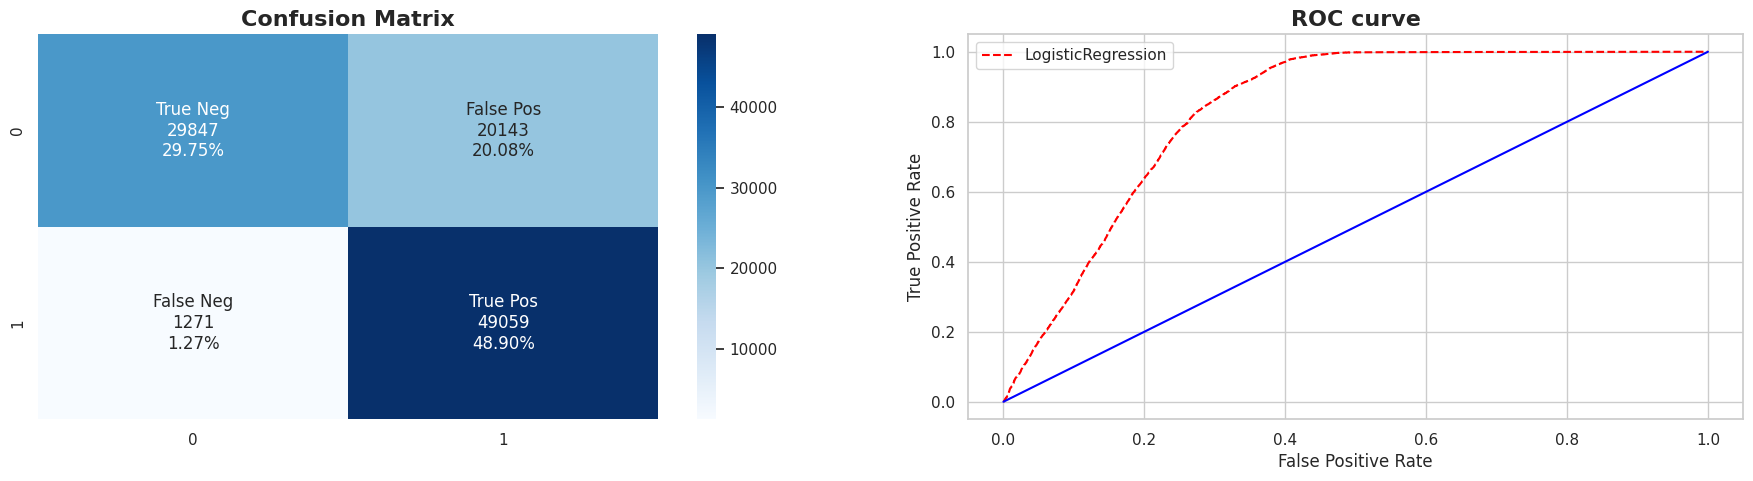

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=28423. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for LogisticRegression : 0.7658532364139841 
---
Best Parameters for LogisticRegression : {'solver': 'saga', 'random_state': 42, 'penalty': 'l2', 'C': 1.0}
--------------------------------------------------
Elapsed Time: 00:00:06

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.786543    0.83404  0.785903  0.778416       0.832548  0.440343


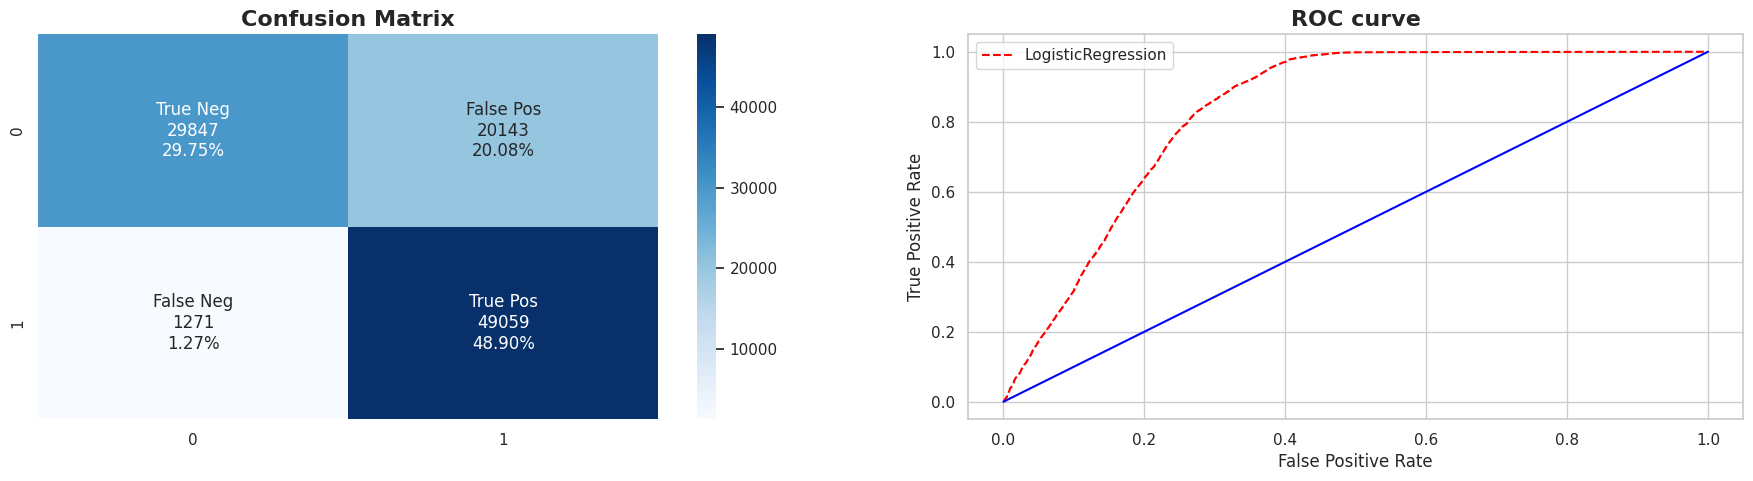

In [ ]:
# Set the tuning method
Tuning_Method = 'Halving_Randomized_Search_CV'

# Define the parameters for the logistic regression model
parameters_logistic = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                        'penalty' : ['l2'],
                        'C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
                       'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)


### 4.4.4 Bagging Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
BaggingClassifier
--------------------------------------------------

Evaluation of BaggingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.935586   0.941495  0.935392  0.935349       0.984525  0.397309


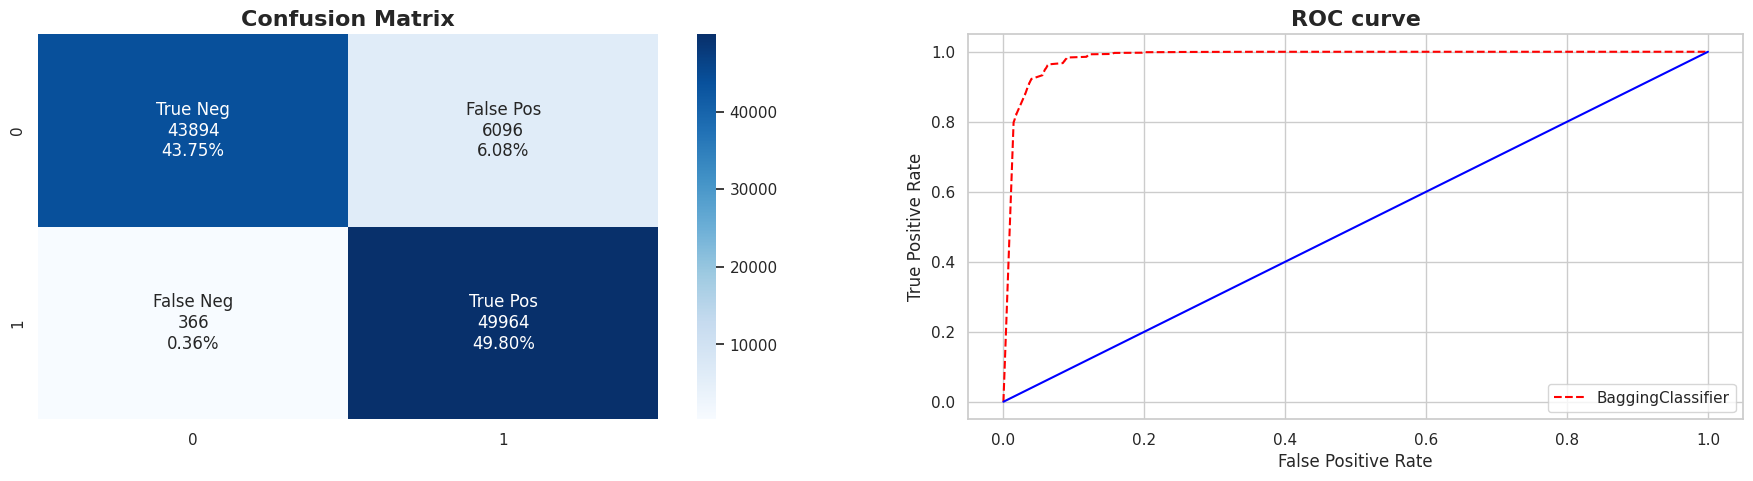

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=28423. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for BaggingClassifier : 0.6712121212121211 
---
Best Parameters for BaggingClassifier : {'random_state': 42, 'n_estimators': 200}
--------------------------------------------------
Elapsed Time: 00:06:17

Evaluation of BaggingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.932626   0.939429  0.932416  0.932341       0.989413  0.239051


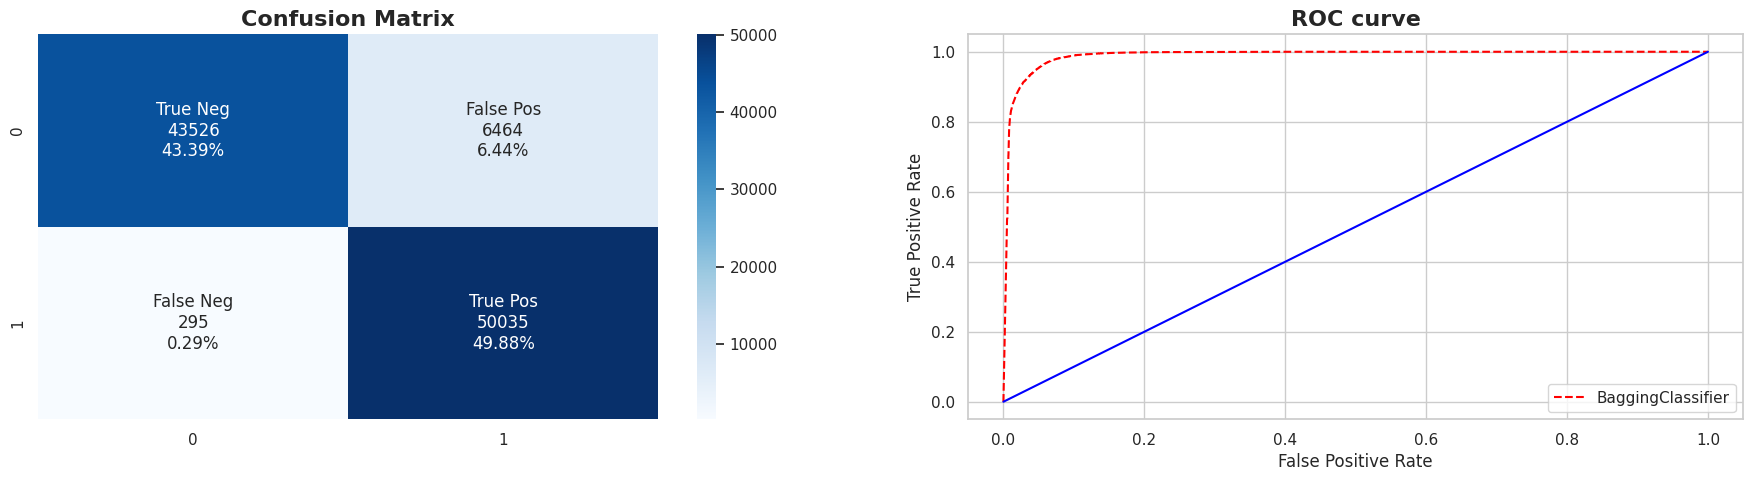

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

parameters_bagging = {'n_estimators':[10, 100, 200, 400],
                      'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, BaggingClassifier(), parameters_bagging, Tuning_Method, False)


### 4.4.5 Random Forest

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.931031   0.938094  0.930817  0.930728       0.987304  0.273322


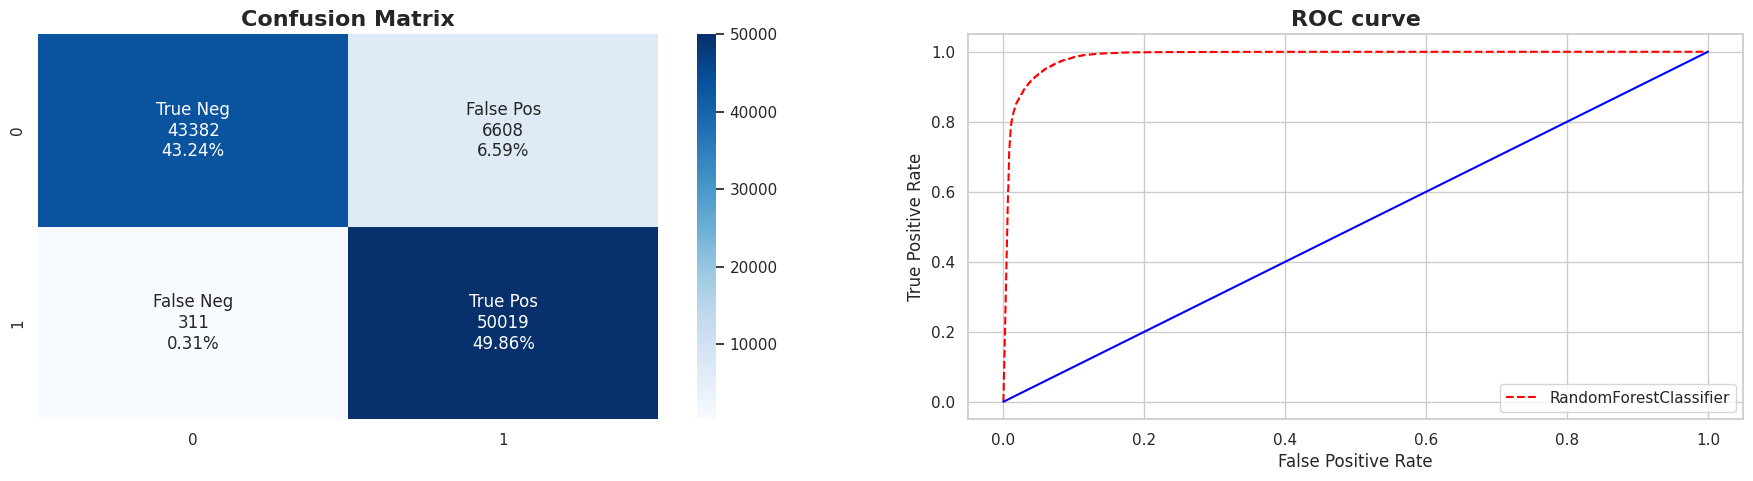

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=47373. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for RandomForestClassifier : 0.7849206349206349 
---
Best Parameters for RandomForestClassifier : {'random_state': 42, 'n_estimators': 200, 'max_depth': 5}
--------------------------------------------------
Elapsed Time: 00:00:58

Evaluation of RandomForestClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.789962   0.822183  0.789425  0.784363       0.839683  0.437273


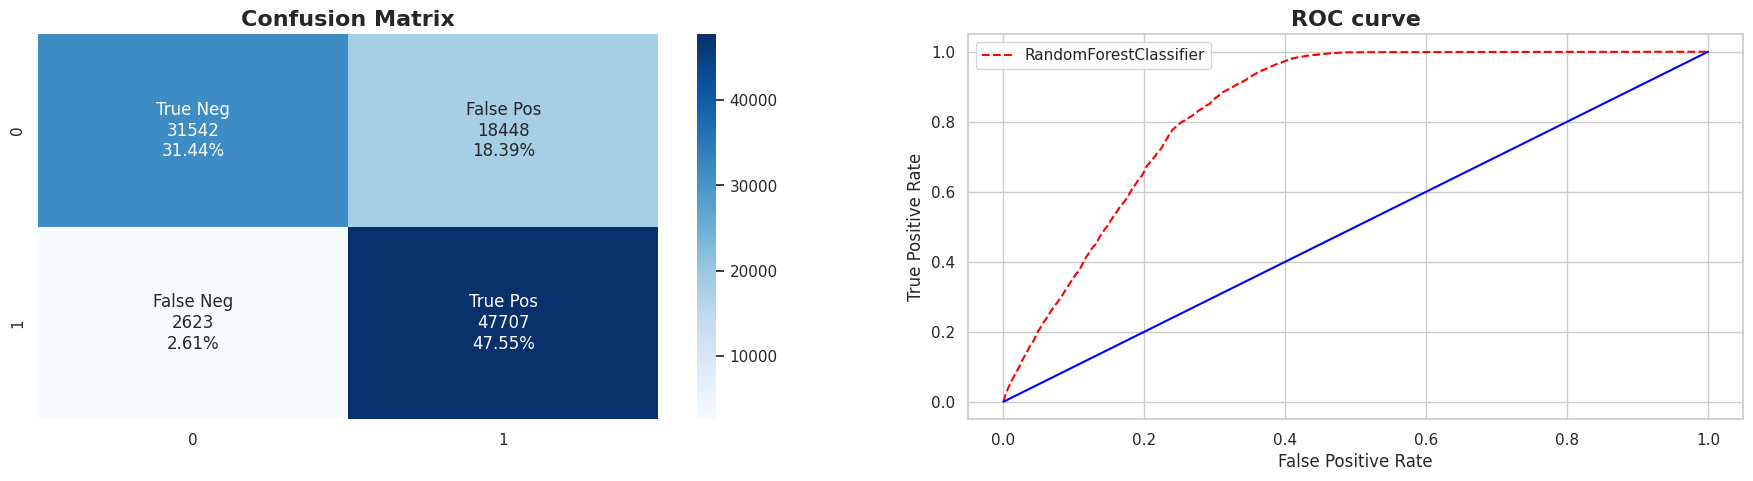

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_random_forest = {'n_estimators': [100, 200, 400],
                            'max_depth': [3, 5, 7],
                            'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)

### 4.4.6 XGBoost

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0         0.80306   0.827454  0.802597  0.799154        0.85788  0.413464


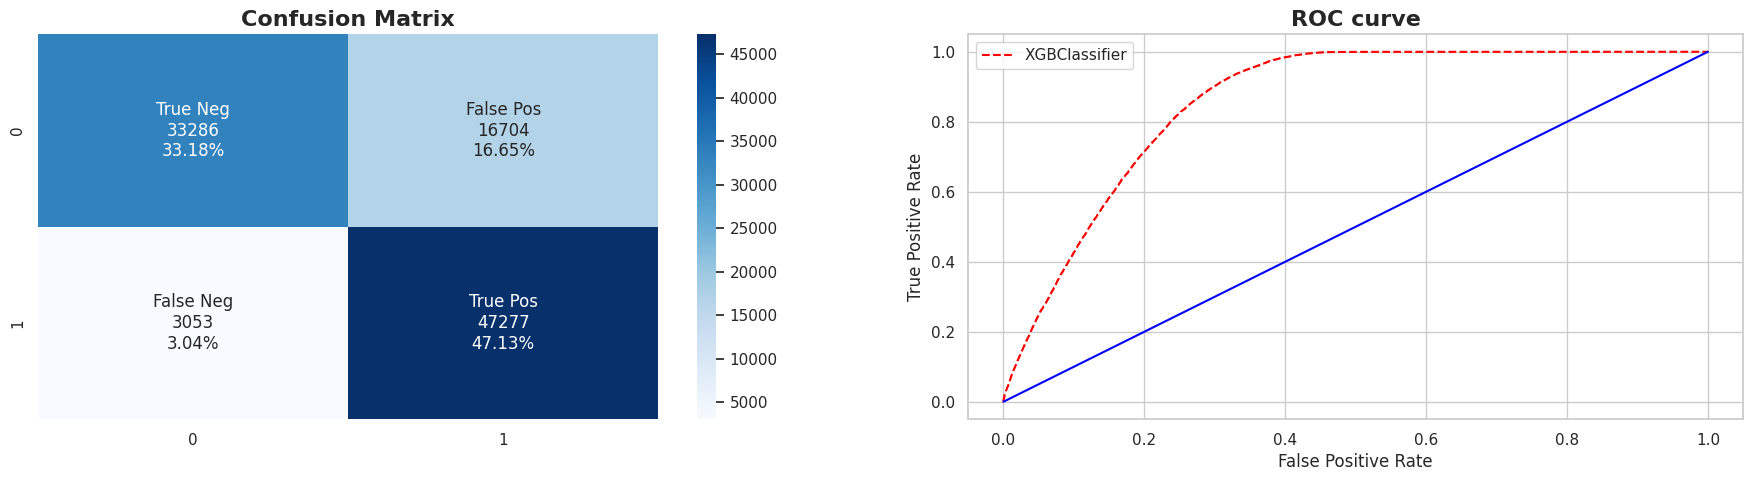

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=28423. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for XGBClassifier : 0.7900138456213222 
---
Best Parameters for XGBClassifier : {'random_state': 42, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
--------------------------------------------------
Elapsed Time: 00:00:10

Evaluation of XGBClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.787091   0.835861  0.786445   0.77881       0.831677  0.501469


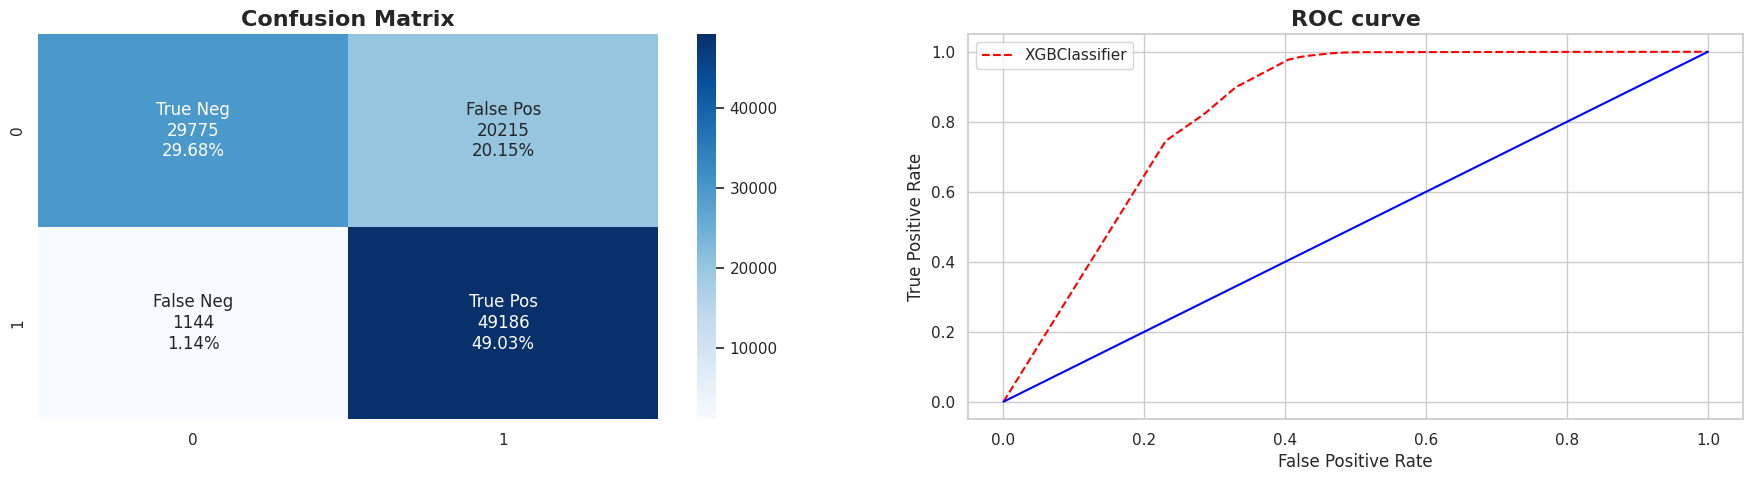

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_xgb = {'n_estimators': [100, 200, 400],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.3],
                  'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, xgb.XGBClassifier(), parameters_xgb, Tuning_Method, False)

### 4.4.7 Voting Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------

Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.932317   0.939753  0.932098  0.932005       0.983236  0.220077


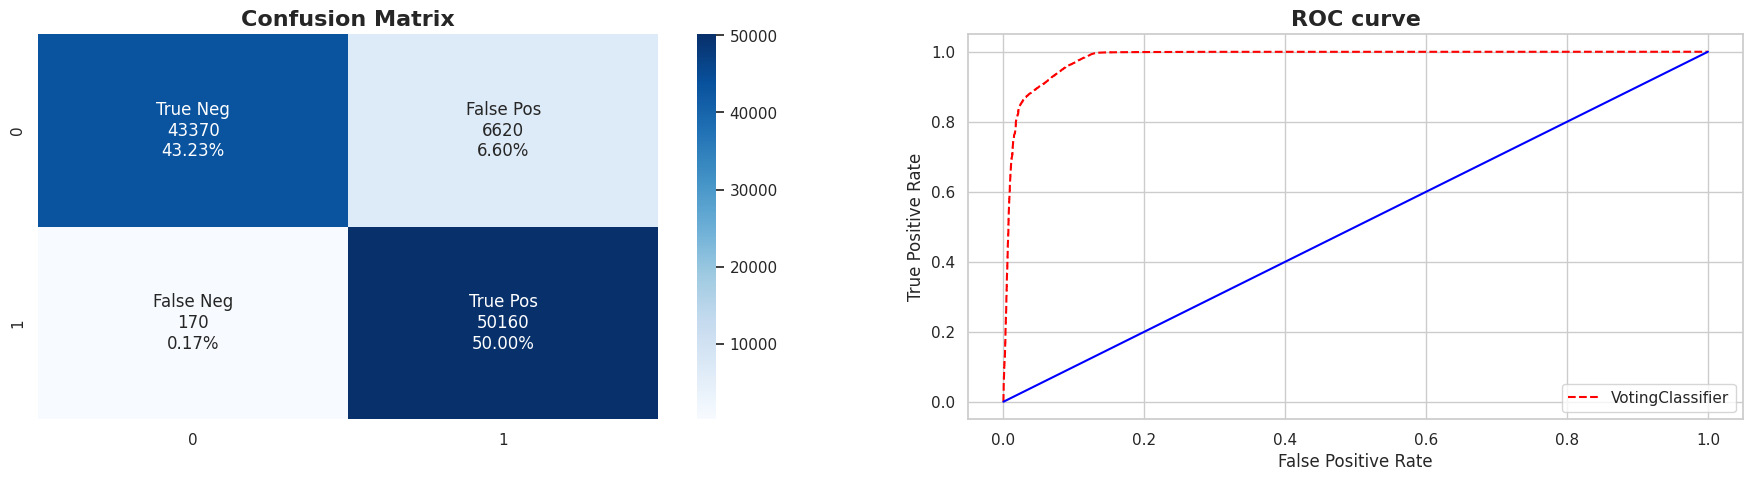

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=28423. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.7360678435444791 
---
Best Parameters for VotingClassifier : {'lr__C': 10.0, 'dt__max_depth': None, 'bagging__n_estimators': 20}
--------------------------------------------------
Elapsed Time: 00:01:02

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.931818   0.939376  0.931598  0.931499       0.982626  0.220522


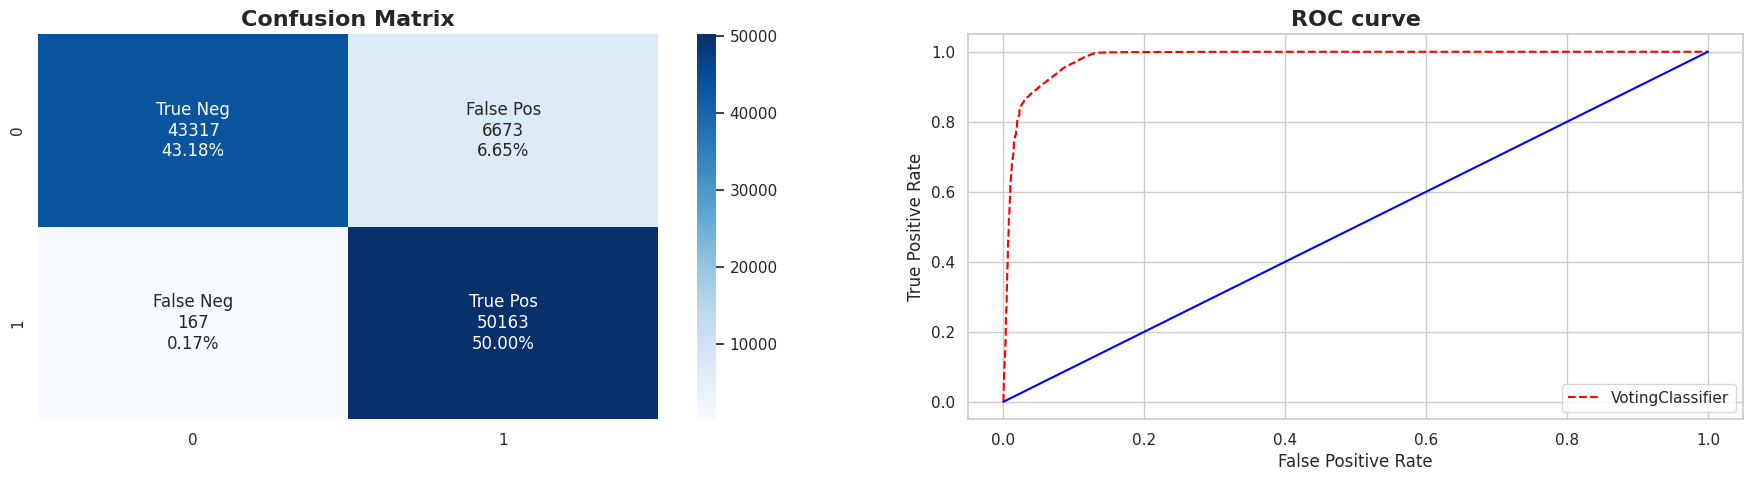

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)

## 4.5 RATIO 90:10

### 4.1.1 Upload Data

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=5, n_iter=50, n_jobs=-1)
    elif tuning_model == 'Grid_Search_CV':
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.1, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

### 4.4.2 Decision Tree

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------

Evaluation of DecisionTreeClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.935033   0.941209  0.934765  0.934776       0.945641  1.702565


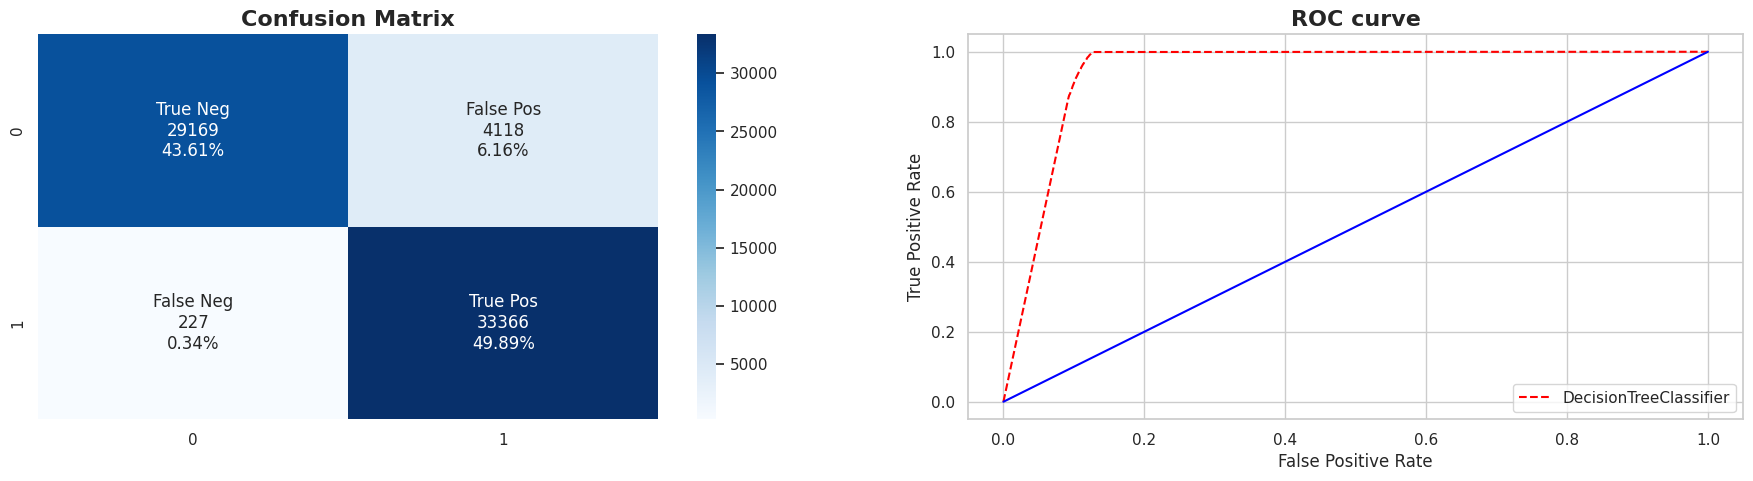

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3200 is smaller than n_iter=30095. Running 3200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:

Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_decision_tree = {"splitter":["best","random"],
            "max_depth" : [None,5,7,9],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0, 0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,40,50,60],
           'random_state':[42]}
ml_algorithm_implementation(train, DecisionTreeClassifier(), parameters_decision_tree, Tuning_Method, False)

### 4.4.3 Logistic Regression

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
LogisticRegression
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.786588   0.834831  0.785718   0.77826       0.831129  0.441219


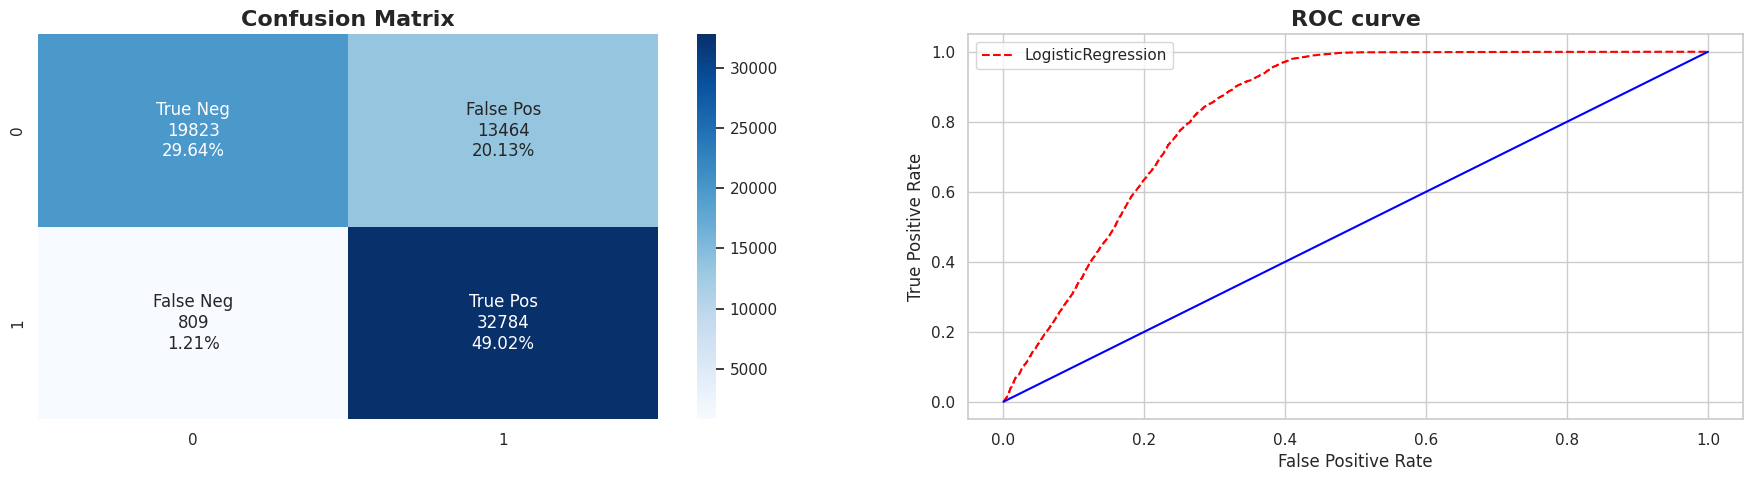

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=30095. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for LogisticRegression : 0.8011422637590861 
---
Best Parameters for LogisticRegression : {'solver': 'newton-cg', 'random_state': 42, 'penalty': 'l2', 'C': 1.0}
--------------------------------------------------
Elapsed Time: 00:00:06

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.786588   0.834831  0.785718   0.77826       0.831254  0.441217


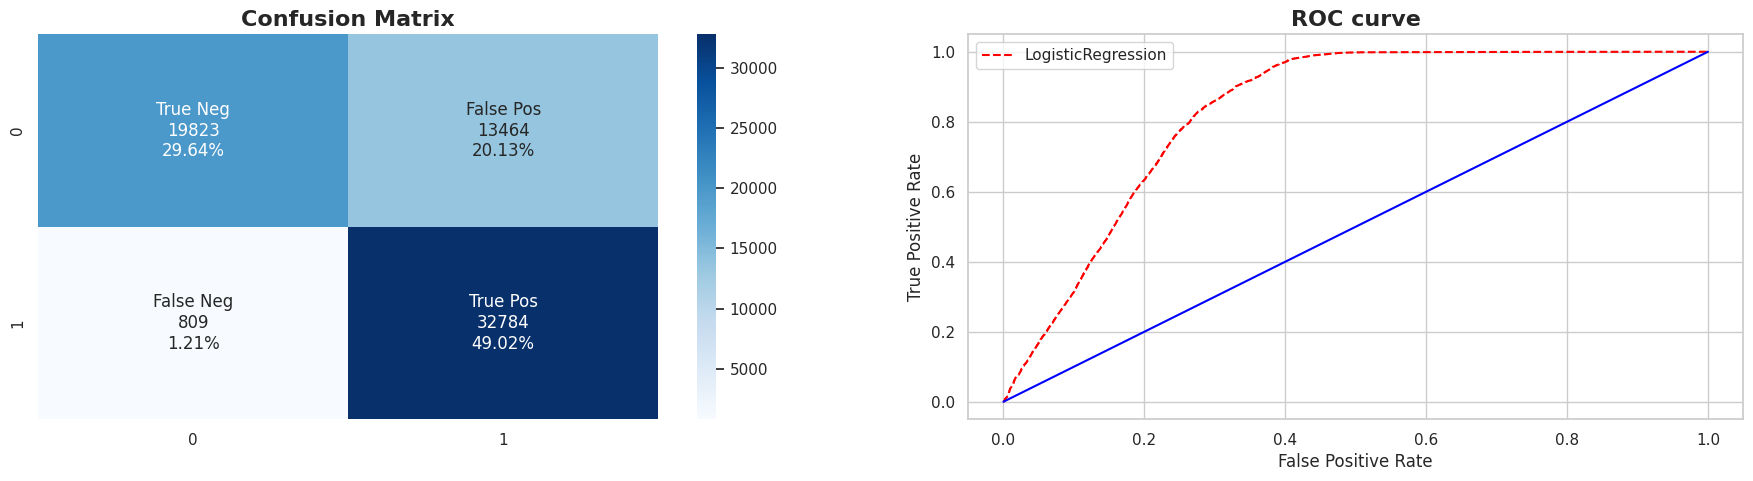

In [ ]:
# Set the tuning method
Tuning_Method = 'Halving_Randomized_Search_CV'

# Define the parameters for the logistic regression model
parameters_logistic = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                        'penalty' : ['l2'],
                        'C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
                       'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)


### 4.4.4 Bagging Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
BaggingClassifier
--------------------------------------------------

Evaluation of BaggingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.938203   0.943756  0.93795  0.937983       0.986046  0.367788


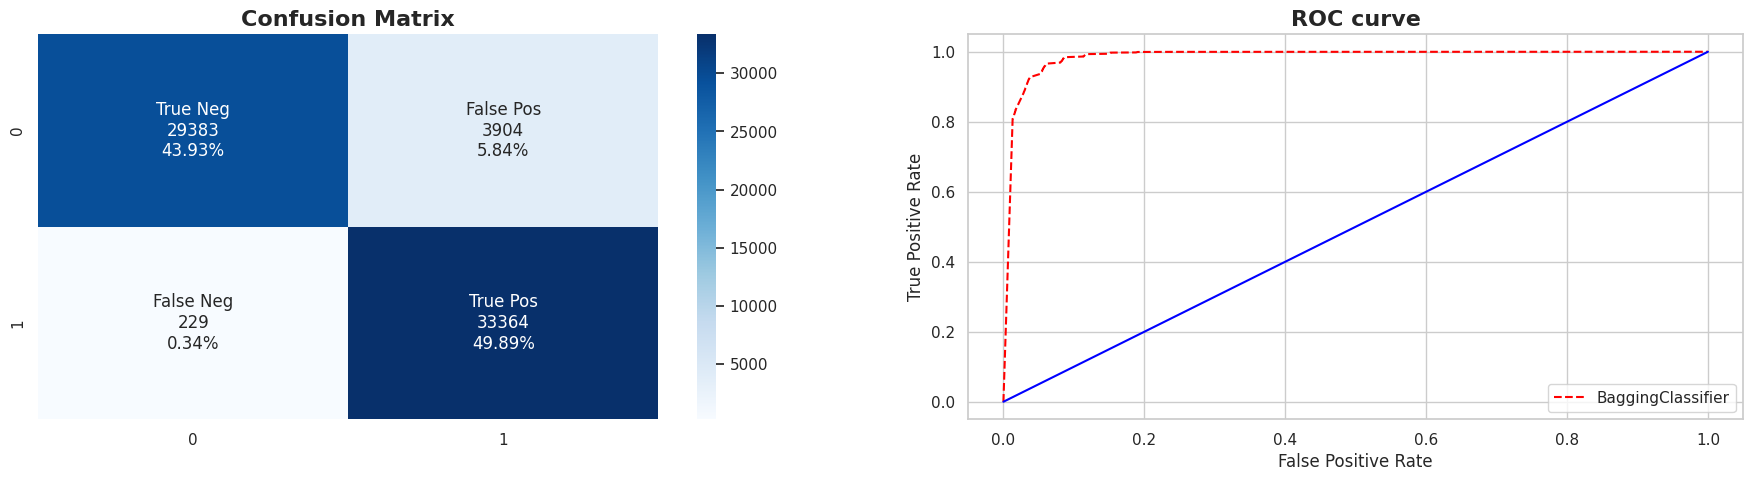

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=30095. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for BaggingClassifier : 0.7939393939393941 
---
Best Parameters for BaggingClassifier : {'random_state': 42, 'n_estimators': 100}
--------------------------------------------------
Elapsed Time: 00:03:21

Evaluation of BaggingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.935781   0.942044  0.935511  0.935524       0.990155  0.243071


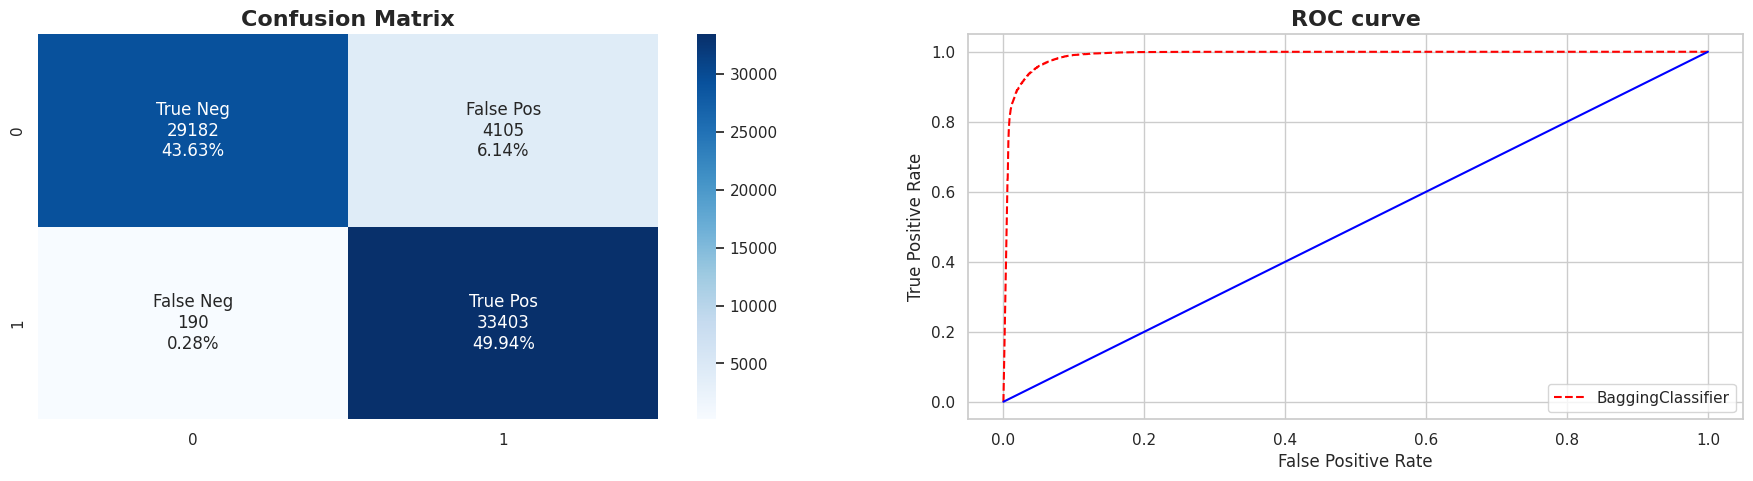

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

parameters_bagging = {'n_estimators':[10, 100, 200, 400],
                      'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, BaggingClassifier(), parameters_bagging, Tuning_Method, False)


### 4.4.5 Random Forest

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.933269   0.939941  0.93299  0.932984       0.988253  0.263206


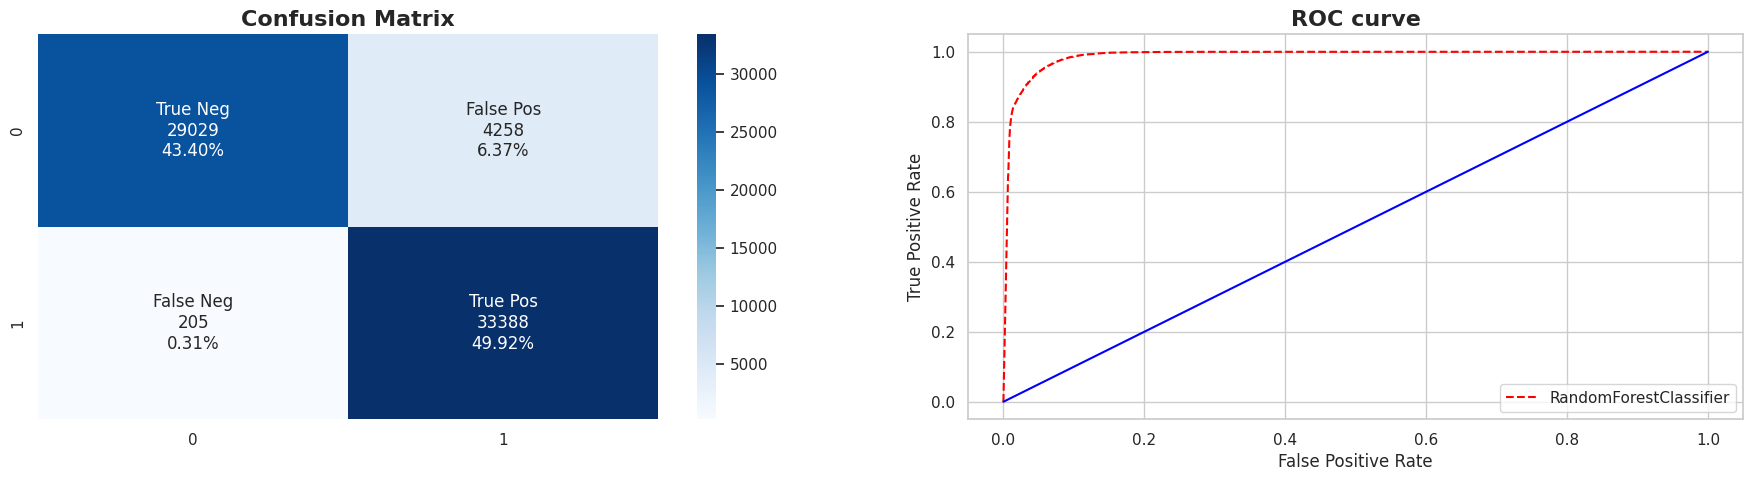

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=30095. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for RandomForestClassifier : 0.8087301587301587 
---
Best Parameters for RandomForestClassifier : {'random_state': 42, 'n_estimators': 100, 'max_depth': 3}
--------------------------------------------------
Elapsed Time: 00:00:34

Evaluation of RandomForestClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.788173   0.824434  0.787406  0.781776       0.835932  0.454883


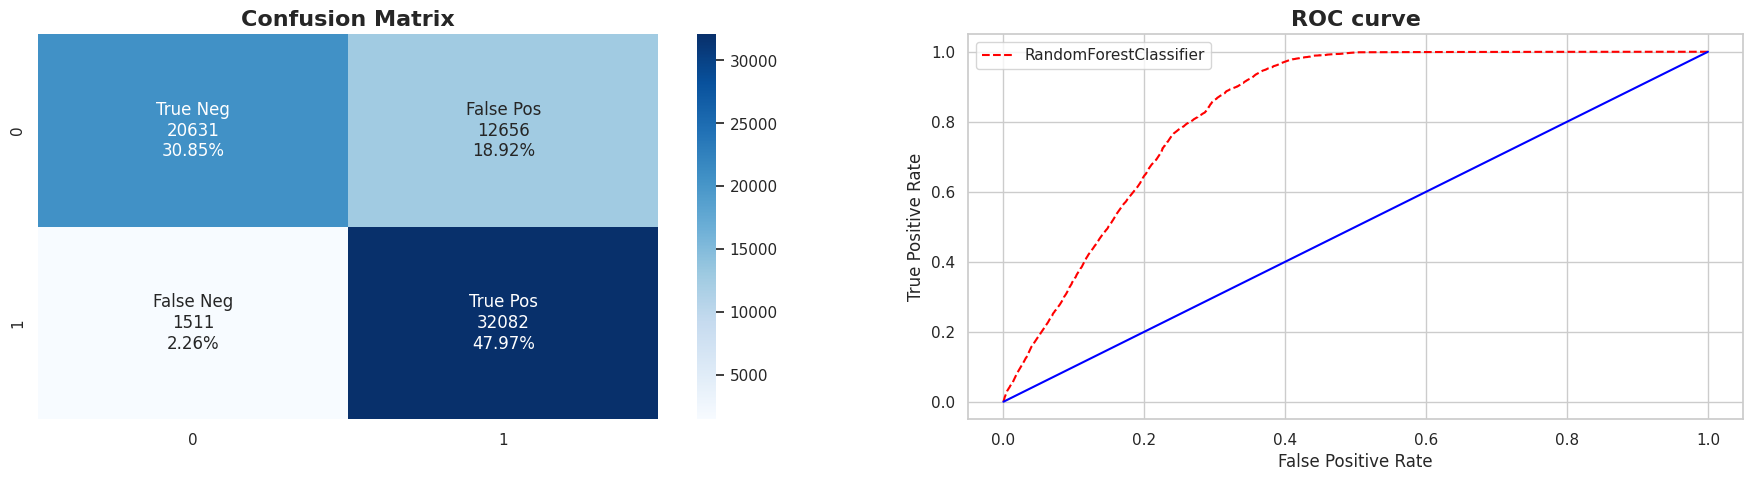

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_random_forest = {'n_estimators': [100, 200, 400],
                            'max_depth': [3, 5, 7],
                            'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)

### 4.4.6 XGBoost

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.803813   0.827575  0.803195  0.799964       0.857278  0.413806


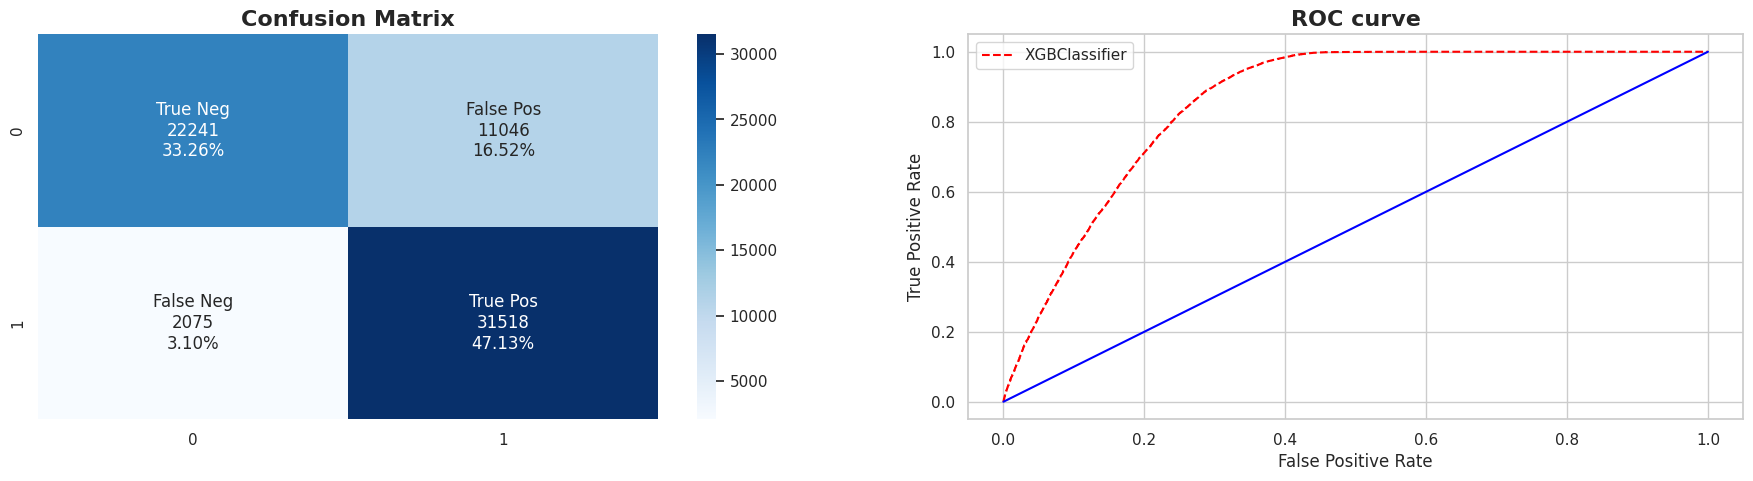

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=30095. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for XGBClassifier : 0.7434752509518864 
---
Best Parameters for XGBClassifier : {'random_state': 42, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
--------------------------------------------------
Elapsed Time: 00:00:11

Evaluation of XGBClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.797548    0.82323  0.796901    0.7932       0.852141  0.419725


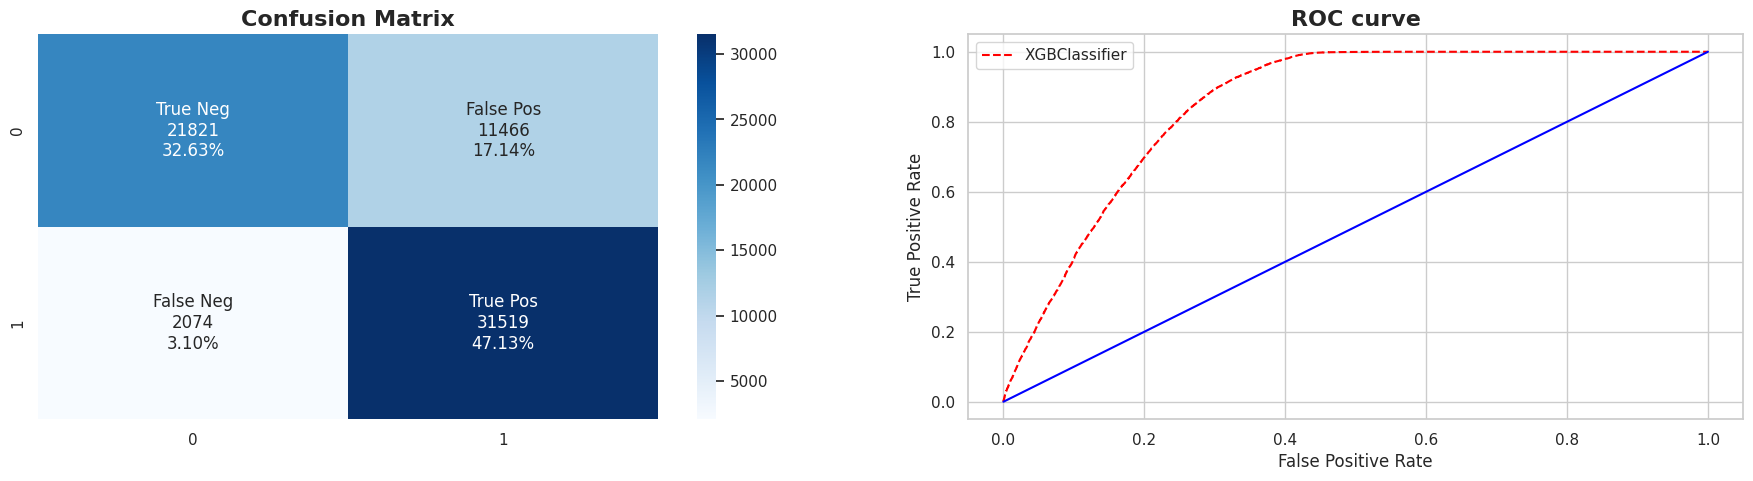

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_xgb = {'n_estimators': [100, 200, 400],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.3],
                  'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, xgb.XGBClassifier(), parameters_xgb, Tuning_Method, False)

### 4.4.7 Voting Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------

Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.934495   0.941521  0.934209  0.934202       0.984411  0.216215


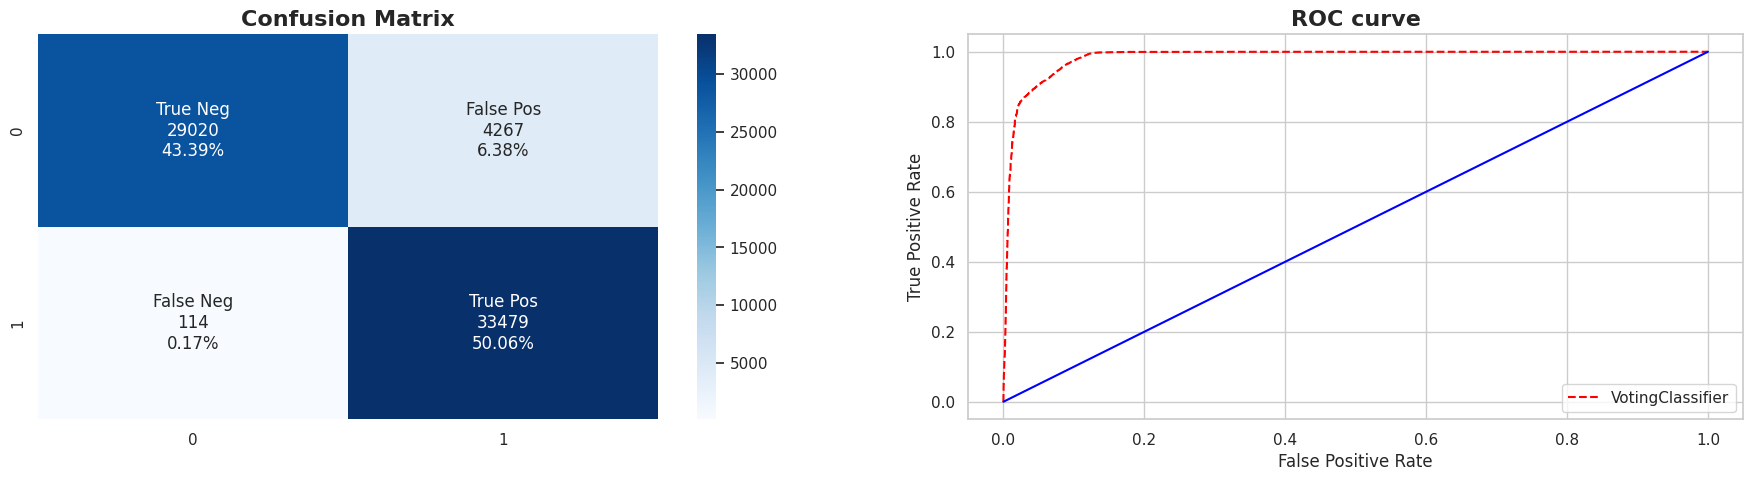

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=30095. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.7323814468674282 
---
Best Parameters for VotingClassifier : {'lr__C': 10.0, 'dt__max_depth': None, 'bagging__n_estimators': 50}
--------------------------------------------------
Elapsed Time: 00:02:10

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.934495   0.941521  0.934209  0.934202        0.98441  0.216211


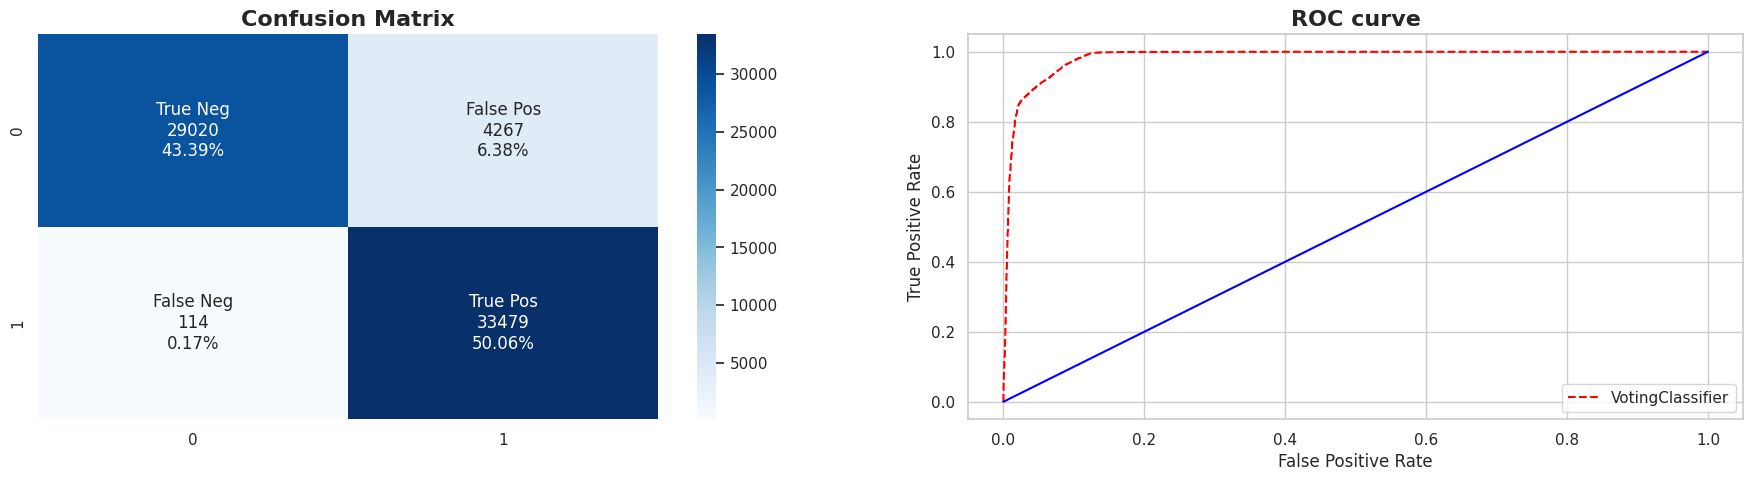

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)

## 4.6 RATIO 95:05

### 4.1.1 Upload Data

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:

def plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba):
    fig, axes = plt.subplots(1, 2, figsize=(22, 5))

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, ax=axes[0], annot=labels, fmt='', cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})

    # ROC curve
    fpr, tpr, thresh = roc_curve(y_valid, y_pred_proba[:, 1], pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linestyle='--', color='red', label=type(model).__name__)
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.legend(loc='best')
    plt.show()

In [ ]:
def visualization(results_df, parameters):
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(columns=shorten_param)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
        results_df,
        color="mean_test_score",
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Hyper Parameter Tuning',)
    fig.show()

In [ ]:
def evaluation_metrics(y_valid, y_pred, y_pred_proba):
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = accuracy_score(y_valid, y_pred)
    metrics_dict['Precision'] = precision_score(y_valid, y_pred, average='macro')
    metrics_dict['Recall'] = recall_score(y_valid, y_pred, average='macro')
    metrics_dict['F1_Score'] = f1_score(y_valid, y_pred, average='macro')
    metrics_dict['ROC_AUC_Score'] = roc_auc_score(y_valid, y_pred_proba[:, 1])
    metrics_dict['Log_Loss'] = log_loss(y_valid, y_pred_proba)

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)

In [ ]:
def hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=5, n_iter=50, n_jobs=-1)
    elif tuning_model == 'Grid_Search_CV':
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)

    start_time = time.time()
    tuned_model.fit(X_train, y_train)
    stop_time = time.time()

    print('*****'*10 + f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}', '\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n' + '-----'*10)
    print('Elapsed Time:', time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model

In [ ]:
def perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model):
    print('-----'*10 + f'\n{type(model).__name__}\n' + '-----'*10)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, y_pred, y_pred_proba)

    plot_confusion_matrix_and_roc_curves(model, X_valid, y_valid, y_pred, y_pred_proba)

    # Hyper-parameter tuning (Example)
    tuned_model = hyperparameter_tuning(X_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(X_valid)
    tuned_pred_proba = tuned_model.predict_proba(X_valid)

    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n' + '-----'*10)
    evaluation_metrics(y_valid, tuned_pred, tuned_pred_proba)

    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, X_valid, y_valid, tuned_pred, tuned_pred_proba)

In [ ]:
def ml_algorithm_implementation(train, model, parameters, tuning_model, feature_importance=False):
    if feature_importance == False:
        print('########' * 8 + '\n     <<<< ' + f'Tuning Model: {tuning_model}' + ' >>>>\n' + '********' * 8)

    target_column = 'Response'
    y = train[target_column]
    X = train.drop(target_column, axis=1)

    # Train Test Split
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(f'Resampled dataset shape {X_ros.shape}, {y_ros.shape}')

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.05, random_state=42)

    if feature_importance:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_valid, y_train, y_valid, model, parameters, tuning_model)

### 4.4.2 Decision Tree

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------

Evaluation of DecisionTreeClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.937859   0.943979  0.937138  0.937564       0.947574  1.616627


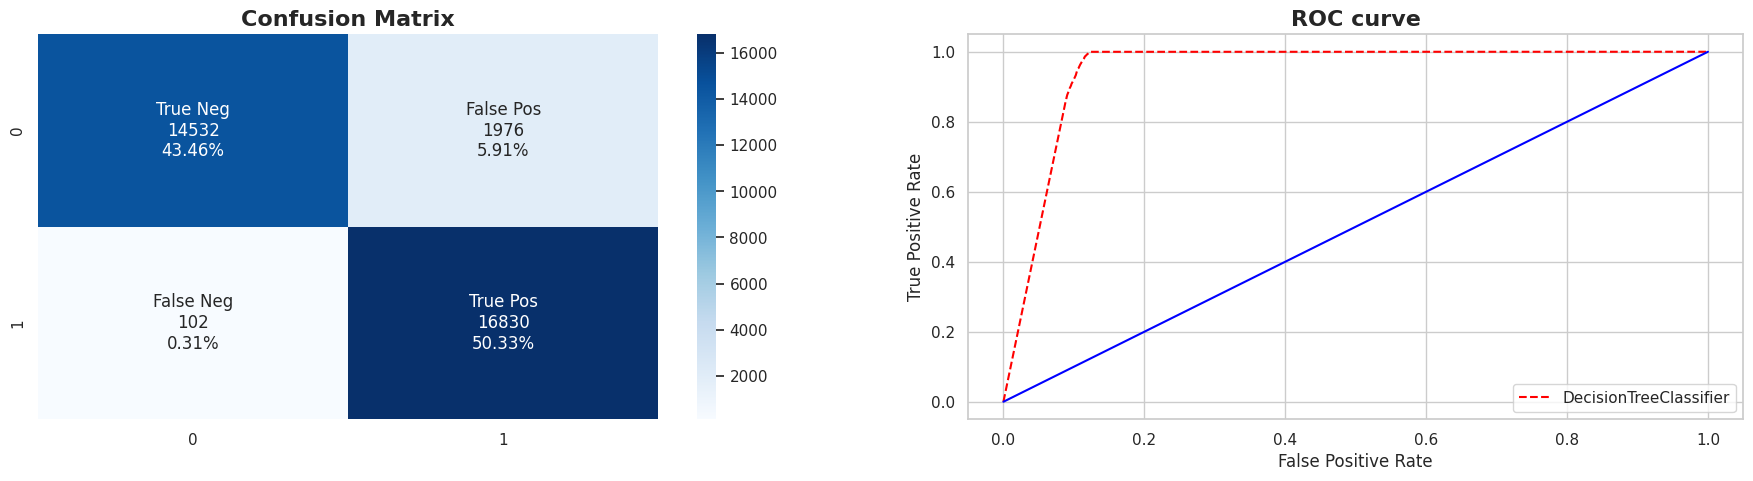

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3200 is smaller than n_iter=31767. Running 3200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:

Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_decision_tree = {"splitter":["best","random"],
            "max_depth" : [None,5,7,9],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0, 0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,40,50,60],
           'random_state':[42]}
ml_algorithm_implementation(train, DecisionTreeClassifier(), parameters_decision_tree, Tuning_Method, False)

### 4.4.3 Logistic Regression

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
LogisticRegression
--------------------------------------------------

Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.787261   0.835286  0.784847  0.778363       0.829121  0.443803


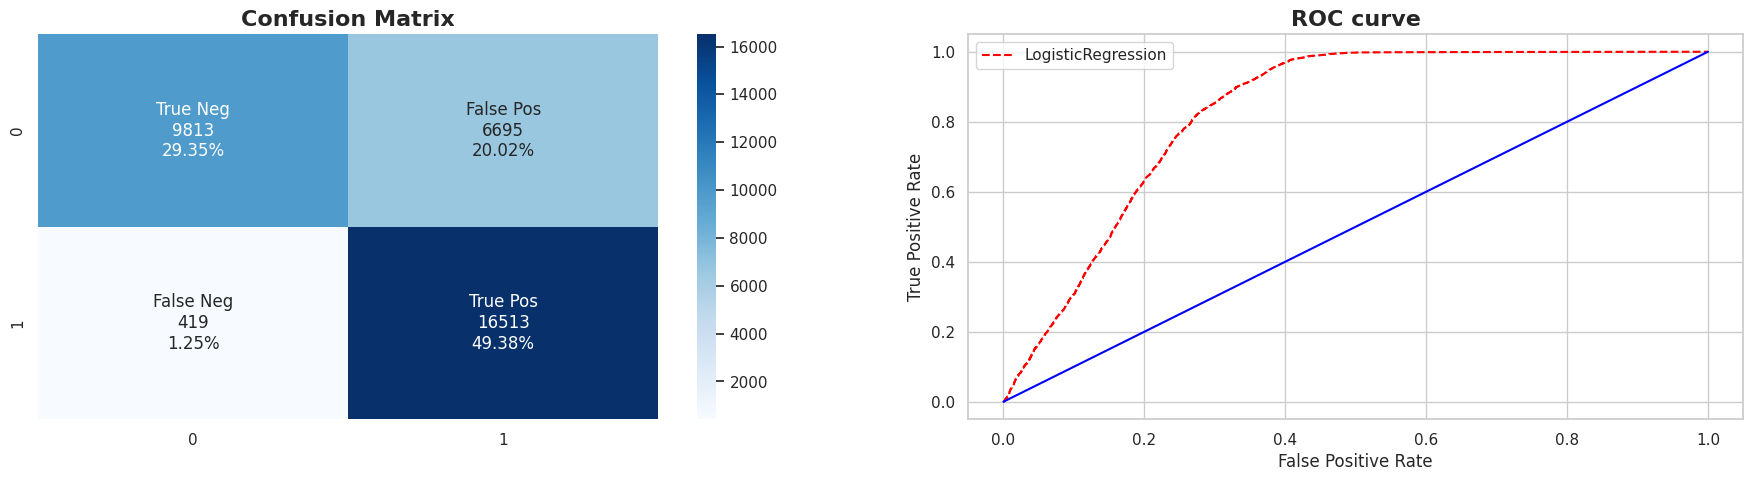

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=31767. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for LogisticRegression : 0.7620110764970577 
---
Best Parameters for LogisticRegression : {'solver': 'sag', 'random_state': 42, 'penalty': 'l2', 'C': 10}
--------------------------------------------------
Elapsed Time: 00:00:12

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.787261   0.835286  0.784847  0.778363       0.829126  0.443804


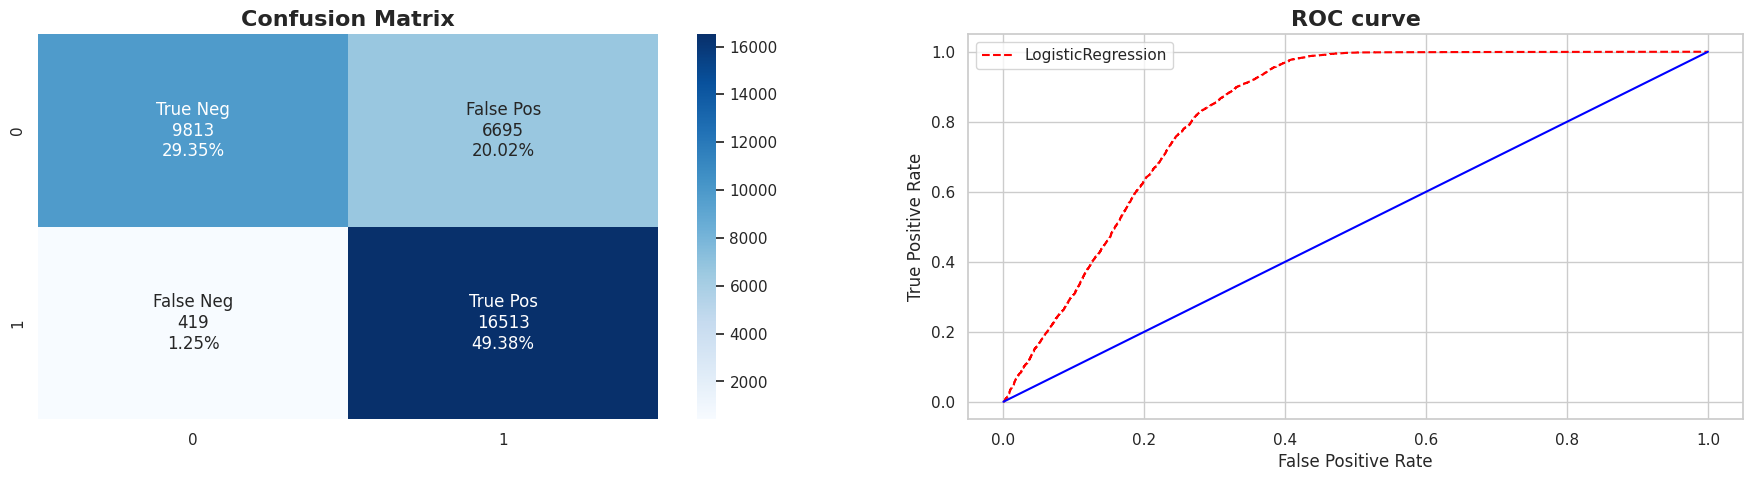

In [ ]:
# Set the tuning method
Tuning_Method = 'Halving_Randomized_Search_CV'

# Define the parameters for the logistic regression model
parameters_logistic = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                        'penalty' : ['l2'],
                        'C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
                       'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)


### 4.4.4 Bagging Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
BaggingClassifier
--------------------------------------------------

Evaluation of BaggingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.940042   0.945801  0.939345  0.939773       0.987034  0.344042


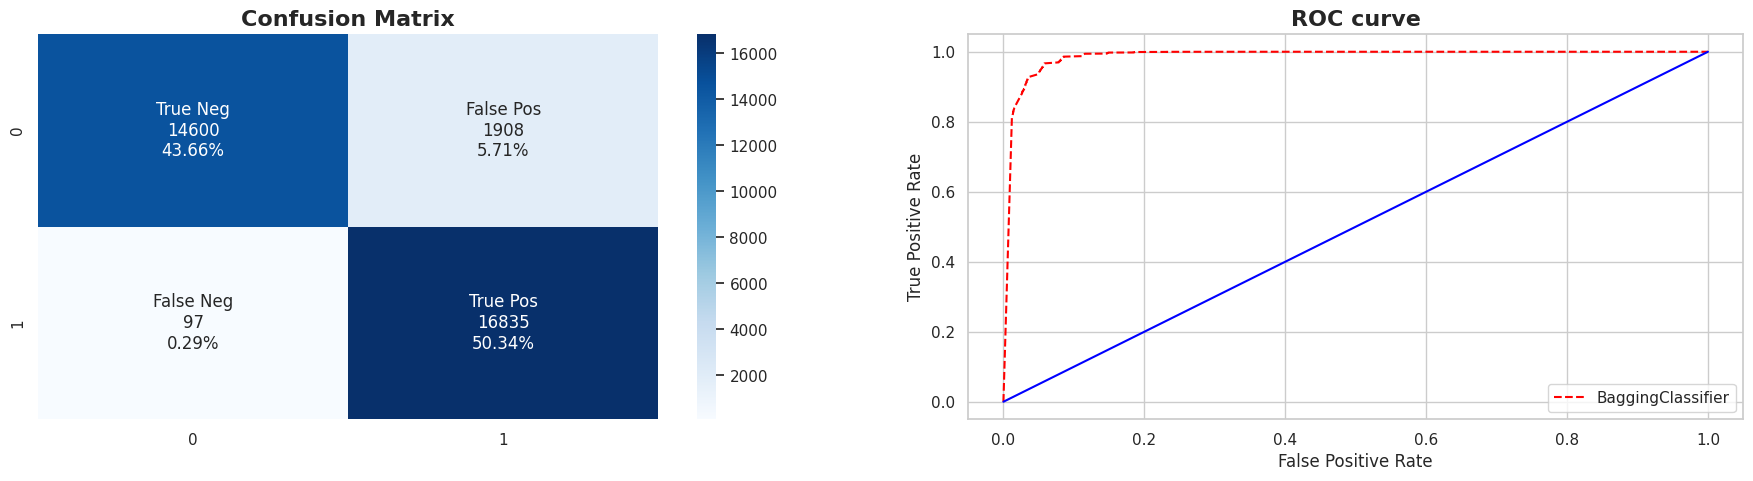

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=31767. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for BaggingClassifier : 0.7606060606060605 
---
Best Parameters for BaggingClassifier : {'random_state': 42, 'n_estimators': 200}
--------------------------------------------------
Elapsed Time: 00:07:11

Evaluation of BaggingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.938038   0.944379  0.937305  0.937735       0.990572  0.231697


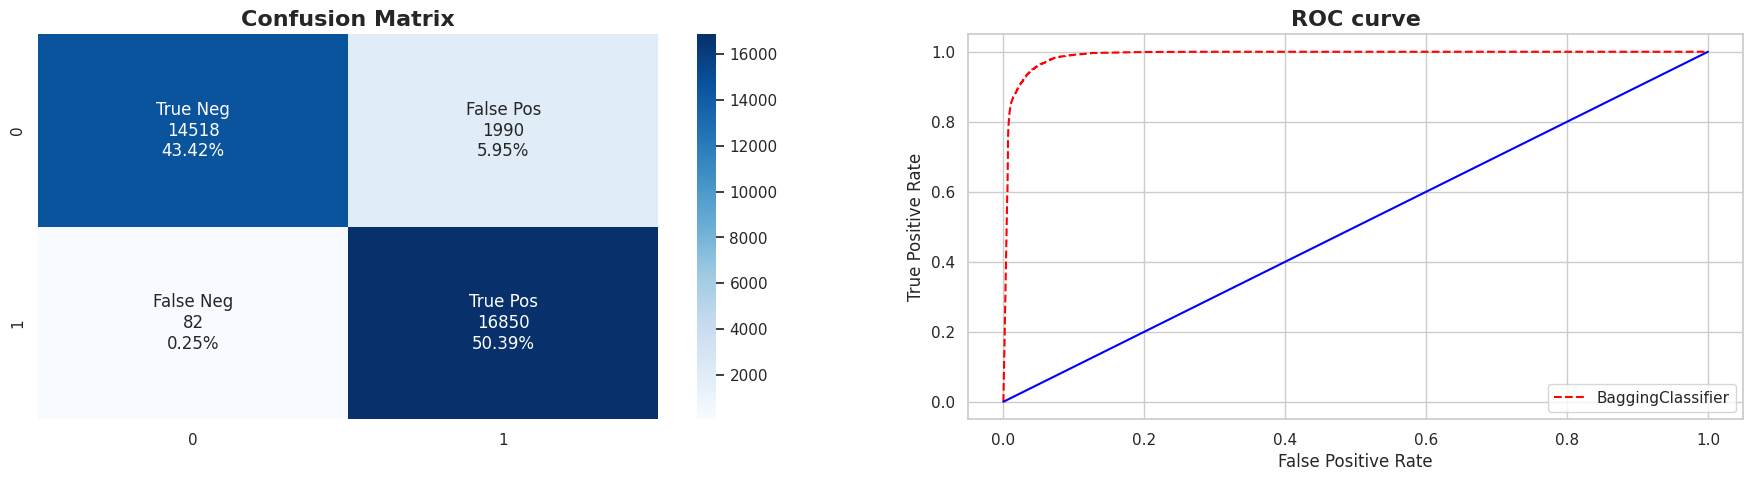

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

parameters_bagging = {'n_estimators':[10, 100, 200, 400],
                      'random_state':[42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, BaggingClassifier(), parameters_bagging, Tuning_Method, False)


### 4.4.5 Random Forest

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.937051   0.943551  0.936308  0.936737       0.989274  0.251521


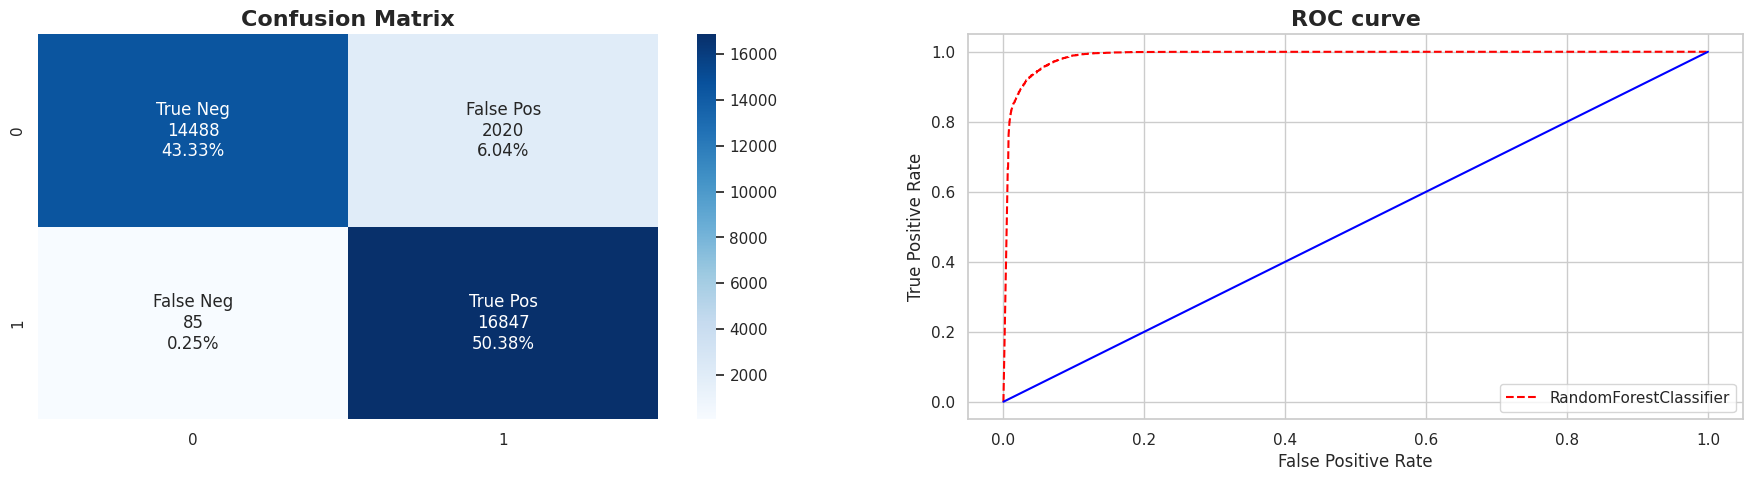

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=31767. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for RandomForestClassifier : 0.740952380952381 
---
Best Parameters for RandomForestClassifier : {'random_state': 42, 'n_estimators': 200, 'max_depth': 7}
--------------------------------------------------
Elapsed Time: 00:01:31

Evaluation of RandomForestClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.791776   0.824771  0.789739   0.78553       0.844791  0.431429


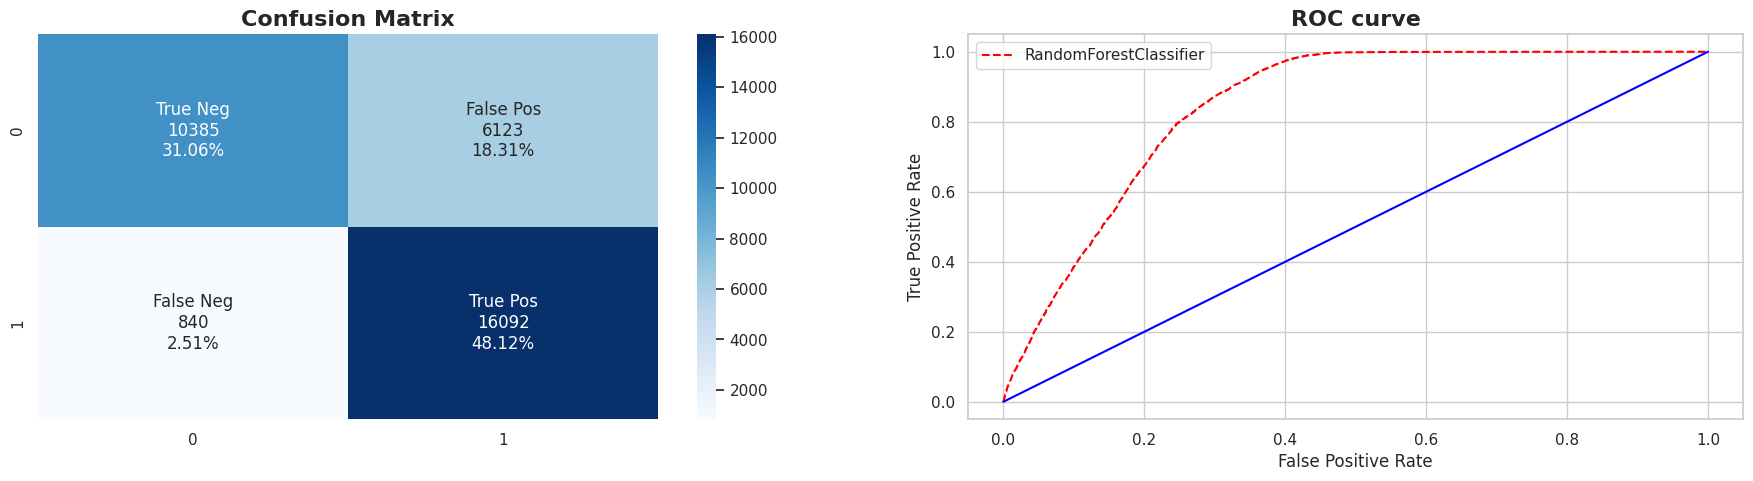

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_random_forest = {'n_estimators': [100, 200, 400],
                            'max_depth': [3, 5, 7],
                            'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)

### 4.4.6 XGBoost

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0         0.80006   0.824282  0.798312  0.795584       0.856549  0.414527


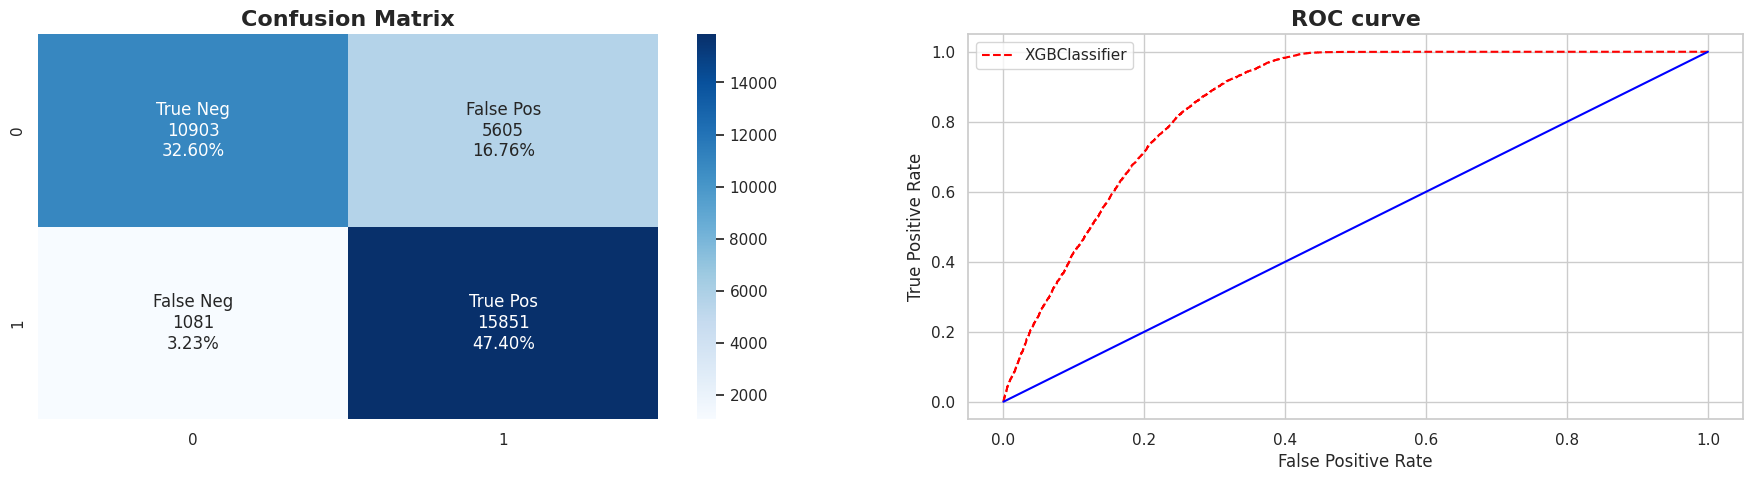

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=31767. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for XGBClassifier : 0.7676531671858775 
---
Best Parameters for XGBClassifier : {'random_state': 42, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1}
--------------------------------------------------
Elapsed Time: 00:00:16

Evaluation of XGBClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0         0.79055   0.818572  0.788652  0.785069       0.846113  0.428543


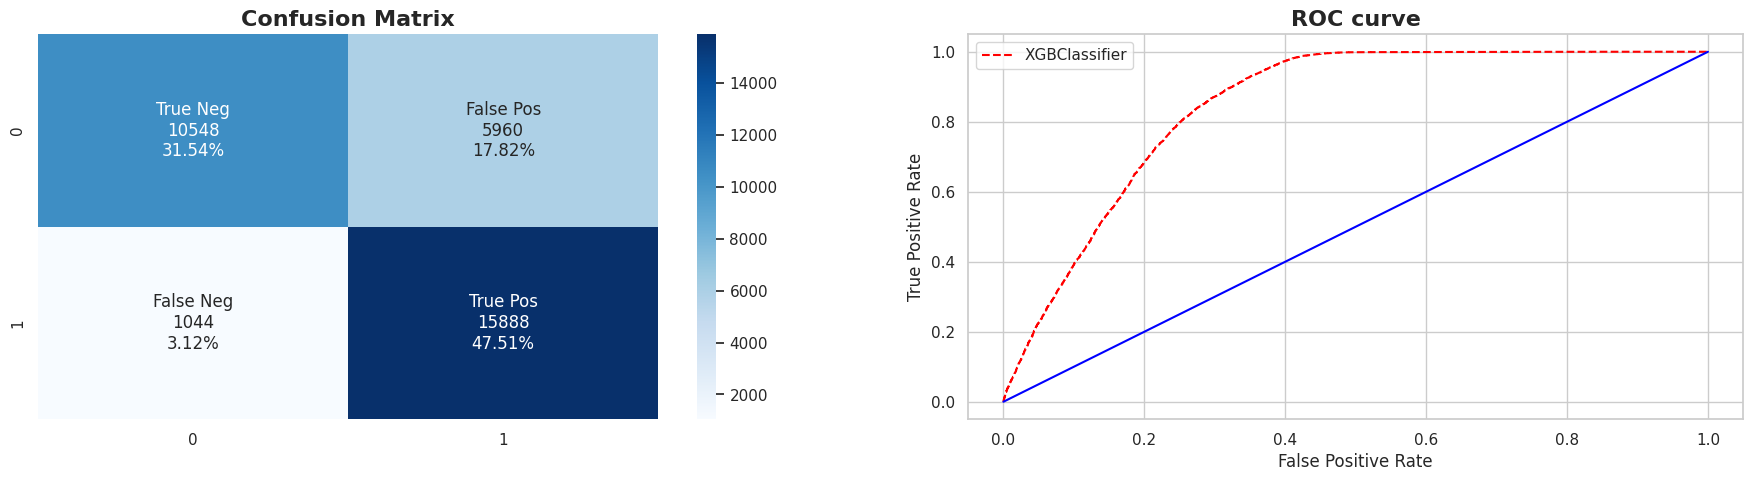

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'
parameters_xgb = {'n_estimators': [100, 200, 400],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.3],
                  'random_state': [42]}

# Run the Optuna hyperparameter tuning
ml_algorithm_implementation(train, xgb.XGBClassifier(), parameters_xgb, Tuning_Method, False)

### 4.4.7 Voting Classifier

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
Resampled dataset shape (668798, 10), (668798,)
--------------------------------------------------
VotingClassifier
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluation of VotingClassifier before tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.936663   0.943861  0.935879  0.936317       0.985167  0.213223


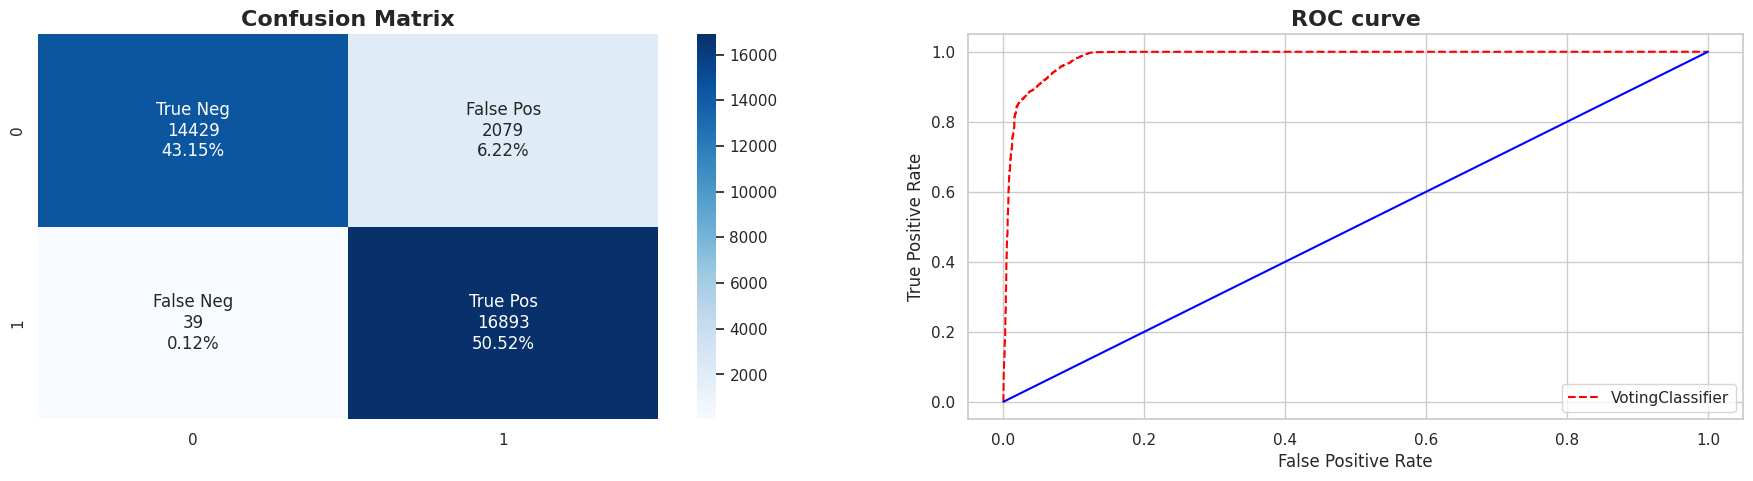

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=31767. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**************************************************
Best Score for VotingClassifier : 0.7230356524749049 
---
Best Parameters for VotingClassifier : {'lr__C': 10.0, 'dt__max_depth': 10, 'bagging__n_estimators': 100}
--------------------------------------------------
Elapsed Time: 00:03:57

Evaluation of VotingClassifier after tuning:
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.854276   0.880708  0.852609  0.851264       0.972777  0.306391


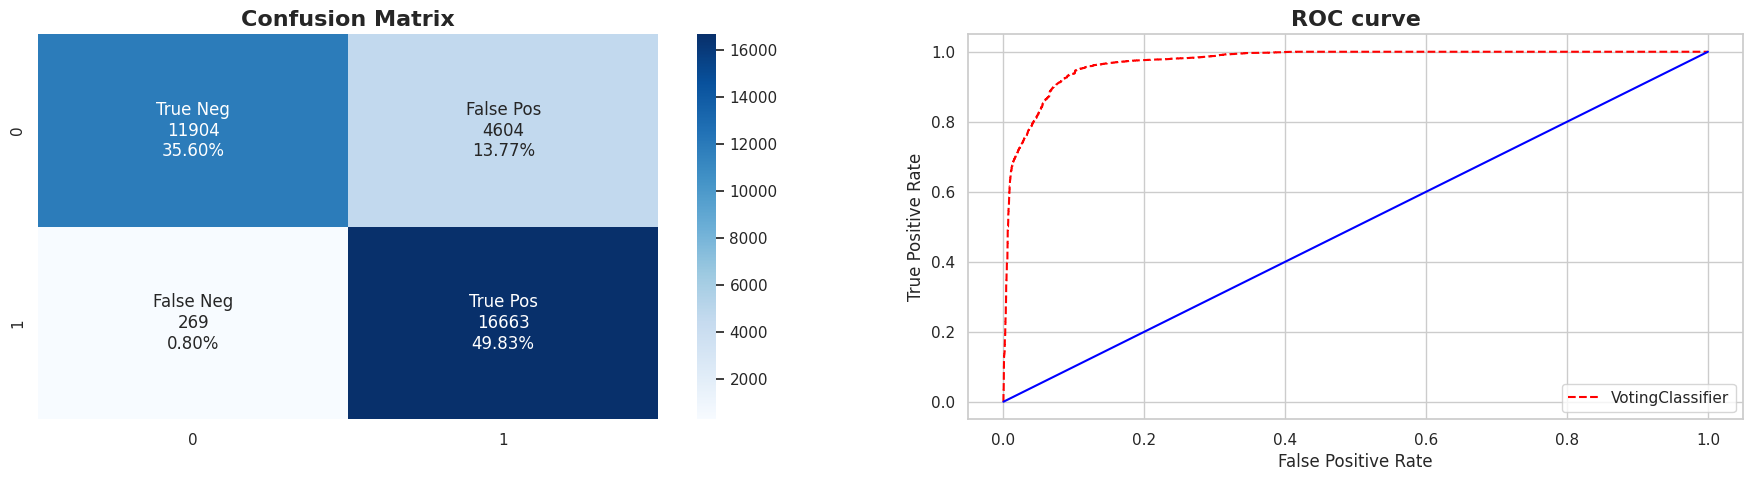

In [ ]:
Tuning_Method = 'Halving_Randomized_Search_CV'

# Defining the base estimators for the voting classifier
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=100)
bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

# Parameters for the voting classifier
parameters_voting = {
    'dt__max_depth': [None, 10, 20, 30],
    'lr__C': [0.1, 1.0, 10.0],
    'bagging__n_estimators': [20, 50, 100]
}

voting_clf = VotingClassifier(
    estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
    voting='soft'
)

# Assuming the implementation function is named `ml_algorithm_implementation`
ml_algorithm_implementation(train, voting_clf, parameters_voting, Tuning_Method, False)